# Descripción del Dataset

**Resumen de las variables del dataset**

- `id`: sólo para archivos de envío de pruebas y muestras, id para la identificación de muestras de predicción


- `price`: precio en USD


- `carat`: peso del diamante


- `cut`: calidad de la talla (aceptable, buena, muy buena, superior, ideal)


- `color`: color del diamante, de J (peor) a D (mejor)


- `clarity`: medida de la claridad del diamante (I1 (peor), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (mejor))


- `x`: longitud en mm


- `y`: anchura en mm


- `z`: profundidad en mm


- `depth`: porcentaje de profundidad total = z / media(x, y) = 2 * z / (x + y) (43--79)


- `table`: anchura de la parte superior del diamante en relación con el punto más ancho (43--95) 

![Caracteristicas_diamante](https://www.diamondstory.com.au/pub/media/wysiwyg/a.jpg)

# Importar librerias

In [1]:
import pandas as pd
import sidetable as stb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pickle

import statsmodels.formula.api as smf
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

import catboost as cb

import sys
sys.path.append('../')
from src.set_functions import *

# Carga de datos

In [2]:
print("-------------------------------Cargando dataset--------------------------------")
df = pd.read_csv("../Data/train.csv", index_col= 0)

-------------------------------Cargando dataset--------------------------------


# Análisis exploratorio, EDA

In [3]:
df.head(3)

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983


In [4]:
print("Filas del dataset:", df.shape[0])
print("Columnas del dataset:", df.shape[1])

Filas del dataset: 40455
Columnas del dataset: 10


In [5]:
# Exploramos los tipos de los datos que tenemos
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

In [6]:
# Cuantas filas tenemos duplicadas en el dataset
df.duplicated().sum()

85

In [7]:
# Cuántos valores nulos tenemos en el dataset
df.stb.missing()

,missing,total,percent
carat,0,40455,0.0
cut,0,40455,0.0
color,0,40455,0.0
clarity,0,40455,0.0
depth,0,40455,0.0
table,0,40455,0.0
x,0,40455,0.0
y,0,40455,0.0
z,0,40455,0.0
price,0,40455,0.0


In [8]:
# Principales estadísticos de las variables numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,40455.0,0.797576,0.475939,0.200,0.400,0.70,1.040,5.010
depth,40455.0,61.746377,1.436796,43.000,61.000,61.80,62.500,79.000
table,40455.0,57.451694,2.234569,44.000,56.000,57.00,59.000,95.000
x,40455.0,5.729163,1.125244,0.000,4.710,5.69,6.540,10.740
y,40455.0,5.732896,1.154799,0.000,4.720,5.70,6.540,58.900
z,40455.0,3.537351,0.711002,0.000,2.910,3.52,4.030,31.800
price,40455.0,7.783822,1.016828,5.787,6.851,7.78,8.581,9.842


In [9]:
# Exploramos variables categóricas
df.describe(include= "object").T

,count,unique,top,freq
cut,40455,5,Ideal,16230
color,40455,7,G,8410
clarity,40455,8,SI1,9779


In [10]:
df.groupby(['cut'])['color'].unique()

cut
Fair         [I, F, H, E, J, G, D]
Good         [D, H, G, J, E, F, I]
Ideal        [E, F, D, G, I, H, J]
Premium      [D, G, H, E, I, F, J]
Very Good    [G, E, H, I, J, D, F]
Name: color, dtype: object

**Resumen EDA**

- La muestra tiene un total de 40455 diamantes de los cuales 85 de ellos tienen las mismas características.

- El peso de un diamante oscila entre 0.40 y 0.70, pesando de media 0.79.

- El precio medio de un diamante es de 7.78.

- La muestra de diamantes tiene erratas, ya que hay diamantes que sus medidas son 0 mm.

- La muestra contiene 85 diamantes duplicados.

- Hay cinco tipos de diamantes y siete colores para cada uno de ellos, teniendo los mismos colores en cualquier tipo de diamante.

#  Análisis exploratorio visual

In [11]:
df['price-carat'] = df['price'] / df['carat']

Antes de llevar a cabo el análisis visual de las variables, creamos una columna dividendo el precio del diamante entre el peso del propio diamante.

## Variable respuesta

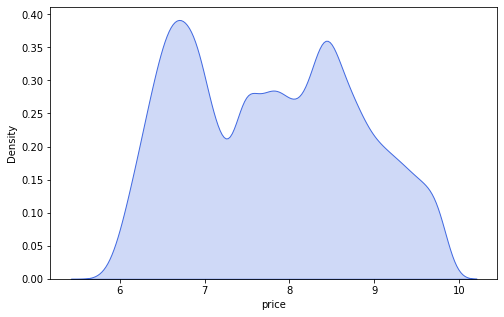

In [12]:
plt.figure(figsize = (8,5))
sns.distplot(df['price'], hist = False, color = "Royalblue", kde_kws = {"shade": True, "linewidth": 1});

Al visualizar la variable respuesta comprobamos que no llega a tener una distribución normal al tener una barriga hacía dentro en la parte central. En este caso, decimos no normalizar la variable para que no se generen disputas entre los resultados que pronostiquemos y los resultados ya publicados en Kaggle.com 

## Variables predictoras

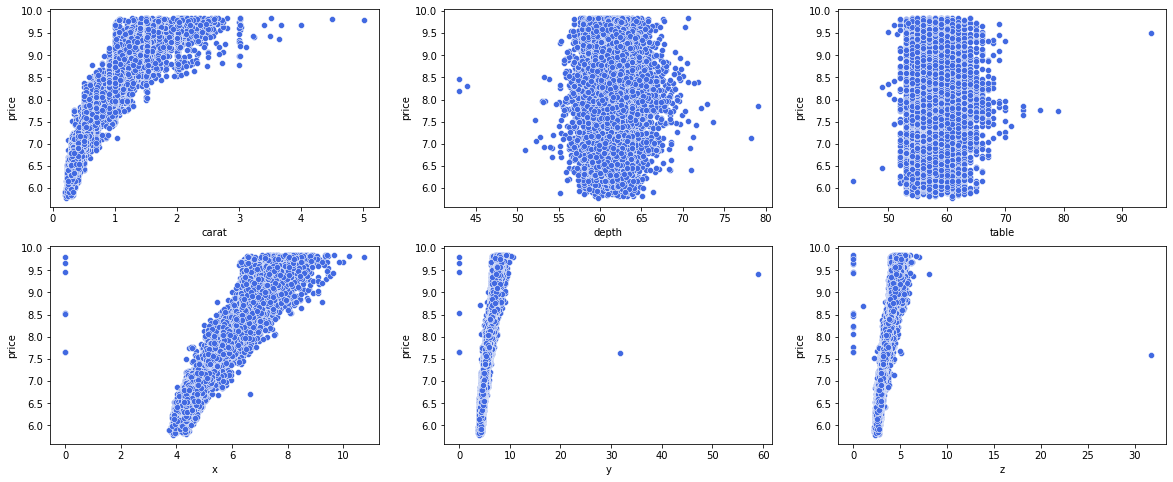

In [13]:
num_cols = df.select_dtypes(include=np.number).columns.drop(['price', 'price-carat'])

fig, ax = plt.subplots(2, 3, figsize=(20,8))
for i in range(len(num_cols)):
    sns.scatterplot(data = df, x = num_cols[i], y = 'price', color = "Royalblue", ax = ax.flatten()[i]);

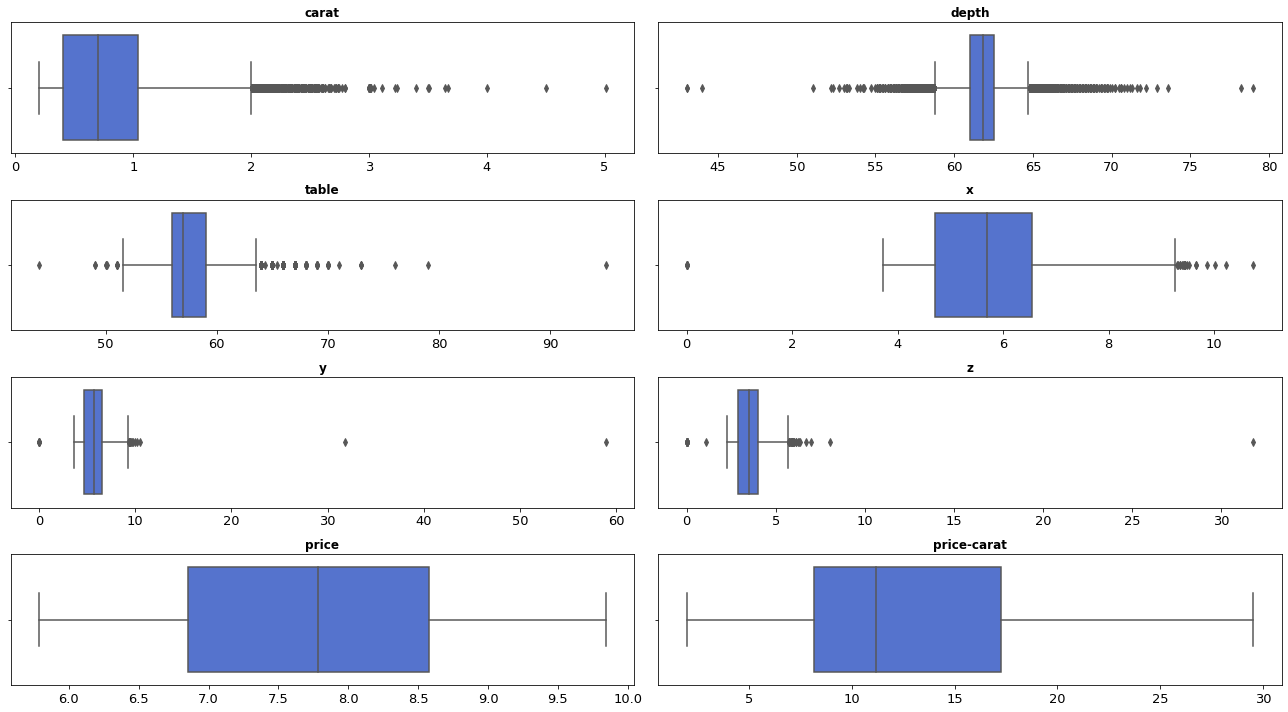

In [14]:
num_cols2 = df.select_dtypes(np.number).columns

fig, axes = plt.subplots( 4, 2, figsize=(18, 10))
axes = axes.flat

for i in range(len(num_cols2)): 
    sns.boxplot(data = df, x = num_cols2[i], color= 'Royalblue', ax= axes[i]).set_title(num_cols2[i], fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 13)
    axes[i].set_xlabel("")

fig.tight_layout();

En la exploración visual observamos algunos outliers que deben ser analizamos con más precisión.

### Correlación entre variables numéricas

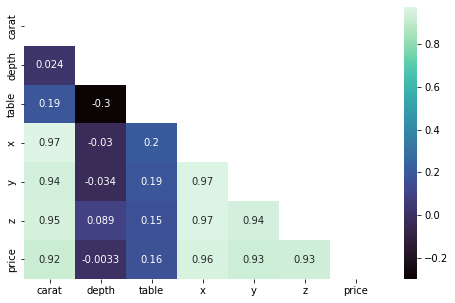

In [15]:
df_corr = df.select_dtypes(include=np.number).drop('price-carat', axis=1).corr()

plt.figure(figsize = (8,5))

mask = np.triu(np.ones_like(df_corr, dtype = np.bool))
sns.heatmap(df_corr, cmap = "mako", mask = mask, annot = True);

## Variables categóricas

### Cantidad de diamantes Vs Categoría 

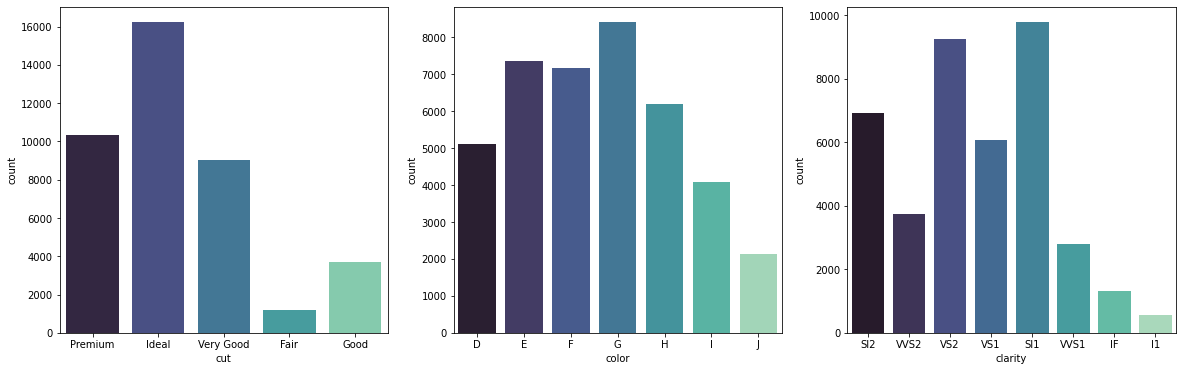

In [16]:
fig, ax = plt.subplots( 1,3, figsize=(20,6))

sns.countplot(data = df, x = "cut", palette = "mako", ax = ax[0])
sns.countplot(data = df, x = "color", palette = "mako", ax = ax[1])
sns.countplot(data = df, x = "clarity", palette = "mako", ax = ax[2]);

In [17]:
groupby_color = df.groupby(['color'])['price'].agg(['min', 'max', 'std', 'var','mean', 'median']).sort_values(by = 'mean', ascending = False)
display(groupby_color)

,min,max,std,var,mean,median
color,,,,,,
J,5.814,9.837,1.038103,1.077658,8.153645,8.3595
I,5.817,9.841,1.114558,1.242240,8.020831,8.2280
H,5.823,9.842,1.062808,1.129560,7.906876,8.1280
G,5.869,9.842,1.028158,1.057108,7.798679,7.7280
F,5.878,9.841,0.972335,0.945435,7.762877,7.7600
D,5.878,9.830,0.930310,0.865476,7.615236,7.5110
E,5.787,9.838,0.922358,0.850744,7.562944,7.4380


### Relación de las variables categóricas con Price-Carat

#### Price-Carat Vs Color

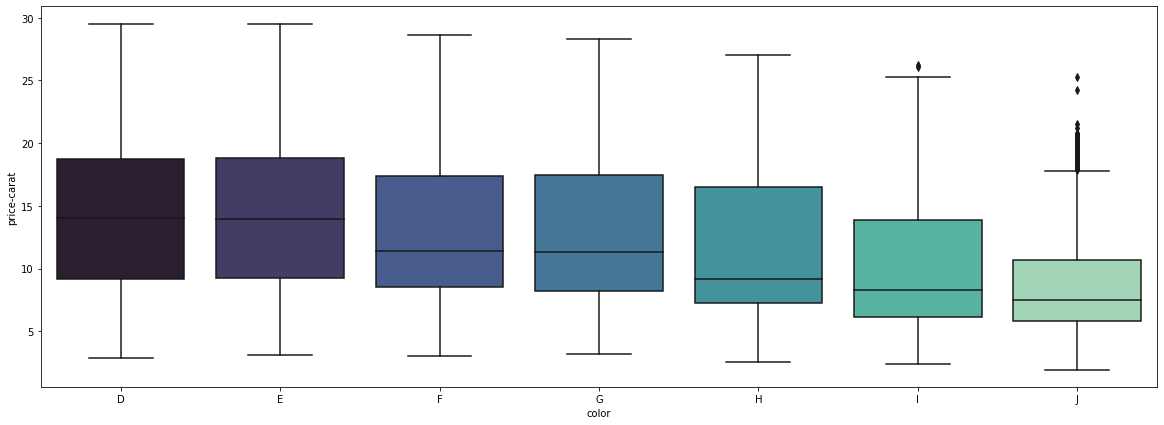

In [18]:
plt.figure(figsize = (20,7))
sns.boxplot(data = df, x = 'color', y = 'price-carat', palette = "mako");

In [19]:
groupby_color = df.groupby(['color'])['price-carat'].agg(['min', 'max', 'std', 'var','mean', 'median']).sort_values(by = 'mean', ascending = False)
display(groupby_color)

,min,max,std,var,mean,median
color,,,,,,
E,3.118000,29.525000,5.497052,30.217577,14.337250,13.964000
D,2.846471,29.525000,5.249653,27.558860,14.167878,14.013381
F,3.057475,28.625000,5.473303,29.957044,13.157032,11.404256
G,3.162667,28.312000,5.472749,29.950983,12.874318,11.295804
H,2.565753,27.021739,5.597552,31.332591,11.560018,9.181111
I,2.419750,26.200000,5.273040,27.804954,10.452036,8.326000
J,1.955888,25.283333,4.408497,19.434845,8.953350,7.493718


#### Tipo de pureza Vs Price-Carat

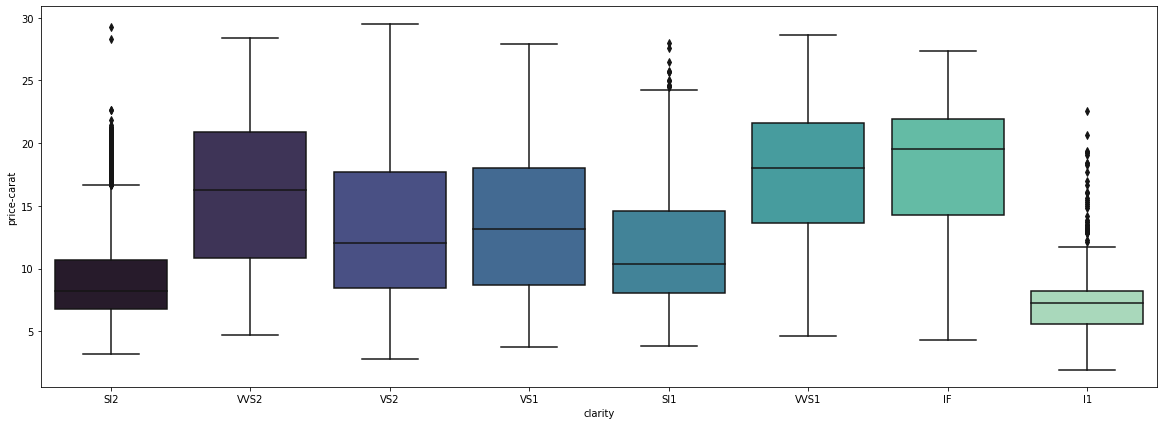

In [20]:
plt.figure(figsize = (20,7))
sns.boxplot(data = df, x = 'clarity', y = 'price-carat', palette = "mako");

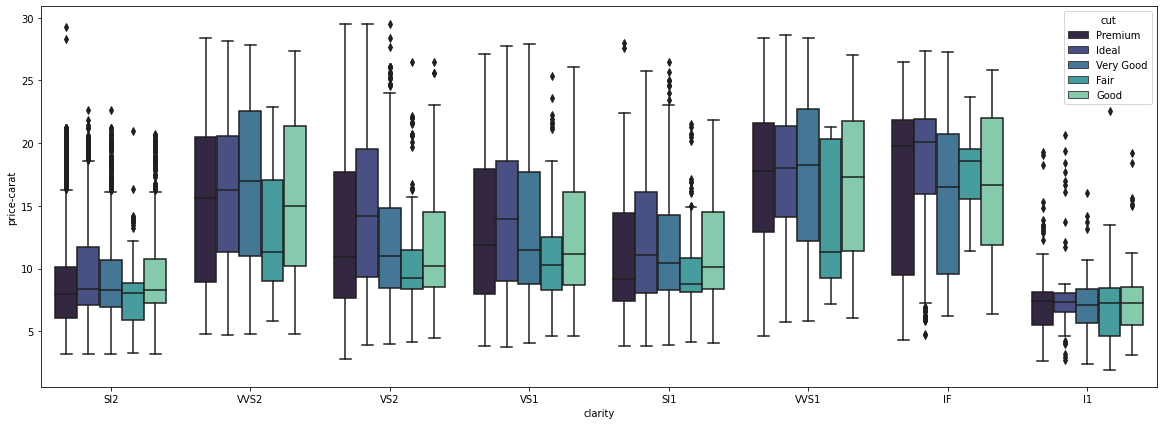

In [21]:
plt.figure(figsize = (20,7))
sns.boxplot(data = df, x = 'clarity', y = 'price-carat', hue='cut', palette = "mako");

#### Calidad del diamante Vs Price-Carat

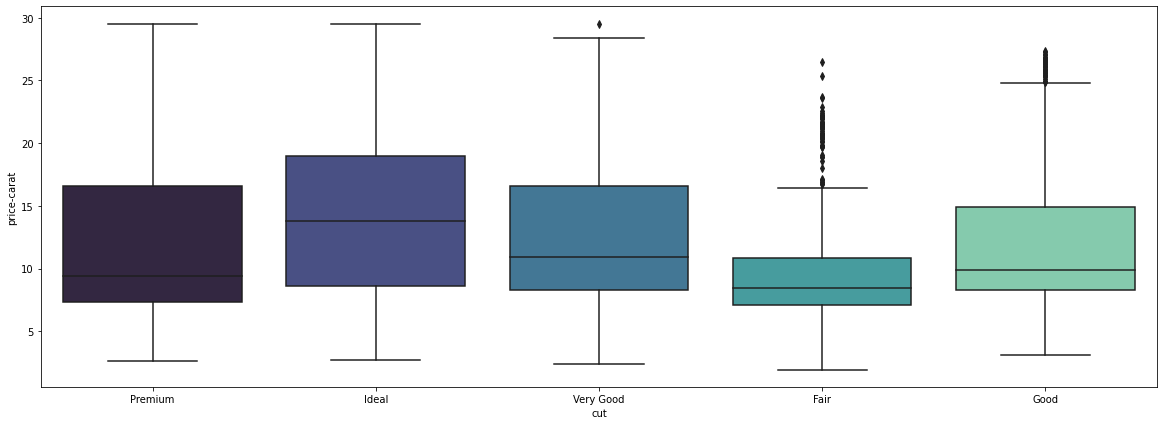

In [22]:
plt.figure(figsize = (20,7))
sns.boxplot(data = df, x = 'cut', y = 'price-carat', palette = "mako");

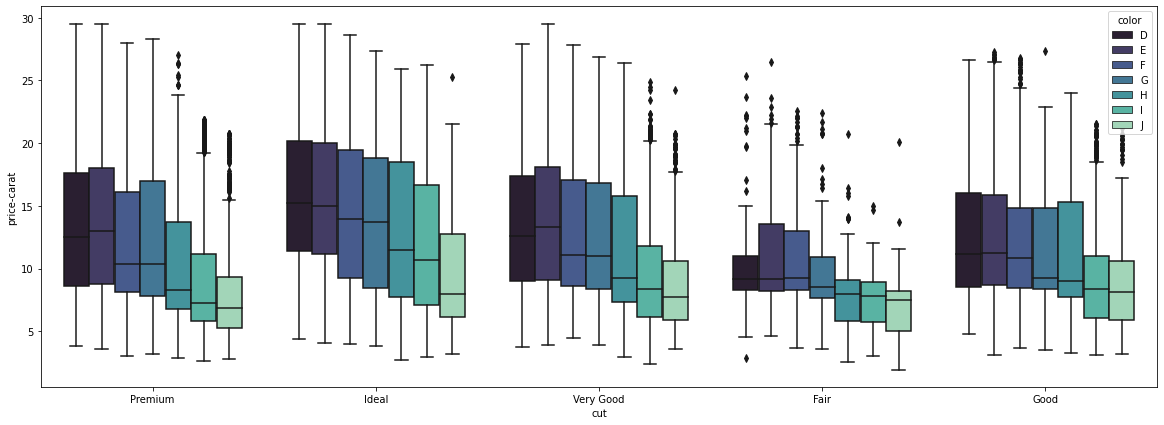

In [23]:
plt.figure(figsize = (20,7))
sns.boxplot(data = df, x = 'cut', y = 'price-carat', hue='color', palette = "mako");

**Resumen del análisis de las variables categóricas**

Las principales conclusiones del análisis de variables categóricas son:
    
- Los colores **D** y **E** parecen estar ligados en relación con el precio-quilate del diamante. A su vez, ambos colores se distinguen por ser los más caros.

- **IF** se sitúa como el diamante con más pureza. Visualmente se ve un orden claro entre los diferentes tipos de pureza.

- Al analizar las purezas detectamos que existe un gran equilibro entre ellas a excepción de **Fair**, que se sitúa como la peor calidad y por tanto, la más barata.  

# Preprocesado

## Limpieza de datos

In [24]:
# diamantes duplicados
df.drop_duplicates(inplace= True)

In [25]:
# Eliminamos los diamantes que no dispongan de medidas
df_filter0 = df[(df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0)]
display(df_filter0.head(3)) # muestra de diamantes sin medidas

df.drop(df_filter0.index, axis= 0, inplace= True)
print(f"{df_filter0.shape[0]} filas han sido eliminadas")

,carat,cut,color,clarity,depth,table,x,y,z,price,price-carat
id,,,,,,,,,,,
1249,2.25,Premium,I,SI1,61.3,58.0,8.52,8.42,0.0,9.642,4.285333
3185,1.20,Premium,D,VVS1,62.1,59.0,0.00,0.00,0.0,9.661,8.050833
4057,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.0,7.664,10.794366


16 filas han sido eliminadas


In [26]:
# Outliers
df = df[df['z'] < 30]
df = df[df['y'] < 30]
df = df[df['table'] < 75]

## Encoding

In [27]:
orden_clarity = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2' , 'VVS1', 'IF']
dict_color = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
df = ordinal_encoder(orden_clarity, df, "clarity")
df["color"] = df["color"].map(dict_color)

dummies = pd.get_dummies(df['cut'], prefix_sep = "_", prefix = 'cut', dtype = int)
df = pd.concat([dummies, df], axis = 1)
df.drop('cut', axis = 1, inplace = True)

df.head(2)

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,carat,color,clarity,depth,table,x,y,z,price,price-carat
id,,,,,,,,,,,,,,,
0,0,0,0,1,0,0.30,6,1,62.4,58.0,4.31,4.28,2.68,6.353,21.176667
1,0,0,1,0,0,1.01,5,5,62.7,56.0,6.42,6.46,4.04,9.183,9.092079


# Ajuste del modelo

In [28]:
df.columns = ['cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very_Good',
       'carat', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price',
       'price-carat']

In [29]:
pred_cols = " + ".join(df.columns.drop(["price", "price-carat"]))
result = smf.ols(f" price ~ {pred_cols} ", data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.607e+05
Date:                Sat, 28 May 2022   Prob (F-statistic):               0.00
Time:                        01:43:29   Log-Likelihood:                 20518.
No. Observations:               40348   AIC:                        -4.101e+04
Df Residuals:                   40335   BIC:                        -4.090e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.0874      0.089    -23.324      0.000      -2.263      -1.912
cut_Fair         -0.5381      0.019    -28.820      0.000      -0.575      -0.502
cut_Good         -0.4271      0.018    -23.353      0.000      -0.463      -0.391
cut_Ideal        -0.3535      0.018    -20.149      0.000      -0.388      -0.319
cut_Premium      -0.3755      0.018    -21.066      0.000      -0.410      -0.341
cut_Very_Good    -0.3932      0.018    -21.946      0.000      -0.428      -0.358
carat            -1.1148      0.008   -145.895      0.000      -1.130      -1.100
color             0.0775      0.000    172.122      0.000       0.077       0.078
clarity           0.1204      0.000    245.480      0.000       0.119       0.121
depth             0.0276      0.002     17.167      0.000       0.024       0.031
table             0.0098      0.000     22.314      0.000       0.009       0.011
x                 0.6725      0.016     41.990      0.000       0.641       0.704
y                 0.3702      0.016     22.758      0.000       0.338       0.402
z                 0.6400      0.025     25.178      0.000       0.590       0.690
==============================================================================
Omnibus:                     3821.548   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28810.700
Skew:                          -0.060   Prob(JB):                         0.00
Kurtosis:                       7.138   Cond. No.                     9.87e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.99e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Interpretemos los resultados: 

- **coef**: es el coeficiente que representa los cambios medios en la variable respuesta para una unidad de cambio en la variable predictora mientras se mantienen constantes el resto de las variables predictoras. Es la pendiente! 


- **std err**: es el error estándar del coeficiente. Se usa para medir la precisión de la estimación del coeficiente. Cuanto menor sea el error estándar, más precisa será la estimación. 


- **t** : es el resultado de dicivir el coeficiente entre su error estándar 


- **P**: corresponde con el *p-valor*. Este valor es que usaremos para decidir si una variable tiene efecto significativo sobre nuestra variable respuesta o no, de esta forma: 

    - p-valor < 0.05 esa variable tiene un efecto significativo sobre el precio de las casas. Afecta al precio de la casa
    
    - p-valor > 0.05 esa variable NO tiene un efecto significativo sobre el precio de las casas. 
   
   
- **R-squared**: el porcentaje de la variación de la variable respuesta está explicado por nuestro modelo.

In [30]:
df.drop(['price-carat', 'depth'], axis=1, inplace=True)

In [31]:
# dividimos el dataset en variables predictoras y respuesta
X = df.drop('price', axis = 1) # variables predictoras
y = df["price"] # variable respuesta 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 99)

In [33]:
print("Datos de entrenamiento")
print("-----------------------")
print(y_train.describe())

Datos de entrenamiento
-----------------------
count    32278.000000
mean         7.784311
std          1.016979
min          5.787000
25%          6.851000
50%          7.782000
75%          8.581000
max          9.842000
Name: price, dtype: float64


In [34]:
print("Datos de testeo")
print("-----------------------")
print(y_test.describe())

Datos de testeo
-----------------------
count    8070.000000
mean        7.780635
std         1.014921
min         5.826000
25%         6.851000
50%         7.770500
75%         8.575000
max         9.841000
Name: price, dtype: float64


# Modelos

## Gradient Boosting

El algoritmo Gradient Boost es uno de los algoritmos más potentes en el campo del aprendizaje automático. Un modelo Gradient Boosting está formado por un conjunto de árboles de decisión individuales, entrenados de forma secuencial, de forma que cada nuevo árbol trata de mejorar los errores de los árboles anteriores. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

In [35]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [36]:
gb = GradientBoostingRegressor(n_estimators=42, learning_rate=0.2, max_depth=9, random_state=42)
gb.fit(X_train, y_train);

In [37]:
y_pred_gb_test= gb.predict(X_test)
y_pred_gb_train= gb.predict(X_train)

In [38]:
dt_results1 = metricas(y_test, y_train, y_pred_gb_test, y_pred_gb_train, "Gradient")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.063157,0.007633,0.087369,0.992589,test,Gradient
1,0.045615,0.003880,0.062290,0.996248,train,Gradient


In [39]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_gb_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred_gb_test,  'Set': ['Test']*len(y_test)})
results = pd.concat([train_df,test_df], axis = 0)
results.head()

,Real,Predicted,Set
id,,,
4444,8.425,8.422326,Train
23446,8.824,8.904683,Train
22747,6.469,6.447498,Train
16751,7.520,7.479147,Train
27913,8.144,8.061620,Train


<AxesSubplot:xlabel='Real', ylabel='Predicted'>

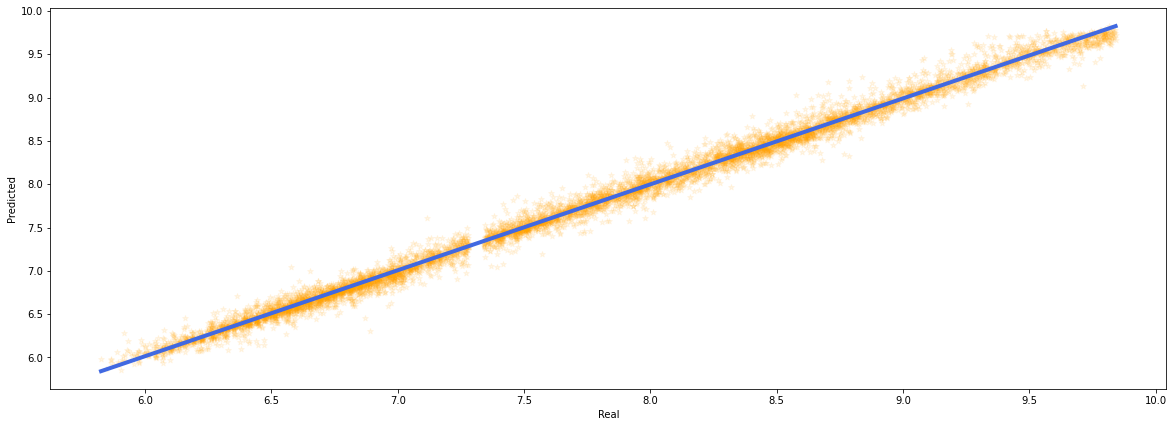

In [40]:
plt.figure(figsize = (20,7))
sns.regplot(data = results[results['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "orange",
            line_kws = {"color": "Royalblue", "lw":4, },
            scatter_kws={'alpha':0.09},
            marker = "*")

## Catboost

CatBoost es un algoritmo de refuerzo de gradiente en árboles de decisión. Está desarrollado por investigadores e ingenieros de Yandex, y se utiliza para la búsqueda, los sistemas de recomendación, el asistente personal, los coches autodirigidos, la predicción del tiempo y muchas otras tareas

In [41]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [42]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [43]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.1,0.2, 0.3],
        'depth': [6, 8,9, 10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 7.0673496	test: 7.0828285	best: 7.0828285 (0)	total: 79.2ms	remaining: 7.84s
1:	learn: 6.3625270	test: 6.3765254	best: 6.3765254 (1)	total: 96.5ms	remaining: 4.73s
2:	learn: 5.7281559	test: 5.7412114	best: 5.7412114 (2)	total: 104ms	remaining: 3.37s
3:	learn: 5.1573519	test: 5.1695954	best: 5.1695954 (3)	total: 112ms	remaining: 2.68s
4:	learn: 4.6433560	test: 4.6544465	best: 4.6544465 (4)	total: 119ms	remaining: 2.26s
5:	learn: 4.1812797	test: 4.1916542	best: 4.1916542 (5)	total: 126ms	remaining: 1.98s
6:	learn: 3.7653147	test: 3.7752127	best: 3.7752127 (6)	total: 133ms	remaining: 1.77s
7:	learn: 3.3910247	test: 3.3999361	best: 3.3999361 (7)	total: 140ms	remaining: 1.61s
8:	learn: 3.0544671	test: 3.0625837	best: 3.0625837 (8)	total: 150ms	remaining: 1.52s
9:	learn: 2.7512265	test: 2.7586507	best: 2.7586507 (9)	total: 159ms	remaining: 1.43s
10:	learn: 2.4793982	test: 2.4864434	best: 2.4864434 (10)	total: 167ms	remaining: 1.35s
11:	learn: 2.2345863	test: 2.2415649	best: 2.24156

99:	learn: 0.1056776	test: 0.1099795	best: 0.1099795 (99)	total: 682ms	remaining: 0us

bestTest = 0.109979536
bestIteration = 99

0:	loss: 0.1099795	best: 0.1099795 (0)	total: 761ms	remaining: 1m 48s
0:	learn: 6.2882747	test: 6.3022727	best: 6.3022727 (0)	total: 6.66ms	remaining: 659ms
1:	learn: 5.0348591	test: 5.0461491	best: 5.0461491 (1)	total: 11.7ms	remaining: 574ms
2:	learn: 4.0321998	test: 4.0419409	best: 4.0419409 (2)	total: 16ms	remaining: 517ms
3:	learn: 3.2305837	test: 3.2391740	best: 3.2391740 (3)	total: 20.1ms	remaining: 482ms
4:	learn: 2.5895228	test: 2.5965787	best: 2.5965787 (4)	total: 28.8ms	remaining: 547ms
5:	learn: 2.0775620	test: 2.0837746	best: 2.0837746 (5)	total: 34.4ms	remaining: 538ms
6:	learn: 1.6690736	test: 1.6747402	best: 1.6747402 (6)	total: 38.8ms	remaining: 515ms
7:	learn: 1.3436990	test: 1.3484052	best: 1.3484052 (7)	total: 43ms	remaining: 494ms
8:	learn: 1.0851955	test: 1.0893195	best: 1.0893195 (8)	total: 47.5ms	remaining: 480ms
9:	learn: 0.8769701	t

95:	learn: 0.0942951	test: 0.1006013	best: 0.1006013 (95)	total: 596ms	remaining: 24.8ms
96:	learn: 0.0941224	test: 0.1004476	best: 0.1004476 (96)	total: 603ms	remaining: 18.7ms
97:	learn: 0.0939307	test: 0.1003074	best: 0.1003074 (97)	total: 611ms	remaining: 12.5ms
98:	learn: 0.0938391	test: 0.1002361	best: 0.1002361 (98)	total: 619ms	remaining: 6.25ms
99:	learn: 0.0937339	test: 0.1001544	best: 0.1001544 (99)	total: 627ms	remaining: 0us

bestTest = 0.1001544354
bestIteration = 99

1:	loss: 0.1001544	best: 0.1001544 (1)	total: 1.41s	remaining: 1m 40s
0:	learn: 5.5101133	test: 5.5226216	best: 5.5226216 (0)	total: 4.55ms	remaining: 450ms
1:	learn: 3.8645851	test: 3.8734076	best: 3.8734076 (1)	total: 8.69ms	remaining: 426ms
2:	learn: 2.7134266	test: 2.7203594	best: 2.7203594 (2)	total: 13.5ms	remaining: 437ms
3:	learn: 1.9095879	test: 1.9153631	best: 1.9153631 (3)	total: 17.7ms	remaining: 425ms
4:	learn: 1.3488551	test: 1.3529652	best: 1.3529652 (4)	total: 22.1ms	remaining: 420ms
5:	learn

6:	learn: 3.7659263	test: 3.7758730	best: 3.7758730 (6)	total: 40.2ms	remaining: 534ms
7:	learn: 3.3916557	test: 3.4006038	best: 3.4006038 (7)	total: 48.3ms	remaining: 555ms
8:	learn: 3.0551216	test: 3.0632785	best: 3.0632785 (8)	total: 54.8ms	remaining: 554ms
9:	learn: 2.7518909	test: 2.7593526	best: 2.7593526 (9)	total: 61.5ms	remaining: 554ms
10:	learn: 2.4800942	test: 2.4871765	best: 2.4871765 (10)	total: 68.5ms	remaining: 554ms
11:	learn: 2.2353017	test: 2.2423160	best: 2.2423160 (11)	total: 72.7ms	remaining: 533ms
12:	learn: 2.0145683	test: 2.0210128	best: 2.0210128 (12)	total: 77ms	remaining: 515ms
13:	learn: 1.8157221	test: 1.8215619	best: 1.8215619 (13)	total: 81.9ms	remaining: 503ms
14:	learn: 1.6371775	test: 1.6425101	best: 1.6425101 (14)	total: 86.2ms	remaining: 489ms
15:	learn: 1.4762884	test: 1.4812659	best: 1.4812659 (15)	total: 90.6ms	remaining: 476ms
16:	learn: 1.3327323	test: 1.3375548	best: 1.3375548 (16)	total: 95.4ms	remaining: 466ms
17:	learn: 1.2027389	test: 1.20

29:	learn: 0.1245051	test: 0.1268678	best: 0.1268678 (29)	total: 138ms	remaining: 322ms
30:	learn: 0.1229379	test: 0.1254416	best: 0.1254416 (30)	total: 146ms	remaining: 324ms
31:	learn: 0.1214786	test: 0.1240272	best: 0.1240272 (31)	total: 154ms	remaining: 326ms
32:	learn: 0.1200843	test: 0.1226443	best: 0.1226443 (32)	total: 160ms	remaining: 325ms
33:	learn: 0.1190206	test: 0.1217079	best: 0.1217079 (33)	total: 168ms	remaining: 326ms
34:	learn: 0.1181010	test: 0.1208083	best: 0.1208083 (34)	total: 173ms	remaining: 322ms
35:	learn: 0.1172350	test: 0.1200451	best: 0.1200451 (35)	total: 178ms	remaining: 316ms
36:	learn: 0.1162378	test: 0.1191926	best: 0.1191926 (36)	total: 182ms	remaining: 310ms
37:	learn: 0.1153105	test: 0.1182252	best: 0.1182252 (37)	total: 188ms	remaining: 306ms
38:	learn: 0.1149679	test: 0.1179229	best: 0.1179229 (38)	total: 192ms	remaining: 301ms
39:	learn: 0.1143821	test: 0.1173460	best: 0.1173460 (39)	total: 197ms	remaining: 295ms
40:	learn: 0.1134694	test: 0.116

41:	learn: 0.1024270	test: 0.1078453	best: 0.1078453 (41)	total: 212ms	remaining: 293ms
42:	learn: 0.1021538	test: 0.1076264	best: 0.1076264 (42)	total: 221ms	remaining: 293ms
43:	learn: 0.1018224	test: 0.1073897	best: 0.1073897 (43)	total: 230ms	remaining: 293ms
44:	learn: 0.1013881	test: 0.1071996	best: 0.1071996 (44)	total: 240ms	remaining: 293ms
45:	learn: 0.1009260	test: 0.1068413	best: 0.1068413 (45)	total: 248ms	remaining: 291ms
46:	learn: 0.1006261	test: 0.1066034	best: 0.1066034 (46)	total: 253ms	remaining: 285ms
47:	learn: 0.0999787	test: 0.1061711	best: 0.1061711 (47)	total: 258ms	remaining: 280ms
48:	learn: 0.0997040	test: 0.1059249	best: 0.1059249 (48)	total: 263ms	remaining: 273ms
49:	learn: 0.0995016	test: 0.1057813	best: 0.1057813 (49)	total: 267ms	remaining: 267ms
50:	learn: 0.0988925	test: 0.1052483	best: 0.1052483 (50)	total: 272ms	remaining: 262ms
51:	learn: 0.0985221	test: 0.1049047	best: 0.1049047 (51)	total: 277ms	remaining: 255ms
52:	learn: 0.0980564	test: 0.104

50:	learn: 0.1307301	test: 0.1334916	best: 0.1334916 (50)	total: 253ms	remaining: 243ms
51:	learn: 0.1288511	test: 0.1315911	best: 0.1315911 (51)	total: 263ms	remaining: 242ms
52:	learn: 0.1273191	test: 0.1300285	best: 0.1300285 (52)	total: 273ms	remaining: 243ms
53:	learn: 0.1260527	test: 0.1287176	best: 0.1287176 (53)	total: 281ms	remaining: 240ms
54:	learn: 0.1247858	test: 0.1274478	best: 0.1274478 (54)	total: 290ms	remaining: 237ms
55:	learn: 0.1235984	test: 0.1262066	best: 0.1262066 (55)	total: 295ms	remaining: 232ms
56:	learn: 0.1225724	test: 0.1252064	best: 0.1252064 (56)	total: 300ms	remaining: 227ms
57:	learn: 0.1215818	test: 0.1242396	best: 0.1242396 (57)	total: 305ms	remaining: 221ms
58:	learn: 0.1208741	test: 0.1235676	best: 0.1235676 (58)	total: 309ms	remaining: 215ms
59:	learn: 0.1199883	test: 0.1227469	best: 0.1227469 (59)	total: 314ms	remaining: 210ms
60:	learn: 0.1192167	test: 0.1220298	best: 0.1220298 (60)	total: 319ms	remaining: 204ms
61:	learn: 0.1186248	test: 0.121

64:	learn: 0.1020808	test: 0.1074782	best: 0.1074782 (64)	total: 321ms	remaining: 173ms
65:	learn: 0.1017877	test: 0.1072887	best: 0.1072887 (65)	total: 331ms	remaining: 171ms
66:	learn: 0.1014956	test: 0.1070329	best: 0.1070329 (66)	total: 340ms	remaining: 167ms
67:	learn: 0.1010056	test: 0.1066647	best: 0.1066647 (67)	total: 347ms	remaining: 163ms
68:	learn: 0.1004424	test: 0.1062503	best: 0.1062503 (68)	total: 356ms	remaining: 160ms
69:	learn: 0.0999546	test: 0.1057806	best: 0.1057806 (69)	total: 361ms	remaining: 155ms
70:	learn: 0.0997507	test: 0.1055374	best: 0.1055374 (70)	total: 366ms	remaining: 150ms
71:	learn: 0.0995217	test: 0.1053912	best: 0.1053912 (71)	total: 370ms	remaining: 144ms
72:	learn: 0.0991664	test: 0.1051084	best: 0.1051084 (72)	total: 375ms	remaining: 139ms
73:	learn: 0.0988914	test: 0.1048518	best: 0.1048518 (73)	total: 379ms	remaining: 133ms
74:	learn: 0.0984063	test: 0.1043524	best: 0.1043524 (74)	total: 385ms	remaining: 128ms
75:	learn: 0.0980792	test: 0.104

82:	learn: 0.0908067	test: 0.0985063	best: 0.0985063 (82)	total: 419ms	remaining: 85.8ms
83:	learn: 0.0906948	test: 0.0983750	best: 0.0983750 (83)	total: 425ms	remaining: 81ms
84:	learn: 0.0905977	test: 0.0983713	best: 0.0983713 (84)	total: 432ms	remaining: 76.2ms
85:	learn: 0.0904598	test: 0.0982929	best: 0.0982929 (85)	total: 438ms	remaining: 71.2ms
86:	learn: 0.0903824	test: 0.0982853	best: 0.0982853 (86)	total: 443ms	remaining: 66.2ms
87:	learn: 0.0901973	test: 0.0981764	best: 0.0981764 (87)	total: 446ms	remaining: 60.9ms
88:	learn: 0.0900769	test: 0.0980660	best: 0.0980660 (88)	total: 451ms	remaining: 55.7ms
89:	learn: 0.0899634	test: 0.0979342	best: 0.0979342 (89)	total: 456ms	remaining: 50.6ms
90:	learn: 0.0898178	test: 0.0978318	best: 0.0978318 (90)	total: 460ms	remaining: 45.5ms
91:	learn: 0.0897086	test: 0.0978123	best: 0.0978123 (91)	total: 464ms	remaining: 40.4ms
92:	learn: 0.0895151	test: 0.0977810	best: 0.0977810 (92)	total: 469ms	remaining: 35.3ms
93:	learn: 0.0893586	te

5:	learn: 2.0830022	test: 2.0897416	best: 2.0897416 (5)	total: 31.6ms	remaining: 494ms
6:	learn: 1.6745633	test: 1.6807762	best: 1.6807762 (6)	total: 39.8ms	remaining: 528ms
7:	learn: 1.3488344	test: 1.3540103	best: 1.3540103 (7)	total: 47.3ms	remaining: 544ms
8:	learn: 1.0899933	test: 1.0945919	best: 1.0945919 (8)	total: 55.5ms	remaining: 561ms
9:	learn: 0.8814106	test: 0.8855437	best: 0.8855437 (9)	total: 63.6ms	remaining: 572ms
10:	learn: 0.7147916	test: 0.7188012	best: 0.7188012 (10)	total: 69ms	remaining: 558ms
11:	learn: 0.5861461	test: 0.5902038	best: 0.5902038 (11)	total: 73.5ms	remaining: 539ms
12:	learn: 0.4808641	test: 0.4849094	best: 0.4849094 (12)	total: 78ms	remaining: 522ms
13:	learn: 0.4005409	test: 0.4044717	best: 0.4044717 (13)	total: 80.9ms	remaining: 497ms
14:	learn: 0.3359235	test: 0.3395876	best: 0.3395876 (14)	total: 85.8ms	remaining: 486ms
15:	learn: 0.2858734	test: 0.2893796	best: 0.2893796 (15)	total: 90.2ms	remaining: 474ms
16:	learn: 0.2469653	test: 0.250295

20:	learn: 0.1284340	test: 0.1324913	best: 0.1324913 (20)	total: 99.5ms	remaining: 374ms
21:	learn: 0.1269283	test: 0.1309847	best: 0.1309847 (21)	total: 107ms	remaining: 379ms
22:	learn: 0.1244792	test: 0.1287767	best: 0.1287767 (22)	total: 115ms	remaining: 386ms
23:	learn: 0.1219618	test: 0.1266113	best: 0.1266113 (23)	total: 123ms	remaining: 390ms
24:	learn: 0.1204459	test: 0.1250699	best: 0.1250699 (24)	total: 131ms	remaining: 393ms
25:	learn: 0.1190299	test: 0.1238518	best: 0.1238518 (25)	total: 137ms	remaining: 389ms
26:	learn: 0.1184635	test: 0.1233247	best: 0.1233247 (26)	total: 143ms	remaining: 387ms
27:	learn: 0.1169663	test: 0.1219045	best: 0.1219045 (27)	total: 148ms	remaining: 380ms
28:	learn: 0.1156499	test: 0.1207028	best: 0.1207028 (28)	total: 152ms	remaining: 372ms
29:	learn: 0.1142109	test: 0.1195270	best: 0.1195270 (29)	total: 156ms	remaining: 365ms
30:	learn: 0.1133478	test: 0.1187961	best: 0.1187961 (30)	total: 161ms	remaining: 358ms
31:	learn: 0.1127686	test: 0.11

33:	learn: 0.2704304	test: 0.2734885	best: 0.2734885 (33)	total: 208ms	remaining: 710ms
34:	learn: 0.2508882	test: 0.2538989	best: 0.2538989 (34)	total: 216ms	remaining: 710ms
35:	learn: 0.2333407	test: 0.2364255	best: 0.2364255 (35)	total: 225ms	remaining: 713ms
36:	learn: 0.2184981	test: 0.2216532	best: 0.2216532 (36)	total: 232ms	remaining: 709ms
37:	learn: 0.2051851	test: 0.2083044	best: 0.2083044 (37)	total: 238ms	remaining: 701ms
38:	learn: 0.1930813	test: 0.1962546	best: 0.1962546 (38)	total: 244ms	remaining: 695ms
39:	learn: 0.1829703	test: 0.1862527	best: 0.1862527 (39)	total: 249ms	remaining: 684ms
40:	learn: 0.1741607	test: 0.1773850	best: 0.1773850 (40)	total: 255ms	remaining: 678ms
41:	learn: 0.1663299	test: 0.1695273	best: 0.1695273 (41)	total: 261ms	remaining: 672ms
42:	learn: 0.1596002	test: 0.1627674	best: 0.1627674 (42)	total: 267ms	remaining: 664ms
43:	learn: 0.1536169	test: 0.1567717	best: 0.1567717 (43)	total: 272ms	remaining: 655ms
44:	learn: 0.1485753	test: 0.151

8:	learn: 1.0851955	test: 1.0893195	best: 1.0893195 (8)	total: 62.3ms	remaining: 976ms
9:	learn: 0.8769701	test: 0.8806489	best: 0.8806489 (9)	total: 72ms	remaining: 1.01s
10:	learn: 0.7103771	test: 0.7137772	best: 0.7137772 (10)	total: 78.4ms	remaining: 991ms
11:	learn: 0.5818931	test: 0.5853069	best: 0.5853069 (11)	total: 84.5ms	remaining: 972ms
12:	learn: 0.4768565	test: 0.4802368	best: 0.4802368 (12)	total: 90.9ms	remaining: 958ms
13:	learn: 0.3969536	test: 0.4001993	best: 0.4001993 (13)	total: 95.9ms	remaining: 931ms
14:	learn: 0.3326507	test: 0.3357325	best: 0.3357325 (14)	total: 101ms	remaining: 908ms
15:	learn: 0.2833210	test: 0.2862156	best: 0.2862156 (15)	total: 105ms	remaining: 883ms
16:	learn: 0.2446381	test: 0.2472866	best: 0.2472866 (16)	total: 110ms	remaining: 860ms
17:	learn: 0.2139168	test: 0.2162733	best: 0.2162733 (17)	total: 115ms	remaining: 840ms
18:	learn: 0.1909682	test: 0.1934347	best: 0.1934347 (18)	total: 122ms	remaining: 843ms
19:	learn: 0.1744531	test: 0.176

125:	learn: 0.0901291	test: 0.0974896	best: 0.0974896 (125)	total: 665ms	remaining: 127ms
126:	learn: 0.0900602	test: 0.0974594	best: 0.0974594 (126)	total: 674ms	remaining: 122ms
127:	learn: 0.0899210	test: 0.0973279	best: 0.0973279 (127)	total: 682ms	remaining: 117ms
128:	learn: 0.0897557	test: 0.0972067	best: 0.0972067 (128)	total: 689ms	remaining: 112ms
129:	learn: 0.0897088	test: 0.0971923	best: 0.0971923 (129)	total: 697ms	remaining: 107ms
130:	learn: 0.0896516	test: 0.0971582	best: 0.0971582 (130)	total: 703ms	remaining: 102ms
131:	learn: 0.0894255	test: 0.0969178	best: 0.0969178 (131)	total: 707ms	remaining: 96.5ms
132:	learn: 0.0893451	test: 0.0969179	best: 0.0969178 (131)	total: 712ms	remaining: 91ms
133:	learn: 0.0892658	test: 0.0968590	best: 0.0968590 (133)	total: 716ms	remaining: 85.5ms
134:	learn: 0.0892029	test: 0.0968651	best: 0.0968590 (133)	total: 721ms	remaining: 80.1ms
135:	learn: 0.0891396	test: 0.0968138	best: 0.0968138 (135)	total: 725ms	remaining: 74.7ms
136:	le

92:	learn: 0.0883277	test: 0.0965399	best: 0.0965399 (92)	total: 469ms	remaining: 287ms
93:	learn: 0.0882379	test: 0.0965645	best: 0.0965399 (92)	total: 478ms	remaining: 285ms
94:	learn: 0.0880943	test: 0.0964588	best: 0.0964588 (94)	total: 486ms	remaining: 281ms
95:	learn: 0.0879233	test: 0.0963891	best: 0.0963891 (95)	total: 494ms	remaining: 278ms
96:	learn: 0.0876859	test: 0.0962906	best: 0.0962906 (96)	total: 503ms	remaining: 275ms
97:	learn: 0.0875614	test: 0.0962553	best: 0.0962553 (97)	total: 510ms	remaining: 271ms
98:	learn: 0.0874211	test: 0.0961982	best: 0.0961982 (98)	total: 515ms	remaining: 265ms
99:	learn: 0.0872102	test: 0.0960123	best: 0.0960123 (99)	total: 520ms	remaining: 260ms
100:	learn: 0.0871226	test: 0.0959936	best: 0.0959936 (100)	total: 524ms	remaining: 254ms
101:	learn: 0.0870742	test: 0.0959264	best: 0.0959264 (101)	total: 529ms	remaining: 249ms
102:	learn: 0.0869863	test: 0.0958656	best: 0.0958656 (102)	total: 534ms	remaining: 243ms
103:	learn: 0.0869337	test

57:	learn: 0.1212283	test: 0.1243408	best: 0.1243408 (57)	total: 290ms	remaining: 459ms
58:	learn: 0.1203483	test: 0.1234318	best: 0.1234318 (58)	total: 296ms	remaining: 457ms
59:	learn: 0.1194310	test: 0.1225613	best: 0.1225613 (59)	total: 304ms	remaining: 456ms
60:	learn: 0.1187377	test: 0.1218571	best: 0.1218571 (60)	total: 312ms	remaining: 456ms
61:	learn: 0.1180957	test: 0.1211925	best: 0.1211925 (61)	total: 323ms	remaining: 458ms
62:	learn: 0.1175111	test: 0.1206441	best: 0.1206441 (62)	total: 327ms	remaining: 452ms
63:	learn: 0.1169920	test: 0.1201566	best: 0.1201566 (63)	total: 333ms	remaining: 447ms
64:	learn: 0.1165202	test: 0.1197165	best: 0.1197165 (64)	total: 337ms	remaining: 440ms
65:	learn: 0.1161183	test: 0.1193375	best: 0.1193375 (65)	total: 342ms	remaining: 435ms
66:	learn: 0.1157284	test: 0.1189540	best: 0.1189540 (66)	total: 346ms	remaining: 429ms
67:	learn: 0.1152243	test: 0.1184448	best: 0.1184448 (67)	total: 351ms	remaining: 424ms
68:	learn: 0.1147704	test: 0.118

21:	learn: 0.1535323	test: 0.1558811	best: 0.1558811 (21)	total: 108ms	remaining: 630ms
22:	learn: 0.1460106	test: 0.1484849	best: 0.1484849 (22)	total: 116ms	remaining: 643ms
23:	learn: 0.1402116	test: 0.1426708	best: 0.1426708 (23)	total: 124ms	remaining: 653ms
24:	learn: 0.1362561	test: 0.1388059	best: 0.1388059 (24)	total: 132ms	remaining: 662ms
25:	learn: 0.1326455	test: 0.1350440	best: 0.1350440 (25)	total: 141ms	remaining: 670ms
26:	learn: 0.1301143	test: 0.1324393	best: 0.1324393 (26)	total: 146ms	remaining: 664ms
27:	learn: 0.1283256	test: 0.1305111	best: 0.1305111 (27)	total: 151ms	remaining: 659ms
28:	learn: 0.1261784	test: 0.1284767	best: 0.1284767 (28)	total: 155ms	remaining: 648ms
29:	learn: 0.1245051	test: 0.1268678	best: 0.1268678 (29)	total: 160ms	remaining: 639ms
30:	learn: 0.1229379	test: 0.1254416	best: 0.1254416 (30)	total: 164ms	remaining: 631ms
31:	learn: 0.1214786	test: 0.1240272	best: 0.1240272 (31)	total: 169ms	remaining: 624ms
32:	learn: 0.1200843	test: 0.122

140:	learn: 0.0882398	test: 0.0959729	best: 0.0959729 (140)	total: 706ms	remaining: 45.1ms
141:	learn: 0.0881764	test: 0.0959494	best: 0.0959494 (141)	total: 714ms	remaining: 40.2ms
142:	learn: 0.0881083	test: 0.0959144	best: 0.0959144 (142)	total: 721ms	remaining: 35.3ms
143:	learn: 0.0880255	test: 0.0958791	best: 0.0958791 (143)	total: 730ms	remaining: 30.4ms
144:	learn: 0.0879755	test: 0.0958540	best: 0.0958540 (144)	total: 737ms	remaining: 25.4ms
145:	learn: 0.0879084	test: 0.0958096	best: 0.0958096 (145)	total: 745ms	remaining: 20.4ms
146:	learn: 0.0877895	test: 0.0957616	best: 0.0957616 (146)	total: 750ms	remaining: 15.3ms
147:	learn: 0.0877428	test: 0.0957371	best: 0.0957371 (147)	total: 755ms	remaining: 10.2ms
148:	learn: 0.0876747	test: 0.0957198	best: 0.0957198 (148)	total: 759ms	remaining: 5.09ms
149:	learn: 0.0875306	test: 0.0956121	best: 0.0956121 (149)	total: 763ms	remaining: 0us

bestTest = 0.09561209785
bestIteration = 149

16:	loss: 0.0956121	best: 0.0933061 (14)	total

106:	learn: 0.0876283	test: 0.0964335	best: 0.0964335 (106)	total: 537ms	remaining: 216ms
107:	learn: 0.0875098	test: 0.0963982	best: 0.0963982 (107)	total: 545ms	remaining: 212ms
108:	learn: 0.0874051	test: 0.0963138	best: 0.0963138 (108)	total: 552ms	remaining: 208ms
109:	learn: 0.0873042	test: 0.0962782	best: 0.0962782 (109)	total: 562ms	remaining: 204ms
110:	learn: 0.0871028	test: 0.0960825	best: 0.0960825 (110)	total: 571ms	remaining: 201ms
111:	learn: 0.0869699	test: 0.0960211	best: 0.0960211 (111)	total: 577ms	remaining: 196ms
112:	learn: 0.0868152	test: 0.0959454	best: 0.0959454 (112)	total: 581ms	remaining: 190ms
113:	learn: 0.0867362	test: 0.0959338	best: 0.0959338 (113)	total: 586ms	remaining: 185ms
114:	learn: 0.0865465	test: 0.0958680	best: 0.0958680 (114)	total: 591ms	remaining: 180ms
115:	learn: 0.0864092	test: 0.0957588	best: 0.0957588 (115)	total: 595ms	remaining: 174ms
116:	learn: 0.0862753	test: 0.0957050	best: 0.0957050 (116)	total: 600ms	remaining: 169ms
117:	learn

74:	learn: 0.1125850	test: 0.1158947	best: 0.1158947 (74)	total: 362ms	remaining: 362ms
75:	learn: 0.1123661	test: 0.1157117	best: 0.1157117 (75)	total: 370ms	remaining: 360ms
76:	learn: 0.1120001	test: 0.1153279	best: 0.1153279 (76)	total: 379ms	remaining: 359ms
77:	learn: 0.1116223	test: 0.1150250	best: 0.1150250 (77)	total: 385ms	remaining: 356ms
78:	learn: 0.1112127	test: 0.1147167	best: 0.1147167 (78)	total: 394ms	remaining: 354ms
79:	learn: 0.1106749	test: 0.1142297	best: 0.1142297 (79)	total: 399ms	remaining: 349ms
80:	learn: 0.1103919	test: 0.1140385	best: 0.1140385 (80)	total: 404ms	remaining: 344ms
81:	learn: 0.1101856	test: 0.1138249	best: 0.1138249 (81)	total: 409ms	remaining: 339ms
82:	learn: 0.1099973	test: 0.1136490	best: 0.1136490 (82)	total: 413ms	remaining: 334ms
83:	learn: 0.1098349	test: 0.1134819	best: 0.1134819 (83)	total: 418ms	remaining: 328ms
84:	learn: 0.1095700	test: 0.1132108	best: 0.1132108 (84)	total: 423ms	remaining: 323ms
85:	learn: 0.1093481	test: 0.113

45:	learn: 0.1112937	test: 0.1152579	best: 0.1152579 (45)	total: 223ms	remaining: 503ms
46:	learn: 0.1104661	test: 0.1146072	best: 0.1146072 (46)	total: 230ms	remaining: 503ms
47:	learn: 0.1102611	test: 0.1144300	best: 0.1144300 (47)	total: 238ms	remaining: 506ms
48:	learn: 0.1094926	test: 0.1136751	best: 0.1136751 (48)	total: 250ms	remaining: 515ms
49:	learn: 0.1086530	test: 0.1129491	best: 0.1129491 (49)	total: 261ms	remaining: 522ms
50:	learn: 0.1083139	test: 0.1126761	best: 0.1126761 (50)	total: 265ms	remaining: 515ms
51:	learn: 0.1074975	test: 0.1120538	best: 0.1120538 (51)	total: 273ms	remaining: 514ms
52:	learn: 0.1069333	test: 0.1115749	best: 0.1115749 (52)	total: 280ms	remaining: 512ms
53:	learn: 0.1063600	test: 0.1110709	best: 0.1110709 (53)	total: 284ms	remaining: 505ms
54:	learn: 0.1059921	test: 0.1108105	best: 0.1108105 (54)	total: 290ms	remaining: 500ms
55:	learn: 0.1054861	test: 0.1104097	best: 0.1104097 (55)	total: 294ms	remaining: 494ms
56:	learn: 0.1050933	test: 0.110

2:	learn: 2.7152194	test: 2.7224560	best: 2.7224560 (2)	total: 21.9ms	remaining: 1.07s
3:	learn: 1.9112625	test: 1.9173816	best: 1.9173816 (3)	total: 27.5ms	remaining: 1s
4:	learn: 1.3502168	test: 1.3546553	best: 1.3546553 (4)	total: 34.8ms	remaining: 1.01s
5:	learn: 0.9612322	test: 0.9650772	best: 0.9650772 (5)	total: 42.1ms	remaining: 1.01s
6:	learn: 0.6930645	test: 0.6969695	best: 0.6969695 (6)	total: 48.6ms	remaining: 993ms
7:	learn: 0.5052666	test: 0.5079119	best: 0.5079119 (7)	total: 53.2ms	remaining: 944ms
8:	learn: 0.3755968	test: 0.3781990	best: 0.3781990 (8)	total: 58.5ms	remaining: 916ms
9:	learn: 0.2885542	test: 0.2912531	best: 0.2912531 (9)	total: 63.1ms	remaining: 884ms
10:	learn: 0.2328989	test: 0.2353845	best: 0.2353845 (10)	total: 67.4ms	remaining: 852ms
11:	learn: 0.1962190	test: 0.1985185	best: 0.1985185 (11)	total: 72.2ms	remaining: 830ms
12:	learn: 0.1724412	test: 0.1746336	best: 0.1746336 (12)	total: 76.9ms	remaining: 810ms
13:	learn: 0.1576249	test: 0.1597543	bes

121:	learn: 0.0861234	test: 0.0955787	best: 0.0955787 (121)	total: 616ms	remaining: 141ms
122:	learn: 0.0860485	test: 0.0955423	best: 0.0955423 (122)	total: 625ms	remaining: 137ms
123:	learn: 0.0859359	test: 0.0955045	best: 0.0955045 (123)	total: 633ms	remaining: 133ms
124:	learn: 0.0858225	test: 0.0954250	best: 0.0954250 (124)	total: 642ms	remaining: 128ms
125:	learn: 0.0857668	test: 0.0954348	best: 0.0954250 (124)	total: 649ms	remaining: 124ms
126:	learn: 0.0856636	test: 0.0953510	best: 0.0953510 (126)	total: 656ms	remaining: 119ms
127:	learn: 0.0856054	test: 0.0953502	best: 0.0953502 (127)	total: 660ms	remaining: 113ms
128:	learn: 0.0855221	test: 0.0952846	best: 0.0952846 (128)	total: 664ms	remaining: 108ms
129:	learn: 0.0854202	test: 0.0951687	best: 0.0951687 (129)	total: 670ms	remaining: 103ms
130:	learn: 0.0852976	test: 0.0950831	best: 0.0950831 (130)	total: 674ms	remaining: 97.8ms
131:	learn: 0.0852211	test: 0.0950594	best: 0.0950594 (131)	total: 679ms	remaining: 92.6ms
132:	lea

86:	learn: 0.1113035	test: 0.1151014	best: 0.1151014 (86)	total: 446ms	remaining: 323ms
87:	learn: 0.1109646	test: 0.1148442	best: 0.1148442 (87)	total: 455ms	remaining: 320ms
88:	learn: 0.1104989	test: 0.1143863	best: 0.1143863 (88)	total: 463ms	remaining: 317ms
89:	learn: 0.1101645	test: 0.1141372	best: 0.1141372 (89)	total: 471ms	remaining: 314ms
90:	learn: 0.1099482	test: 0.1140139	best: 0.1140139 (90)	total: 479ms	remaining: 310ms
91:	learn: 0.1096413	test: 0.1138123	best: 0.1138123 (91)	total: 483ms	remaining: 305ms
92:	learn: 0.1094043	test: 0.1136021	best: 0.1136021 (92)	total: 487ms	remaining: 299ms
93:	learn: 0.1089675	test: 0.1132057	best: 0.1132057 (93)	total: 493ms	remaining: 294ms
94:	learn: 0.1086975	test: 0.1129763	best: 0.1129763 (94)	total: 497ms	remaining: 288ms
95:	learn: 0.1084887	test: 0.1127919	best: 0.1127919 (95)	total: 502ms	remaining: 282ms
96:	learn: 0.1083853	test: 0.1126771	best: 0.1126771 (96)	total: 507ms	remaining: 277ms
97:	learn: 0.1082986	test: 0.112

44:	learn: 0.1134582	test: 0.1181602	best: 0.1181602 (44)	total: 244ms	remaining: 569ms
45:	learn: 0.1125696	test: 0.1174366	best: 0.1174366 (45)	total: 251ms	remaining: 568ms
46:	learn: 0.1120249	test: 0.1168671	best: 0.1168671 (46)	total: 259ms	remaining: 569ms
47:	learn: 0.1115013	test: 0.1163327	best: 0.1163327 (47)	total: 266ms	remaining: 565ms
48:	learn: 0.1112657	test: 0.1159625	best: 0.1159625 (48)	total: 272ms	remaining: 562ms
49:	learn: 0.1108923	test: 0.1156208	best: 0.1156208 (49)	total: 279ms	remaining: 557ms
50:	learn: 0.1102772	test: 0.1151952	best: 0.1151952 (50)	total: 283ms	remaining: 549ms
51:	learn: 0.1093802	test: 0.1143414	best: 0.1143414 (51)	total: 288ms	remaining: 543ms
52:	learn: 0.1089203	test: 0.1140325	best: 0.1140325 (52)	total: 292ms	remaining: 535ms
53:	learn: 0.1085288	test: 0.1137317	best: 0.1137317 (53)	total: 298ms	remaining: 529ms
54:	learn: 0.1080786	test: 0.1132572	best: 0.1132572 (54)	total: 306ms	remaining: 529ms
55:	learn: 0.1077700	test: 0.112

15:	learn: 0.1453488	test: 0.1487352	best: 0.1487352 (15)	total: 74.1ms	remaining: 621ms
16:	learn: 0.1412545	test: 0.1446539	best: 0.1446539 (16)	total: 84.4ms	remaining: 660ms
17:	learn: 0.1365229	test: 0.1400449	best: 0.1400449 (17)	total: 92ms	remaining: 675ms
18:	learn: 0.1340306	test: 0.1376053	best: 0.1376053 (18)	total: 100ms	remaining: 692ms
19:	learn: 0.1307699	test: 0.1345752	best: 0.1345752 (19)	total: 109ms	remaining: 709ms
20:	learn: 0.1284340	test: 0.1324913	best: 0.1324913 (20)	total: 116ms	remaining: 710ms
21:	learn: 0.1269283	test: 0.1309847	best: 0.1309847 (21)	total: 120ms	remaining: 699ms
22:	learn: 0.1244792	test: 0.1287767	best: 0.1287767 (22)	total: 124ms	remaining: 686ms
23:	learn: 0.1219618	test: 0.1266113	best: 0.1266113 (23)	total: 129ms	remaining: 679ms
24:	learn: 0.1204459	test: 0.1250699	best: 0.1250699 (24)	total: 134ms	remaining: 670ms
25:	learn: 0.1190299	test: 0.1238518	best: 0.1238518 (25)	total: 138ms	remaining: 660ms
26:	learn: 0.1184635	test: 0.12

134:	learn: 0.0864745	test: 0.0966008	best: 0.0966008 (134)	total: 676ms	remaining: 75.1ms
135:	learn: 0.0864001	test: 0.0965186	best: 0.0965186 (135)	total: 684ms	remaining: 70.4ms
136:	learn: 0.0863143	test: 0.0965157	best: 0.0965157 (136)	total: 692ms	remaining: 65.6ms
137:	learn: 0.0861790	test: 0.0964488	best: 0.0964488 (137)	total: 701ms	remaining: 60.9ms
138:	learn: 0.0860905	test: 0.0964297	best: 0.0964297 (138)	total: 709ms	remaining: 56.1ms
139:	learn: 0.0860400	test: 0.0964056	best: 0.0964056 (139)	total: 715ms	remaining: 51ms
140:	learn: 0.0859882	test: 0.0963918	best: 0.0963918 (140)	total: 719ms	remaining: 45.9ms
141:	learn: 0.0859422	test: 0.0964086	best: 0.0963918 (140)	total: 723ms	remaining: 40.7ms
142:	learn: 0.0859188	test: 0.0963961	best: 0.0963918 (140)	total: 727ms	remaining: 35.6ms
143:	learn: 0.0858546	test: 0.0964419	best: 0.0963918 (140)	total: 732ms	remaining: 30.5ms
144:	learn: 0.0857658	test: 0.0964188	best: 0.0963918 (140)	total: 736ms	remaining: 25.4ms
1

100:	learn: 0.1052844	test: 0.1095994	best: 0.1095994 (100)	total: 511ms	remaining: 501ms
101:	learn: 0.1050971	test: 0.1094974	best: 0.1094974 (101)	total: 516ms	remaining: 496ms
102:	learn: 0.1049677	test: 0.1093884	best: 0.1093884 (102)	total: 523ms	remaining: 492ms
103:	learn: 0.1047434	test: 0.1091622	best: 0.1091622 (103)	total: 528ms	remaining: 487ms
104:	learn: 0.1045527	test: 0.1089944	best: 0.1089944 (104)	total: 533ms	remaining: 482ms
105:	learn: 0.1041843	test: 0.1086744	best: 0.1086744 (105)	total: 539ms	remaining: 478ms
106:	learn: 0.1039008	test: 0.1083497	best: 0.1083497 (106)	total: 542ms	remaining: 471ms
107:	learn: 0.1037606	test: 0.1082543	best: 0.1082543 (107)	total: 547ms	remaining: 466ms
108:	learn: 0.1035623	test: 0.1081017	best: 0.1081017 (108)	total: 552ms	remaining: 461ms
109:	learn: 0.1034375	test: 0.1080137	best: 0.1080137 (109)	total: 557ms	remaining: 456ms
110:	learn: 0.1031226	test: 0.1077125	best: 0.1077125 (110)	total: 562ms	remaining: 450ms
111:	learn

20:	learn: 0.1623524	test: 0.1646857	best: 0.1646857 (20)	total: 104ms	remaining: 887ms
21:	learn: 0.1532600	test: 0.1554717	best: 0.1554717 (21)	total: 112ms	remaining: 904ms
22:	learn: 0.1464504	test: 0.1483724	best: 0.1483724 (22)	total: 120ms	remaining: 926ms
23:	learn: 0.1412695	test: 0.1433800	best: 0.1433800 (23)	total: 129ms	remaining: 943ms
24:	learn: 0.1368671	test: 0.1390941	best: 0.1390941 (24)	total: 137ms	remaining: 960ms
25:	learn: 0.1333655	test: 0.1355362	best: 0.1355362 (25)	total: 144ms	remaining: 965ms
26:	learn: 0.1306680	test: 0.1326939	best: 0.1326939 (26)	total: 149ms	remaining: 952ms
27:	learn: 0.1284709	test: 0.1304378	best: 0.1304378 (27)	total: 153ms	remaining: 941ms
28:	learn: 0.1268851	test: 0.1289152	best: 0.1289152 (28)	total: 159ms	remaining: 937ms
29:	learn: 0.1251269	test: 0.1272579	best: 0.1272579 (29)	total: 163ms	remaining: 925ms
30:	learn: 0.1233002	test: 0.1254355	best: 0.1254355 (30)	total: 168ms	remaining: 915ms
31:	learn: 0.1221464	test: 0.124

135:	learn: 0.0891396	test: 0.0968138	best: 0.0968138 (135)	total: 704ms	remaining: 331ms
136:	learn: 0.0890016	test: 0.0967645	best: 0.0967645 (136)	total: 712ms	remaining: 328ms
137:	learn: 0.0888849	test: 0.0966548	best: 0.0966548 (137)	total: 723ms	remaining: 325ms
138:	learn: 0.0887678	test: 0.0965373	best: 0.0965373 (138)	total: 731ms	remaining: 321ms
139:	learn: 0.0886864	test: 0.0964744	best: 0.0964744 (139)	total: 738ms	remaining: 316ms
140:	learn: 0.0886014	test: 0.0964375	best: 0.0964375 (140)	total: 742ms	remaining: 310ms
141:	learn: 0.0885015	test: 0.0963854	best: 0.0963854 (141)	total: 746ms	remaining: 305ms
142:	learn: 0.0884133	test: 0.0963361	best: 0.0963361 (142)	total: 751ms	remaining: 300ms
143:	learn: 0.0883492	test: 0.0962598	best: 0.0962598 (143)	total: 757ms	remaining: 294ms
144:	learn: 0.0882769	test: 0.0962299	best: 0.0962299 (144)	total: 761ms	remaining: 289ms
145:	learn: 0.0882097	test: 0.0961970	best: 0.0961970 (145)	total: 765ms	remaining: 283ms
146:	learn

50:	learn: 0.0979080	test: 0.1037405	best: 0.1037405 (50)	total: 269ms	remaining: 785ms
51:	learn: 0.0976405	test: 0.1034245	best: 0.1034245 (51)	total: 278ms	remaining: 791ms
52:	learn: 0.0973901	test: 0.1033017	best: 0.1033017 (52)	total: 286ms	remaining: 793ms
53:	learn: 0.0968559	test: 0.1029131	best: 0.1029131 (53)	total: 292ms	remaining: 790ms
54:	learn: 0.0966075	test: 0.1026931	best: 0.1026931 (54)	total: 298ms	remaining: 785ms
55:	learn: 0.0963344	test: 0.1025113	best: 0.1025113 (55)	total: 302ms	remaining: 777ms
56:	learn: 0.0958065	test: 0.1020504	best: 0.1020504 (56)	total: 307ms	remaining: 770ms
57:	learn: 0.0954610	test: 0.1018578	best: 0.1018578 (57)	total: 311ms	remaining: 762ms
58:	learn: 0.0952182	test: 0.1016589	best: 0.1016589 (58)	total: 315ms	remaining: 752ms
59:	learn: 0.0947884	test: 0.1011828	best: 0.1011828 (59)	total: 319ms	remaining: 744ms
60:	learn: 0.0946627	test: 0.1010750	best: 0.1010750 (60)	total: 323ms	remaining: 736ms
61:	learn: 0.0943023	test: 0.100

163:	learn: 0.0813269	test: 0.0928731	best: 0.0928731 (163)	total: 862ms	remaining: 189ms
164:	learn: 0.0812787	test: 0.0928925	best: 0.0928731 (163)	total: 870ms	remaining: 184ms
165:	learn: 0.0812039	test: 0.0928754	best: 0.0928731 (163)	total: 878ms	remaining: 180ms
166:	learn: 0.0811254	test: 0.0928852	best: 0.0928731 (163)	total: 885ms	remaining: 175ms
167:	learn: 0.0810936	test: 0.0928710	best: 0.0928710 (167)	total: 893ms	remaining: 170ms
168:	learn: 0.0810256	test: 0.0927804	best: 0.0927804 (168)	total: 900ms	remaining: 165ms
169:	learn: 0.0809522	test: 0.0927504	best: 0.0927504 (169)	total: 905ms	remaining: 160ms
170:	learn: 0.0809138	test: 0.0927408	best: 0.0927408 (170)	total: 911ms	remaining: 154ms
171:	learn: 0.0808426	test: 0.0927128	best: 0.0927128 (171)	total: 915ms	remaining: 149ms
172:	learn: 0.0807836	test: 0.0926706	best: 0.0926706 (172)	total: 919ms	remaining: 144ms
173:	learn: 0.0807274	test: 0.0926652	best: 0.0926652 (173)	total: 924ms	remaining: 138ms
174:	learn

79:	learn: 0.1108366	test: 0.1144205	best: 0.1144205 (79)	total: 409ms	remaining: 613ms
80:	learn: 0.1105642	test: 0.1142357	best: 0.1142357 (80)	total: 416ms	remaining: 611ms
81:	learn: 0.1102592	test: 0.1139486	best: 0.1139486 (81)	total: 424ms	remaining: 611ms
82:	learn: 0.1100966	test: 0.1138040	best: 0.1138040 (82)	total: 432ms	remaining: 608ms
83:	learn: 0.1099330	test: 0.1137270	best: 0.1137270 (83)	total: 440ms	remaining: 607ms
84:	learn: 0.1095946	test: 0.1133913	best: 0.1133913 (84)	total: 445ms	remaining: 602ms
85:	learn: 0.1093299	test: 0.1131448	best: 0.1131448 (85)	total: 450ms	remaining: 596ms
86:	learn: 0.1091918	test: 0.1130091	best: 0.1130091 (86)	total: 455ms	remaining: 591ms
87:	learn: 0.1088993	test: 0.1127641	best: 0.1127641 (87)	total: 460ms	remaining: 585ms
88:	learn: 0.1084252	test: 0.1122965	best: 0.1122965 (88)	total: 464ms	remaining: 579ms
89:	learn: 0.1082313	test: 0.1121060	best: 0.1121060 (89)	total: 469ms	remaining: 573ms
90:	learn: 0.1079897	test: 0.111

0:	learn: 6.2884992	test: 6.3025027	best: 6.3025027 (0)	total: 7.61ms	remaining: 1.51s
1:	learn: 5.0353462	test: 5.0467305	best: 5.0467305 (1)	total: 15.3ms	remaining: 1.51s
2:	learn: 4.0327865	test: 4.0426227	best: 4.0426227 (2)	total: 22.8ms	remaining: 1.5s
3:	learn: 3.2312013	test: 3.2398964	best: 3.2398964 (3)	total: 29.8ms	remaining: 1.46s
4:	learn: 2.5900863	test: 2.5972432	best: 2.5972432 (4)	total: 37.9ms	remaining: 1.48s
5:	learn: 2.0781838	test: 2.0844902	best: 2.0844902 (5)	total: 45.5ms	remaining: 1.47s
6:	learn: 1.6696990	test: 1.6754618	best: 1.6754618 (6)	total: 50.5ms	remaining: 1.39s
7:	learn: 1.3442808	test: 1.3490749	best: 1.3490749 (7)	total: 54.6ms	remaining: 1.31s
8:	learn: 1.0857383	test: 1.0899560	best: 1.0899560 (8)	total: 58.9ms	remaining: 1.25s
9:	learn: 0.8774667	test: 0.8812390	best: 0.8812390 (9)	total: 64ms	remaining: 1.22s
10:	learn: 0.7108749	test: 0.7143957	best: 0.7143957 (10)	total: 68.7ms	remaining: 1.18s
11:	learn: 0.5823629	test: 0.5859054	best: 0

121:	learn: 0.0902615	test: 0.0974665	best: 0.0974665 (121)	total: 612ms	remaining: 391ms
122:	learn: 0.0901335	test: 0.0974135	best: 0.0974135 (122)	total: 620ms	remaining: 388ms
123:	learn: 0.0900769	test: 0.0974009	best: 0.0974009 (123)	total: 627ms	remaining: 385ms
124:	learn: 0.0898652	test: 0.0971220	best: 0.0971220 (124)	total: 634ms	remaining: 380ms
125:	learn: 0.0897795	test: 0.0970658	best: 0.0970658 (125)	total: 639ms	remaining: 375ms
126:	learn: 0.0896364	test: 0.0969260	best: 0.0969260 (126)	total: 643ms	remaining: 370ms
127:	learn: 0.0895121	test: 0.0968575	best: 0.0968575 (127)	total: 648ms	remaining: 365ms
128:	learn: 0.0894196	test: 0.0968010	best: 0.0968010 (128)	total: 653ms	remaining: 359ms
129:	learn: 0.0893451	test: 0.0967434	best: 0.0967434 (129)	total: 658ms	remaining: 354ms
130:	learn: 0.0892686	test: 0.0966955	best: 0.0966955 (130)	total: 663ms	remaining: 349ms
131:	learn: 0.0890996	test: 0.0965682	best: 0.0965682 (131)	total: 668ms	remaining: 344ms
132:	learn

42:	learn: 0.1021538	test: 0.1076264	best: 0.1076264 (42)	total: 217ms	remaining: 792ms
43:	learn: 0.1018224	test: 0.1073897	best: 0.1073897 (43)	total: 226ms	remaining: 800ms
44:	learn: 0.1013881	test: 0.1071996	best: 0.1071996 (44)	total: 233ms	remaining: 801ms
45:	learn: 0.1009260	test: 0.1068413	best: 0.1068413 (45)	total: 241ms	remaining: 806ms
46:	learn: 0.1006261	test: 0.1066034	best: 0.1066034 (46)	total: 248ms	remaining: 807ms
47:	learn: 0.0999787	test: 0.1061711	best: 0.1061711 (47)	total: 257ms	remaining: 813ms
48:	learn: 0.0997040	test: 0.1059249	best: 0.1059249 (48)	total: 261ms	remaining: 804ms
49:	learn: 0.0995016	test: 0.1057813	best: 0.1057813 (49)	total: 265ms	remaining: 796ms
50:	learn: 0.0988925	test: 0.1052483	best: 0.1052483 (50)	total: 270ms	remaining: 789ms
51:	learn: 0.0985221	test: 0.1049047	best: 0.1049047 (51)	total: 275ms	remaining: 783ms
52:	learn: 0.0980564	test: 0.1044099	best: 0.1044099 (52)	total: 280ms	remaining: 776ms
53:	learn: 0.0975073	test: 0.103

160:	learn: 0.0822419	test: 0.0936186	best: 0.0936186 (160)	total: 824ms	remaining: 199ms
161:	learn: 0.0822216	test: 0.0936357	best: 0.0936186 (160)	total: 831ms	remaining: 195ms
162:	learn: 0.0821342	test: 0.0936062	best: 0.0936062 (162)	total: 839ms	remaining: 191ms
163:	learn: 0.0820771	test: 0.0935966	best: 0.0935966 (163)	total: 847ms	remaining: 186ms
164:	learn: 0.0820155	test: 0.0935654	best: 0.0935654 (164)	total: 857ms	remaining: 182ms
165:	learn: 0.0819753	test: 0.0934971	best: 0.0934971 (165)	total: 863ms	remaining: 177ms
166:	learn: 0.0819226	test: 0.0934737	best: 0.0934737 (166)	total: 868ms	remaining: 172ms
167:	learn: 0.0817921	test: 0.0934242	best: 0.0934242 (167)	total: 873ms	remaining: 166ms
168:	learn: 0.0816674	test: 0.0933369	best: 0.0933369 (168)	total: 877ms	remaining: 161ms
169:	learn: 0.0816037	test: 0.0933033	best: 0.0933033 (169)	total: 882ms	remaining: 156ms
170:	learn: 0.0815447	test: 0.0932463	best: 0.0932463 (170)	total: 887ms	remaining: 150ms
171:	learn

69:	learn: 0.1145532	test: 0.1177350	best: 0.1177350 (69)	total: 371ms	remaining: 689ms
70:	learn: 0.1141964	test: 0.1173626	best: 0.1173626 (70)	total: 380ms	remaining: 690ms
71:	learn: 0.1137952	test: 0.1170030	best: 0.1170030 (71)	total: 387ms	remaining: 688ms
72:	learn: 0.1133670	test: 0.1166254	best: 0.1166254 (72)	total: 396ms	remaining: 689ms
73:	learn: 0.1130763	test: 0.1163470	best: 0.1163470 (73)	total: 403ms	remaining: 687ms
74:	learn: 0.1125850	test: 0.1158947	best: 0.1158947 (74)	total: 408ms	remaining: 680ms
75:	learn: 0.1123661	test: 0.1157117	best: 0.1157117 (75)	total: 412ms	remaining: 673ms
76:	learn: 0.1120001	test: 0.1153279	best: 0.1153279 (76)	total: 416ms	remaining: 665ms
77:	learn: 0.1116223	test: 0.1150250	best: 0.1150250 (77)	total: 421ms	remaining: 659ms
78:	learn: 0.1112127	test: 0.1147167	best: 0.1147167 (78)	total: 426ms	remaining: 652ms
79:	learn: 0.1106749	test: 0.1142297	best: 0.1142297 (79)	total: 430ms	remaining: 646ms
80:	learn: 0.1103919	test: 0.114

182:	learn: 0.0940138	test: 0.1001471	best: 0.1001471 (182)	total: 964ms	remaining: 89.5ms
183:	learn: 0.0939233	test: 0.1000947	best: 0.1000947 (183)	total: 972ms	remaining: 84.6ms
184:	learn: 0.0937859	test: 0.0999594	best: 0.0999594 (184)	total: 980ms	remaining: 79.4ms
185:	learn: 0.0936633	test: 0.0998704	best: 0.0998704 (185)	total: 989ms	remaining: 74.4ms
186:	learn: 0.0935475	test: 0.0997493	best: 0.0997493 (186)	total: 999ms	remaining: 69.4ms
187:	learn: 0.0935126	test: 0.0997241	best: 0.0997241 (187)	total: 1s	remaining: 64.2ms
188:	learn: 0.0934547	test: 0.0996632	best: 0.0996632 (188)	total: 1.01s	remaining: 58.8ms
189:	learn: 0.0933549	test: 0.0995708	best: 0.0995708 (189)	total: 1.01s	remaining: 53.4ms
190:	learn: 0.0933160	test: 0.0995602	best: 0.0995602 (190)	total: 1.02s	remaining: 48.1ms
191:	learn: 0.0932122	test: 0.0994935	best: 0.0994935 (191)	total: 1.02s	remaining: 42.7ms
192:	learn: 0.0931748	test: 0.0994763	best: 0.0994763 (192)	total: 1.03s	remaining: 37.3ms
19

94:	learn: 0.0945642	test: 0.1012227	best: 0.1012227 (94)	total: 502ms	remaining: 555ms
95:	learn: 0.0944338	test: 0.1010795	best: 0.1010795 (95)	total: 508ms	remaining: 551ms
96:	learn: 0.0942192	test: 0.1008537	best: 0.1008537 (96)	total: 516ms	remaining: 548ms
97:	learn: 0.0941124	test: 0.1008002	best: 0.1008002 (97)	total: 524ms	remaining: 546ms
98:	learn: 0.0939180	test: 0.1006697	best: 0.1006697 (98)	total: 533ms	remaining: 544ms
99:	learn: 0.0938128	test: 0.1005624	best: 0.1005624 (99)	total: 539ms	remaining: 539ms
100:	learn: 0.0936587	test: 0.1004548	best: 0.1004548 (100)	total: 544ms	remaining: 533ms
101:	learn: 0.0933067	test: 0.1002284	best: 0.1002284 (101)	total: 550ms	remaining: 528ms
102:	learn: 0.0931436	test: 0.1001035	best: 0.1001035 (102)	total: 554ms	remaining: 522ms
103:	learn: 0.0930324	test: 0.1000100	best: 0.1000100 (103)	total: 559ms	remaining: 516ms
104:	learn: 0.0929354	test: 0.0998918	best: 0.0998918 (104)	total: 564ms	remaining: 510ms
105:	learn: 0.0928341	

10:	learn: 0.2328989	test: 0.2353845	best: 0.2353845 (10)	total: 51.1ms	remaining: 878ms
11:	learn: 0.1962190	test: 0.1985185	best: 0.1985185 (11)	total: 58ms	remaining: 909ms
12:	learn: 0.1724412	test: 0.1746336	best: 0.1746336 (12)	total: 66.3ms	remaining: 953ms
13:	learn: 0.1576249	test: 0.1597543	best: 0.1597543 (13)	total: 73.4ms	remaining: 975ms
14:	learn: 0.1478756	test: 0.1500322	best: 0.1500322 (14)	total: 80.6ms	remaining: 994ms
15:	learn: 0.1421915	test: 0.1443885	best: 0.1443885 (15)	total: 87.6ms	remaining: 1.01s
16:	learn: 0.1373514	test: 0.1397146	best: 0.1397146 (16)	total: 93.9ms	remaining: 1.01s
17:	learn: 0.1324477	test: 0.1351906	best: 0.1351906 (17)	total: 99.3ms	remaining: 1s
18:	learn: 0.1299655	test: 0.1326091	best: 0.1326091 (18)	total: 104ms	remaining: 989ms
19:	learn: 0.1283923	test: 0.1311070	best: 0.1311070 (19)	total: 108ms	remaining: 974ms
20:	learn: 0.1254516	test: 0.1282312	best: 0.1282312 (20)	total: 113ms	remaining: 960ms
21:	learn: 0.1234940	test: 0.

128:	learn: 0.0855221	test: 0.0952846	best: 0.0952846 (128)	total: 645ms	remaining: 355ms
129:	learn: 0.0854202	test: 0.0951687	best: 0.0951687 (129)	total: 654ms	remaining: 352ms
130:	learn: 0.0852976	test: 0.0950831	best: 0.0950831 (130)	total: 662ms	remaining: 349ms
131:	learn: 0.0852211	test: 0.0950594	best: 0.0950594 (131)	total: 670ms	remaining: 345ms
132:	learn: 0.0851803	test: 0.0950456	best: 0.0950456 (132)	total: 678ms	remaining: 341ms
133:	learn: 0.0850426	test: 0.0949672	best: 0.0949672 (133)	total: 685ms	remaining: 337ms
134:	learn: 0.0848901	test: 0.0949061	best: 0.0949061 (134)	total: 692ms	remaining: 333ms
135:	learn: 0.0848197	test: 0.0948767	best: 0.0948767 (135)	total: 697ms	remaining: 328ms
136:	learn: 0.0847205	test: 0.0948581	best: 0.0948581 (136)	total: 702ms	remaining: 323ms
137:	learn: 0.0846722	test: 0.0948250	best: 0.0948250 (137)	total: 706ms	remaining: 317ms
138:	learn: 0.0845718	test: 0.0947627	best: 0.0947627 (138)	total: 711ms	remaining: 312ms
139:	learn

45:	learn: 0.1469922	test: 0.1489647	best: 0.1489647 (45)	total: 232ms	remaining: 776ms
46:	learn: 0.1431980	test: 0.1452189	best: 0.1452189 (46)	total: 240ms	remaining: 781ms
47:	learn: 0.1399725	test: 0.1419211	best: 0.1419211 (47)	total: 246ms	remaining: 780ms
48:	learn: 0.1372360	test: 0.1392193	best: 0.1392193 (48)	total: 251ms	remaining: 774ms
49:	learn: 0.1347925	test: 0.1368998	best: 0.1368998 (49)	total: 256ms	remaining: 767ms
50:	learn: 0.1327550	test: 0.1348046	best: 0.1348046 (50)	total: 261ms	remaining: 762ms
51:	learn: 0.1310486	test: 0.1331777	best: 0.1331777 (51)	total: 265ms	remaining: 755ms
52:	learn: 0.1294872	test: 0.1316529	best: 0.1316529 (52)	total: 270ms	remaining: 748ms
53:	learn: 0.1281242	test: 0.1302649	best: 0.1302649 (53)	total: 274ms	remaining: 742ms
54:	learn: 0.1270259	test: 0.1291760	best: 0.1291760 (54)	total: 279ms	remaining: 736ms
55:	learn: 0.1258548	test: 0.1279926	best: 0.1279926 (55)	total: 284ms	remaining: 730ms
56:	learn: 0.1248889	test: 0.126

164:	learn: 0.0976838	test: 0.1040073	best: 0.1040073 (164)	total: 828ms	remaining: 176ms
165:	learn: 0.0976174	test: 0.1039514	best: 0.1039514 (165)	total: 836ms	remaining: 171ms
166:	learn: 0.0974048	test: 0.1037597	best: 0.1037597 (166)	total: 844ms	remaining: 167ms
167:	learn: 0.0972473	test: 0.1036004	best: 0.1036004 (167)	total: 852ms	remaining: 162ms
168:	learn: 0.0971958	test: 0.1035662	best: 0.1035662 (168)	total: 861ms	remaining: 158ms
169:	learn: 0.0971111	test: 0.1035292	best: 0.1035292 (169)	total: 868ms	remaining: 153ms
170:	learn: 0.0970362	test: 0.1034558	best: 0.1034558 (170)	total: 873ms	remaining: 148ms
171:	learn: 0.0968736	test: 0.1033242	best: 0.1033242 (171)	total: 878ms	remaining: 143ms
172:	learn: 0.0967245	test: 0.1031823	best: 0.1031823 (172)	total: 883ms	remaining: 138ms
173:	learn: 0.0966060	test: 0.1031070	best: 0.1031070 (173)	total: 888ms	remaining: 133ms
174:	learn: 0.0965283	test: 0.1030618	best: 0.1030618 (174)	total: 892ms	remaining: 127ms
175:	learn

81:	learn: 0.0990582	test: 0.1056679	best: 0.1056679 (81)	total: 416ms	remaining: 599ms
82:	learn: 0.0988962	test: 0.1054435	best: 0.1054435 (82)	total: 423ms	remaining: 596ms
83:	learn: 0.0987617	test: 0.1053936	best: 0.1053936 (83)	total: 430ms	remaining: 594ms
84:	learn: 0.0985904	test: 0.1052297	best: 0.1052297 (84)	total: 438ms	remaining: 592ms
85:	learn: 0.0982697	test: 0.1050464	best: 0.1050464 (85)	total: 450ms	remaining: 597ms
86:	learn: 0.0979981	test: 0.1048474	best: 0.1048474 (86)	total: 456ms	remaining: 592ms
87:	learn: 0.0977850	test: 0.1046305	best: 0.1046305 (87)	total: 464ms	remaining: 590ms
88:	learn: 0.0976003	test: 0.1044912	best: 0.1044912 (88)	total: 468ms	remaining: 584ms
89:	learn: 0.0974748	test: 0.1044051	best: 0.1044051 (89)	total: 473ms	remaining: 578ms
90:	learn: 0.0974267	test: 0.1043744	best: 0.1043744 (90)	total: 477ms	remaining: 571ms
91:	learn: 0.0972671	test: 0.1042902	best: 0.1042902 (91)	total: 482ms	remaining: 565ms
92:	learn: 0.0971018	test: 0.104

195:	learn: 0.0864016	test: 0.0960423	best: 0.0960423 (195)	total: 1.02s	remaining: 20.8ms
196:	learn: 0.0863012	test: 0.0959766	best: 0.0959766 (196)	total: 1.03s	remaining: 15.7ms
197:	learn: 0.0862569	test: 0.0959596	best: 0.0959596 (197)	total: 1.04s	remaining: 10.5ms
198:	learn: 0.0862044	test: 0.0959484	best: 0.0959484 (198)	total: 1.04s	remaining: 5.25ms
199:	learn: 0.0861054	test: 0.0958755	best: 0.0958755 (199)	total: 1.05s	remaining: 0us

bestTest = 0.09587548753
bestIteration = 199

34:	loss: 0.0958755	best: 0.0923403 (26)	total: 28.3s	remaining: 1m 28s
0:	learn: 5.5132436	test: 5.5258267	best: 5.5258267 (0)	total: 3.98ms	remaining: 793ms
1:	learn: 3.8702629	test: 3.8796802	best: 3.8796802 (1)	total: 8.09ms	remaining: 801ms
2:	learn: 2.7194747	test: 2.7270744	best: 2.7270744 (2)	total: 13.3ms	remaining: 874ms
3:	learn: 1.9152096	test: 1.9217935	best: 1.9217935 (3)	total: 18.4ms	remaining: 904ms
4:	learn: 1.3534284	test: 1.3583014	best: 1.3583014 (4)	total: 22.7ms	remaining: 

111:	learn: 0.0887581	test: 0.0982343	best: 0.0982343 (111)	total: 567ms	remaining: 445ms
112:	learn: 0.0885495	test: 0.0980416	best: 0.0980416 (112)	total: 575ms	remaining: 443ms
113:	learn: 0.0884758	test: 0.0980069	best: 0.0980069 (113)	total: 584ms	remaining: 441ms
114:	learn: 0.0883312	test: 0.0979501	best: 0.0979501 (114)	total: 591ms	remaining: 437ms
115:	learn: 0.0882686	test: 0.0979133	best: 0.0979133 (115)	total: 598ms	remaining: 433ms
116:	learn: 0.0881257	test: 0.0978296	best: 0.0978296 (116)	total: 603ms	remaining: 428ms
117:	learn: 0.0880215	test: 0.0977463	best: 0.0977463 (117)	total: 609ms	remaining: 423ms
118:	learn: 0.0878430	test: 0.0976185	best: 0.0976185 (118)	total: 613ms	remaining: 417ms
119:	learn: 0.0877870	test: 0.0975997	best: 0.0975997 (119)	total: 617ms	remaining: 412ms
120:	learn: 0.0877721	test: 0.0975809	best: 0.0975809 (120)	total: 621ms	remaining: 406ms
121:	learn: 0.0876719	test: 0.0975786	best: 0.0975786 (121)	total: 626ms	remaining: 400ms
122:	learn

16:	learn: 1.3288631	test: 1.3331404	best: 1.3331404 (16)	total: 144ms	remaining: 705ms
17:	learn: 1.1986802	test: 1.2025780	best: 1.2025780 (17)	total: 156ms	remaining: 710ms
18:	learn: 1.0814294	test: 1.0849983	best: 1.0849983 (18)	total: 166ms	remaining: 709ms
19:	learn: 0.9764368	test: 0.9799205	best: 0.9799205 (19)	total: 178ms	remaining: 714ms
20:	learn: 0.8828274	test: 0.8861302	best: 0.8861302 (20)	total: 183ms	remaining: 690ms
21:	learn: 0.7989520	test: 0.8021715	best: 0.8021715 (21)	total: 187ms	remaining: 664ms
22:	learn: 0.7231425	test: 0.7262373	best: 0.7262373 (22)	total: 195ms	remaining: 652ms
23:	learn: 0.6542821	test: 0.6571602	best: 0.6571602 (23)	total: 204ms	remaining: 646ms
24:	learn: 0.5926260	test: 0.5953288	best: 0.5953288 (24)	total: 212ms	remaining: 635ms
25:	learn: 0.5380501	test: 0.5406214	best: 0.5406214 (25)	total: 219ms	remaining: 624ms
26:	learn: 0.4885227	test: 0.4909786	best: 0.4909786 (26)	total: 227ms	remaining: 614ms
27:	learn: 0.4444719	test: 0.446

15:	learn: 0.2718637	test: 0.2741575	best: 0.2741575 (15)	total: 118ms	remaining: 618ms
16:	learn: 0.2327355	test: 0.2349710	best: 0.2349710 (16)	total: 132ms	remaining: 644ms
17:	learn: 0.2034976	test: 0.2056290	best: 0.2056290 (17)	total: 144ms	remaining: 656ms
18:	learn: 0.1817464	test: 0.1839195	best: 0.1839195 (18)	total: 157ms	remaining: 669ms
19:	learn: 0.1654448	test: 0.1675532	best: 0.1675532 (19)	total: 167ms	remaining: 667ms
20:	learn: 0.1538311	test: 0.1558850	best: 0.1558850 (20)	total: 174ms	remaining: 654ms
21:	learn: 0.1452256	test: 0.1473015	best: 0.1473015 (21)	total: 186ms	remaining: 661ms
22:	learn: 0.1389666	test: 0.1411489	best: 0.1411489 (22)	total: 194ms	remaining: 651ms
23:	learn: 0.1342608	test: 0.1365265	best: 0.1365265 (23)	total: 202ms	remaining: 639ms
24:	learn: 0.1292937	test: 0.1317865	best: 0.1317865 (24)	total: 209ms	remaining: 628ms
25:	learn: 0.1267065	test: 0.1292175	best: 0.1292175 (25)	total: 217ms	remaining: 618ms
26:	learn: 0.1236790	test: 0.126

13:	learn: 0.1522557	test: 0.1542383	best: 0.1542383 (13)	total: 106ms	remaining: 654ms
14:	learn: 0.1424494	test: 0.1447016	best: 0.1447016 (14)	total: 120ms	remaining: 678ms
15:	learn: 0.1358897	test: 0.1381948	best: 0.1381948 (15)	total: 132ms	remaining: 694ms
16:	learn: 0.1303652	test: 0.1332394	best: 0.1332394 (16)	total: 143ms	remaining: 699ms
17:	learn: 0.1274047	test: 0.1303741	best: 0.1303741 (17)	total: 151ms	remaining: 686ms
18:	learn: 0.1235018	test: 0.1268501	best: 0.1268501 (18)	total: 159ms	remaining: 676ms
19:	learn: 0.1215516	test: 0.1252512	best: 0.1252512 (19)	total: 167ms	remaining: 667ms
20:	learn: 0.1197693	test: 0.1234706	best: 0.1234706 (20)	total: 174ms	remaining: 656ms
21:	learn: 0.1185732	test: 0.1223634	best: 0.1223634 (21)	total: 182ms	remaining: 644ms
22:	learn: 0.1164683	test: 0.1207912	best: 0.1207912 (22)	total: 189ms	remaining: 633ms
23:	learn: 0.1146908	test: 0.1192512	best: 0.1192512 (23)	total: 197ms	remaining: 623ms
24:	learn: 0.1140384	test: 0.118

10:	learn: 2.4788311	test: 2.4848678	best: 2.4848678 (10)	total: 79ms	remaining: 639ms
11:	learn: 2.2335735	test: 2.2392878	best: 2.2392878 (11)	total: 90.5ms	remaining: 664ms
12:	learn: 2.0131678	test: 2.0186557	best: 2.0186557 (12)	total: 102ms	remaining: 684ms
13:	learn: 1.8140828	test: 1.8191044	best: 1.8191044 (13)	total: 113ms	remaining: 694ms
14:	learn: 1.6354259	test: 1.6400949	best: 1.6400949 (14)	total: 123ms	remaining: 695ms
15:	learn: 1.4742309	test: 1.4785393	best: 1.4785393 (15)	total: 131ms	remaining: 687ms
16:	learn: 1.3295363	test: 1.3335360	best: 1.3335360 (16)	total: 139ms	remaining: 677ms
17:	learn: 1.1993024	test: 1.2029472	best: 1.2029472 (17)	total: 146ms	remaining: 666ms
18:	learn: 1.0820328	test: 1.0853614	best: 1.0853614 (18)	total: 152ms	remaining: 648ms
19:	learn: 0.9770625	test: 0.9803167	best: 0.9803167 (19)	total: 159ms	remaining: 637ms
20:	learn: 0.8833900	test: 0.8864786	best: 0.8864786 (20)	total: 164ms	remaining: 616ms
21:	learn: 0.7987685	test: 0.801

8:	learn: 1.0801013	test: 1.0836473	best: 1.0836473 (8)	total: 65.6ms	remaining: 663ms
9:	learn: 0.8729298	test: 0.8762313	best: 0.8762313 (9)	total: 76.8ms	remaining: 691ms
10:	learn: 0.7062422	test: 0.7090690	best: 0.7090690 (10)	total: 89ms	remaining: 720ms
11:	learn: 0.5738319	test: 0.5765589	best: 0.5765589 (11)	total: 101ms	remaining: 740ms
12:	learn: 0.4690953	test: 0.4716852	best: 0.4716852 (12)	total: 110ms	remaining: 734ms
13:	learn: 0.3867067	test: 0.3890884	best: 0.3890884 (13)	total: 118ms	remaining: 726ms
14:	learn: 0.3230050	test: 0.3254602	best: 0.3254602 (14)	total: 126ms	remaining: 715ms
15:	learn: 0.2725002	test: 0.2749379	best: 0.2749379 (15)	total: 133ms	remaining: 700ms
16:	learn: 0.2333001	test: 0.2357055	best: 0.2357055 (16)	total: 141ms	remaining: 689ms
17:	learn: 0.2037036	test: 0.2060682	best: 0.2060682 (17)	total: 149ms	remaining: 678ms
18:	learn: 0.1821457	test: 0.1845654	best: 0.1845654 (18)	total: 158ms	remaining: 675ms
19:	learn: 0.1664095	test: 0.168897

21:	learn: 0.1183894	test: 0.1225221	best: 0.1225221 (21)	total: 180ms	remaining: 638ms
22:	learn: 0.1172400	test: 0.1215843	best: 0.1215843 (22)	total: 192ms	remaining: 642ms
23:	learn: 0.1147381	test: 0.1193165	best: 0.1193165 (23)	total: 203ms	remaining: 644ms
24:	learn: 0.1131997	test: 0.1177151	best: 0.1177151 (24)	total: 216ms	remaining: 648ms
25:	learn: 0.1122522	test: 0.1167871	best: 0.1167871 (25)	total: 227ms	remaining: 646ms
26:	learn: 0.1108653	test: 0.1156807	best: 0.1156807 (26)	total: 236ms	remaining: 638ms
27:	learn: 0.1099975	test: 0.1147938	best: 0.1147938 (27)	total: 244ms	remaining: 627ms
28:	learn: 0.1091675	test: 0.1144178	best: 0.1144178 (28)	total: 252ms	remaining: 617ms
29:	learn: 0.1078221	test: 0.1133262	best: 0.1133262 (29)	total: 260ms	remaining: 606ms
30:	learn: 0.1073453	test: 0.1129716	best: 0.1129716 (30)	total: 267ms	remaining: 595ms
31:	learn: 0.1066012	test: 0.1124272	best: 0.1124272 (31)	total: 275ms	remaining: 584ms
32:	learn: 0.1059900	test: 0.111

22:	learn: 0.7243828	test: 0.7272343	best: 0.7272343 (22)	total: 166ms	remaining: 555ms
23:	learn: 0.6562681	test: 0.6589206	best: 0.6589206 (23)	total: 176ms	remaining: 557ms
24:	learn: 0.5945429	test: 0.5970348	best: 0.5970348 (24)	total: 189ms	remaining: 566ms
25:	learn: 0.5401776	test: 0.5426433	best: 0.5426433 (25)	total: 199ms	remaining: 567ms
26:	learn: 0.4905485	test: 0.4929076	best: 0.4929076 (26)	total: 207ms	remaining: 560ms
27:	learn: 0.4466082	test: 0.4488464	best: 0.4488464 (27)	total: 218ms	remaining: 561ms
28:	learn: 0.4071898	test: 0.4093866	best: 0.4093866 (28)	total: 225ms	remaining: 551ms
29:	learn: 0.3724583	test: 0.3746251	best: 0.3746251 (29)	total: 230ms	remaining: 536ms
30:	learn: 0.3405576	test: 0.3425757	best: 0.3425757 (30)	total: 238ms	remaining: 529ms
31:	learn: 0.3129668	test: 0.3150611	best: 0.3150611 (31)	total: 245ms	remaining: 521ms
32:	learn: 0.2878788	test: 0.2898816	best: 0.2898816 (32)	total: 254ms	remaining: 516ms
33:	learn: 0.2661416	test: 0.268

31:	learn: 0.1184447	test: 0.1230853	best: 0.1230853 (31)	total: 299ms	remaining: 635ms
32:	learn: 0.1171567	test: 0.1218508	best: 0.1218508 (32)	total: 311ms	remaining: 631ms
33:	learn: 0.1160756	test: 0.1209087	best: 0.1209087 (33)	total: 323ms	remaining: 627ms
34:	learn: 0.1153164	test: 0.1201654	best: 0.1201654 (34)	total: 333ms	remaining: 619ms
35:	learn: 0.1147034	test: 0.1197032	best: 0.1197032 (35)	total: 341ms	remaining: 606ms
36:	learn: 0.1138502	test: 0.1190600	best: 0.1190600 (36)	total: 348ms	remaining: 593ms
37:	learn: 0.1135373	test: 0.1187492	best: 0.1187492 (37)	total: 356ms	remaining: 581ms
38:	learn: 0.1121645	test: 0.1174141	best: 0.1174141 (38)	total: 364ms	remaining: 569ms
39:	learn: 0.1118627	test: 0.1170835	best: 0.1170835 (39)	total: 371ms	remaining: 556ms
40:	learn: 0.1108747	test: 0.1163845	best: 0.1163845 (40)	total: 378ms	remaining: 544ms
41:	learn: 0.1102475	test: 0.1160173	best: 0.1160173 (41)	total: 386ms	remaining: 533ms
42:	learn: 0.1094612	test: 0.115

30:	learn: 0.1082498	test: 0.1157623	best: 0.1157623 (30)	total: 254ms	remaining: 566ms
31:	learn: 0.1074344	test: 0.1150687	best: 0.1150687 (31)	total: 273ms	remaining: 581ms
32:	learn: 0.1061935	test: 0.1137881	best: 0.1137881 (32)	total: 286ms	remaining: 580ms
33:	learn: 0.1056008	test: 0.1133454	best: 0.1133454 (33)	total: 294ms	remaining: 571ms
34:	learn: 0.1047098	test: 0.1125041	best: 0.1125041 (34)	total: 302ms	remaining: 561ms
35:	learn: 0.1038932	test: 0.1119250	best: 0.1119250 (35)	total: 310ms	remaining: 551ms
36:	learn: 0.1032936	test: 0.1114921	best: 0.1114921 (36)	total: 317ms	remaining: 540ms
37:	learn: 0.1029872	test: 0.1110573	best: 0.1110573 (37)	total: 324ms	remaining: 529ms
38:	learn: 0.1023942	test: 0.1105867	best: 0.1105867 (38)	total: 332ms	remaining: 520ms
39:	learn: 0.1018429	test: 0.1101071	best: 0.1101071 (39)	total: 340ms	remaining: 510ms
40:	learn: 0.1008310	test: 0.1092265	best: 0.1092265 (40)	total: 348ms	remaining: 501ms
41:	learn: 0.1003263	test: 0.108

28:	learn: 0.4127230	test: 0.4147981	best: 0.4147981 (28)	total: 219ms	remaining: 536ms
29:	learn: 0.3767575	test: 0.3787662	best: 0.3787662 (29)	total: 230ms	remaining: 537ms
30:	learn: 0.3451319	test: 0.3470684	best: 0.3470684 (30)	total: 242ms	remaining: 539ms
31:	learn: 0.3172433	test: 0.3190528	best: 0.3190528 (31)	total: 257ms	remaining: 547ms
32:	learn: 0.2917746	test: 0.2935169	best: 0.2935169 (32)	total: 274ms	remaining: 556ms
33:	learn: 0.2702432	test: 0.2719140	best: 0.2719140 (33)	total: 282ms	remaining: 547ms
34:	learn: 0.2507927	test: 0.2524466	best: 0.2524466 (34)	total: 289ms	remaining: 536ms
35:	learn: 0.2334855	test: 0.2350375	best: 0.2350375 (35)	total: 297ms	remaining: 527ms
36:	learn: 0.2186420	test: 0.2202383	best: 0.2202383 (36)	total: 305ms	remaining: 519ms
37:	learn: 0.2054046	test: 0.2070400	best: 0.2070400 (37)	total: 312ms	remaining: 510ms
38:	learn: 0.1939525	test: 0.1957273	best: 0.1957273 (38)	total: 320ms	remaining: 501ms
39:	learn: 0.1837961	test: 0.185

22:	learn: 0.1467223	test: 0.1515379	best: 0.1515379 (22)	total: 181ms	remaining: 605ms
23:	learn: 0.1413425	test: 0.1465528	best: 0.1465528 (23)	total: 192ms	remaining: 608ms
24:	learn: 0.1371294	test: 0.1425450	best: 0.1425450 (24)	total: 204ms	remaining: 612ms
25:	learn: 0.1340147	test: 0.1394590	best: 0.1394590 (25)	total: 216ms	remaining: 614ms
26:	learn: 0.1319617	test: 0.1375593	best: 0.1375593 (26)	total: 225ms	remaining: 608ms
27:	learn: 0.1295880	test: 0.1355782	best: 0.1355782 (27)	total: 233ms	remaining: 600ms
28:	learn: 0.1283446	test: 0.1341180	best: 0.1341180 (28)	total: 241ms	remaining: 591ms
29:	learn: 0.1269326	test: 0.1327258	best: 0.1327258 (29)	total: 249ms	remaining: 581ms
30:	learn: 0.1252670	test: 0.1312946	best: 0.1312946 (30)	total: 257ms	remaining: 572ms
31:	learn: 0.1231901	test: 0.1295514	best: 0.1295514 (31)	total: 265ms	remaining: 563ms
32:	learn: 0.1217972	test: 0.1284580	best: 0.1284580 (32)	total: 272ms	remaining: 553ms
33:	learn: 0.1208500	test: 0.127

18:	learn: 0.1316693	test: 0.1384668	best: 0.1384668 (18)	total: 151ms	remaining: 645ms
19:	learn: 0.1296860	test: 0.1371190	best: 0.1371190 (19)	total: 164ms	remaining: 655ms
20:	learn: 0.1271599	test: 0.1347705	best: 0.1347705 (20)	total: 173ms	remaining: 650ms
21:	learn: 0.1256512	test: 0.1333251	best: 0.1333251 (21)	total: 181ms	remaining: 641ms
22:	learn: 0.1242846	test: 0.1322629	best: 0.1322629 (22)	total: 189ms	remaining: 632ms
23:	learn: 0.1221748	test: 0.1305612	best: 0.1305612 (23)	total: 197ms	remaining: 624ms
24:	learn: 0.1208328	test: 0.1295756	best: 0.1295756 (24)	total: 205ms	remaining: 615ms
25:	learn: 0.1197494	test: 0.1283242	best: 0.1283242 (25)	total: 213ms	remaining: 605ms
26:	learn: 0.1192538	test: 0.1276153	best: 0.1276153 (26)	total: 220ms	remaining: 595ms
27:	learn: 0.1176095	test: 0.1264573	best: 0.1264573 (27)	total: 228ms	remaining: 586ms
28:	learn: 0.1165543	test: 0.1256977	best: 0.1256977 (28)	total: 239ms	remaining: 584ms
29:	learn: 0.1159763	test: 0.124

16:	learn: 1.3288631	test: 1.3331404	best: 1.3331404 (16)	total: 127ms	remaining: 992ms
17:	learn: 1.1986802	test: 1.2025780	best: 1.2025780 (17)	total: 138ms	remaining: 1.01s
18:	learn: 1.0814294	test: 1.0849983	best: 1.0849983 (18)	total: 147ms	remaining: 1.01s
19:	learn: 0.9764368	test: 0.9799205	best: 0.9799205 (19)	total: 161ms	remaining: 1.05s
20:	learn: 0.8828274	test: 0.8861302	best: 0.8861302 (20)	total: 166ms	remaining: 1.02s
21:	learn: 0.7989520	test: 0.8021715	best: 0.8021715 (21)	total: 169ms	remaining: 985ms
22:	learn: 0.7231425	test: 0.7262373	best: 0.7262373 (22)	total: 178ms	remaining: 981ms
23:	learn: 0.6542821	test: 0.6571602	best: 0.6571602 (23)	total: 185ms	remaining: 973ms
24:	learn: 0.5926260	test: 0.5953288	best: 0.5953288 (24)	total: 193ms	remaining: 966ms
25:	learn: 0.5380501	test: 0.5406214	best: 0.5406214 (25)	total: 201ms	remaining: 957ms
26:	learn: 0.4885227	test: 0.4909786	best: 0.4909786 (26)	total: 208ms	remaining: 949ms
27:	learn: 0.4444719	test: 0.446

115:	learn: 0.0976081	test: 0.1025040	best: 0.1025040 (115)	total: 932ms	remaining: 273ms
116:	learn: 0.0973888	test: 0.1022975	best: 0.1022975 (116)	total: 943ms	remaining: 266ms
117:	learn: 0.0971980	test: 0.1021530	best: 0.1021530 (117)	total: 953ms	remaining: 258ms
118:	learn: 0.0969777	test: 0.1019746	best: 0.1019746 (118)	total: 962ms	remaining: 251ms
119:	learn: 0.0968231	test: 0.1018299	best: 0.1018299 (119)	total: 970ms	remaining: 243ms
120:	learn: 0.0966830	test: 0.1017284	best: 0.1017284 (120)	total: 978ms	remaining: 234ms
121:	learn: 0.0965114	test: 0.1015804	best: 0.1015804 (121)	total: 986ms	remaining: 226ms
122:	learn: 0.0963662	test: 0.1014781	best: 0.1014781 (122)	total: 994ms	remaining: 218ms
123:	learn: 0.0960701	test: 0.1012236	best: 0.1012236 (123)	total: 1s	remaining: 210ms
124:	learn: 0.0959493	test: 0.1011036	best: 0.1011036 (124)	total: 1.01s	remaining: 202ms
125:	learn: 0.0956836	test: 0.1008517	best: 0.1008517 (125)	total: 1.02s	remaining: 194ms
126:	learn: 0

65:	learn: 0.0958458	test: 0.1019925	best: 0.1019925 (65)	total: 532ms	remaining: 677ms
66:	learn: 0.0954705	test: 0.1016734	best: 0.1016734 (66)	total: 545ms	remaining: 675ms
67:	learn: 0.0951382	test: 0.1014740	best: 0.1014740 (67)	total: 556ms	remaining: 670ms
68:	learn: 0.0947802	test: 0.1011381	best: 0.1011381 (68)	total: 568ms	remaining: 666ms
69:	learn: 0.0944505	test: 0.1008116	best: 0.1008116 (69)	total: 575ms	remaining: 657ms
70:	learn: 0.0941357	test: 0.1005857	best: 0.1005857 (70)	total: 583ms	remaining: 648ms
71:	learn: 0.0936926	test: 0.1001279	best: 0.1001279 (71)	total: 591ms	remaining: 640ms
72:	learn: 0.0932886	test: 0.0997645	best: 0.0997645 (72)	total: 598ms	remaining: 631ms
73:	learn: 0.0931330	test: 0.0996772	best: 0.0996772 (73)	total: 606ms	remaining: 622ms
74:	learn: 0.0928833	test: 0.0994746	best: 0.0994746 (74)	total: 613ms	remaining: 613ms
75:	learn: 0.0927042	test: 0.0993237	best: 0.0993237 (75)	total: 621ms	remaining: 605ms
76:	learn: 0.0923554	test: 0.099

12:	learn: 0.1679745	test: 0.1693902	best: 0.1693902 (12)	total: 100ms	remaining: 1.05s
13:	learn: 0.1522557	test: 0.1542383	best: 0.1542383 (13)	total: 114ms	remaining: 1.11s
14:	learn: 0.1424494	test: 0.1447016	best: 0.1447016 (14)	total: 126ms	remaining: 1.14s
15:	learn: 0.1358897	test: 0.1381948	best: 0.1381948 (15)	total: 138ms	remaining: 1.15s
16:	learn: 0.1303652	test: 0.1332394	best: 0.1332394 (16)	total: 145ms	remaining: 1.14s
17:	learn: 0.1274047	test: 0.1303741	best: 0.1303741 (17)	total: 153ms	remaining: 1.12s
18:	learn: 0.1235018	test: 0.1268501	best: 0.1268501 (18)	total: 161ms	remaining: 1.11s
19:	learn: 0.1215516	test: 0.1252512	best: 0.1252512 (19)	total: 168ms	remaining: 1.09s
20:	learn: 0.1197693	test: 0.1234706	best: 0.1234706 (20)	total: 176ms	remaining: 1.08s
21:	learn: 0.1185732	test: 0.1223634	best: 0.1223634 (21)	total: 184ms	remaining: 1.07s
22:	learn: 0.1164683	test: 0.1207912	best: 0.1207912 (22)	total: 191ms	remaining: 1.05s
23:	learn: 0.1146908	test: 0.119

106:	learn: 0.0809904	test: 0.0949698	best: 0.0949698 (106)	total: 903ms	remaining: 363ms
107:	learn: 0.0808215	test: 0.0950060	best: 0.0949698 (106)	total: 915ms	remaining: 356ms
108:	learn: 0.0806724	test: 0.0949578	best: 0.0949578 (108)	total: 927ms	remaining: 349ms
109:	learn: 0.0804937	test: 0.0949410	best: 0.0949410 (109)	total: 939ms	remaining: 341ms
110:	learn: 0.0803282	test: 0.0948723	best: 0.0948723 (110)	total: 948ms	remaining: 333ms
111:	learn: 0.0801352	test: 0.0947970	best: 0.0947970 (111)	total: 956ms	remaining: 324ms
112:	learn: 0.0799283	test: 0.0947158	best: 0.0947158 (112)	total: 964ms	remaining: 316ms
113:	learn: 0.0797985	test: 0.0946943	best: 0.0946943 (113)	total: 972ms	remaining: 307ms
114:	learn: 0.0796819	test: 0.0946624	best: 0.0946624 (114)	total: 980ms	remaining: 298ms
115:	learn: 0.0795846	test: 0.0946026	best: 0.0946026 (115)	total: 988ms	remaining: 290ms
116:	learn: 0.0793519	test: 0.0944511	best: 0.0944511 (116)	total: 996ms	remaining: 281ms
117:	learn

55:	learn: 0.1201187	test: 0.1231014	best: 0.1231014 (55)	total: 454ms	remaining: 762ms
56:	learn: 0.1191815	test: 0.1221688	best: 0.1221688 (56)	total: 467ms	remaining: 762ms
57:	learn: 0.1183663	test: 0.1213814	best: 0.1213814 (57)	total: 479ms	remaining: 760ms
58:	learn: 0.1174445	test: 0.1204655	best: 0.1204655 (58)	total: 492ms	remaining: 758ms
59:	learn: 0.1165744	test: 0.1197561	best: 0.1197561 (59)	total: 502ms	remaining: 753ms
60:	learn: 0.1157082	test: 0.1188724	best: 0.1188724 (60)	total: 510ms	remaining: 744ms
61:	learn: 0.1149152	test: 0.1180487	best: 0.1180487 (61)	total: 518ms	remaining: 735ms
62:	learn: 0.1143598	test: 0.1175517	best: 0.1175517 (62)	total: 525ms	remaining: 725ms
63:	learn: 0.1137608	test: 0.1170107	best: 0.1170107 (63)	total: 534ms	remaining: 717ms
64:	learn: 0.1131039	test: 0.1163521	best: 0.1163521 (64)	total: 541ms	remaining: 708ms
65:	learn: 0.1126022	test: 0.1158157	best: 0.1158157 (65)	total: 551ms	remaining: 702ms
66:	learn: 0.1121530	test: 0.115

1:	learn: 5.0351864	test: 5.0464301	best: 5.0464301 (1)	total: 12ms	remaining: 886ms
2:	learn: 4.0337515	test: 4.0441656	best: 4.0441656 (2)	total: 25.6ms	remaining: 1.26s
3:	learn: 3.2320416	test: 3.2404588	best: 3.2404588 (3)	total: 36.5ms	remaining: 1.33s
4:	learn: 2.5906947	test: 2.5977842	best: 2.5977842 (4)	total: 47.6ms	remaining: 1.38s
5:	learn: 2.0773699	test: 2.0834039	best: 2.0834039 (5)	total: 57.5ms	remaining: 1.38s
6:	learn: 1.6678459	test: 1.6731659	best: 1.6731659 (6)	total: 64.9ms	remaining: 1.32s
7:	learn: 1.3402289	test: 1.3445886	best: 1.3445886 (7)	total: 71.7ms	remaining: 1.27s
8:	learn: 1.0801013	test: 1.0836473	best: 1.0836473 (8)	total: 79.2ms	remaining: 1.24s
9:	learn: 0.8729298	test: 0.8762313	best: 0.8762313 (9)	total: 87.1ms	remaining: 1.22s
10:	learn: 0.7062422	test: 0.7090690	best: 0.7090690 (10)	total: 95ms	remaining: 1.2s
11:	learn: 0.5738319	test: 0.5765589	best: 0.5765589 (11)	total: 103ms	remaining: 1.19s
12:	learn: 0.4690953	test: 0.4716852	best: 0.

96:	learn: 0.0892670	test: 0.0978358	best: 0.0978358 (96)	total: 825ms	remaining: 451ms
97:	learn: 0.0890027	test: 0.0975856	best: 0.0975856 (97)	total: 841ms	remaining: 446ms
98:	learn: 0.0888734	test: 0.0975798	best: 0.0975798 (98)	total: 857ms	remaining: 441ms
99:	learn: 0.0887777	test: 0.0975644	best: 0.0975644 (99)	total: 868ms	remaining: 434ms
100:	learn: 0.0886766	test: 0.0975020	best: 0.0975020 (100)	total: 880ms	remaining: 427ms
101:	learn: 0.0885772	test: 0.0974343	best: 0.0974343 (101)	total: 890ms	remaining: 419ms
102:	learn: 0.0884298	test: 0.0972980	best: 0.0972980 (102)	total: 903ms	remaining: 412ms
103:	learn: 0.0883383	test: 0.0972176	best: 0.0972176 (103)	total: 918ms	remaining: 406ms
104:	learn: 0.0882163	test: 0.0971538	best: 0.0971538 (104)	total: 930ms	remaining: 399ms
105:	learn: 0.0879449	test: 0.0969340	best: 0.0969340 (105)	total: 941ms	remaining: 391ms
106:	learn: 0.0877281	test: 0.0967729	best: 0.0967729 (106)	total: 952ms	remaining: 383ms
107:	learn: 0.0875

51:	learn: 0.0947558	test: 0.1026780	best: 0.1026780 (51)	total: 425ms	remaining: 801ms
52:	learn: 0.0943723	test: 0.1024686	best: 0.1024686 (52)	total: 437ms	remaining: 799ms
53:	learn: 0.0937015	test: 0.1017852	best: 0.1017852 (53)	total: 448ms	remaining: 796ms
54:	learn: 0.0931586	test: 0.1013598	best: 0.1013598 (54)	total: 458ms	remaining: 791ms
55:	learn: 0.0928516	test: 0.1012168	best: 0.1012168 (55)	total: 467ms	remaining: 784ms
56:	learn: 0.0925920	test: 0.1010140	best: 0.1010140 (56)	total: 474ms	remaining: 773ms
57:	learn: 0.0921226	test: 0.1006757	best: 0.1006757 (57)	total: 482ms	remaining: 765ms
58:	learn: 0.0918760	test: 0.1005569	best: 0.1005569 (58)	total: 493ms	remaining: 761ms
59:	learn: 0.0916149	test: 0.1003607	best: 0.1003607 (59)	total: 503ms	remaining: 754ms
60:	learn: 0.0912345	test: 0.1000693	best: 0.1000693 (60)	total: 511ms	remaining: 745ms
61:	learn: 0.0909768	test: 0.0998489	best: 0.0998489 (61)	total: 518ms	remaining: 736ms
62:	learn: 0.0906934	test: 0.099

148:	learn: 0.0770245	test: 0.0933601	best: 0.0933601 (148)	total: 1.23s	remaining: 8.28ms
149:	learn: 0.0769653	test: 0.0933985	best: 0.0933601 (148)	total: 1.25s	remaining: 0us

bestTest = 0.09336005193
bestIteration = 148

53:	loss: 0.0933601	best: 0.0923403 (26)	total: 47.8s	remaining: 1m 19s
0:	learn: 7.0676490	test: 7.0831352	best: 7.0831352 (0)	total: 7.42ms	remaining: 1.11s
1:	learn: 6.3634209	test: 6.3774281	best: 6.3774281 (1)	total: 18.4ms	remaining: 1.36s
2:	learn: 5.7300880	test: 5.7435442	best: 5.7435442 (2)	total: 27ms	remaining: 1.32s
3:	learn: 5.1600130	test: 5.1721564	best: 5.1721564 (3)	total: 34ms	remaining: 1.24s
4:	learn: 4.6470026	test: 4.6580788	best: 4.6580788 (4)	total: 41.8ms	remaining: 1.21s
5:	learn: 4.1843164	test: 4.1941384	best: 4.1941384 (5)	total: 49.1ms	remaining: 1.18s
6:	learn: 3.7685117	test: 3.7775788	best: 3.7775788 (6)	total: 56.8ms	remaining: 1.16s
7:	learn: 3.3939111	test: 3.4021176	best: 3.4021176 (7)	total: 63.8ms	remaining: 1.13s
8:	learn: 

98:	learn: 0.1029724	test: 0.1079860	best: 0.1079860 (98)	total: 810ms	remaining: 417ms
99:	learn: 0.1026763	test: 0.1077605	best: 0.1077605 (99)	total: 821ms	remaining: 411ms
100:	learn: 0.1025032	test: 0.1076385	best: 0.1076385 (100)	total: 833ms	remaining: 404ms
101:	learn: 0.1023483	test: 0.1075216	best: 0.1075216 (101)	total: 847ms	remaining: 398ms
102:	learn: 0.1021432	test: 0.1073509	best: 0.1073509 (102)	total: 855ms	remaining: 390ms
103:	learn: 0.1018162	test: 0.1070199	best: 0.1070199 (103)	total: 863ms	remaining: 382ms
104:	learn: 0.1013550	test: 0.1066402	best: 0.1066402 (104)	total: 871ms	remaining: 373ms
105:	learn: 0.1012047	test: 0.1065241	best: 0.1065241 (105)	total: 878ms	remaining: 365ms
106:	learn: 0.1010691	test: 0.1063782	best: 0.1063782 (106)	total: 886ms	remaining: 356ms
107:	learn: 0.1007470	test: 0.1060803	best: 0.1060803 (107)	total: 894ms	remaining: 347ms
108:	learn: 0.1005921	test: 0.1059398	best: 0.1059398 (108)	total: 901ms	remaining: 339ms
109:	learn: 0.

43:	learn: 0.1090556	test: 0.1147790	best: 0.1147790 (43)	total: 359ms	remaining: 864ms
44:	learn: 0.1083759	test: 0.1142189	best: 0.1142189 (44)	total: 369ms	remaining: 862ms
45:	learn: 0.1073295	test: 0.1132968	best: 0.1132968 (45)	total: 381ms	remaining: 861ms
46:	learn: 0.1064971	test: 0.1125757	best: 0.1125757 (46)	total: 393ms	remaining: 862ms
47:	learn: 0.1060087	test: 0.1121210	best: 0.1121210 (47)	total: 401ms	remaining: 853ms
48:	learn: 0.1055698	test: 0.1116434	best: 0.1116434 (48)	total: 410ms	remaining: 845ms
49:	learn: 0.1048945	test: 0.1111006	best: 0.1111006 (49)	total: 418ms	remaining: 836ms
50:	learn: 0.1043455	test: 0.1106181	best: 0.1106181 (50)	total: 425ms	remaining: 825ms
51:	learn: 0.1035779	test: 0.1099963	best: 0.1099963 (51)	total: 434ms	remaining: 817ms
52:	learn: 0.1032816	test: 0.1097742	best: 0.1097742 (52)	total: 441ms	remaining: 807ms
53:	learn: 0.1029161	test: 0.1093935	best: 0.1093935 (53)	total: 448ms	remaining: 797ms
54:	learn: 0.1021840	test: 0.108

140:	learn: 0.0843773	test: 0.0953040	best: 0.0953040 (140)	total: 1.16s	remaining: 74.1ms
141:	learn: 0.0842925	test: 0.0952768	best: 0.0952768 (141)	total: 1.17s	remaining: 66.1ms
142:	learn: 0.0842042	test: 0.0952426	best: 0.0952426 (142)	total: 1.19s	remaining: 58.2ms
143:	learn: 0.0841213	test: 0.0952177	best: 0.0952177 (143)	total: 1.2s	remaining: 50ms
144:	learn: 0.0840047	test: 0.0952169	best: 0.0952169 (144)	total: 1.21s	remaining: 41.7ms
145:	learn: 0.0839245	test: 0.0952060	best: 0.0952060 (145)	total: 1.22s	remaining: 33.3ms
146:	learn: 0.0837816	test: 0.0950786	best: 0.0950786 (146)	total: 1.23s	remaining: 25ms
147:	learn: 0.0836563	test: 0.0950667	best: 0.0950667 (147)	total: 1.23s	remaining: 16.7ms
148:	learn: 0.0835687	test: 0.0949440	best: 0.0949440 (148)	total: 1.24s	remaining: 8.33ms
149:	learn: 0.0833810	test: 0.0947954	best: 0.0947954 (149)	total: 1.25s	remaining: 0us

bestTest = 0.09479544504
bestIteration = 149

55:	loss: 0.0947954	best: 0.0923403 (26)	total: 50.

87:	learn: 0.0859273	test: 0.0978491	best: 0.0978491 (87)	total: 709ms	remaining: 500ms
88:	learn: 0.0858074	test: 0.0978051	best: 0.0978051 (88)	total: 720ms	remaining: 494ms
89:	learn: 0.0856213	test: 0.0976179	best: 0.0976179 (89)	total: 731ms	remaining: 487ms
90:	learn: 0.0854548	test: 0.0975664	best: 0.0975664 (90)	total: 742ms	remaining: 481ms
91:	learn: 0.0852465	test: 0.0973931	best: 0.0973931 (91)	total: 753ms	remaining: 475ms
92:	learn: 0.0850877	test: 0.0972192	best: 0.0972192 (92)	total: 762ms	remaining: 467ms
93:	learn: 0.0848453	test: 0.0969892	best: 0.0969892 (93)	total: 770ms	remaining: 458ms
94:	learn: 0.0847328	test: 0.0969316	best: 0.0969316 (94)	total: 777ms	remaining: 450ms
95:	learn: 0.0846116	test: 0.0969595	best: 0.0969316 (94)	total: 785ms	remaining: 442ms
96:	learn: 0.0844836	test: 0.0969204	best: 0.0969204 (96)	total: 792ms	remaining: 433ms
97:	learn: 0.0843835	test: 0.0968606	best: 0.0968606 (97)	total: 800ms	remaining: 425ms
98:	learn: 0.0843027	test: 0.096

38:	learn: 0.1939525	test: 0.1957273	best: 0.1957273 (38)	total: 307ms	remaining: 873ms
39:	learn: 0.1837961	test: 0.1856705	best: 0.1856705 (39)	total: 319ms	remaining: 878ms
40:	learn: 0.1751689	test: 0.1771193	best: 0.1771193 (40)	total: 331ms	remaining: 880ms
41:	learn: 0.1677942	test: 0.1699237	best: 0.1699237 (41)	total: 342ms	remaining: 879ms
42:	learn: 0.1613203	test: 0.1634577	best: 0.1634577 (42)	total: 350ms	remaining: 872ms
43:	learn: 0.1557195	test: 0.1579067	best: 0.1579067 (43)	total: 358ms	remaining: 863ms
44:	learn: 0.1509609	test: 0.1532038	best: 0.1532038 (44)	total: 366ms	remaining: 854ms
45:	learn: 0.1465984	test: 0.1489459	best: 0.1489459 (45)	total: 374ms	remaining: 845ms
46:	learn: 0.1428996	test: 0.1453859	best: 0.1453859 (46)	total: 381ms	remaining: 836ms
47:	learn: 0.1398306	test: 0.1424563	best: 0.1424563 (47)	total: 389ms	remaining: 827ms
48:	learn: 0.1370747	test: 0.1396750	best: 0.1396750 (48)	total: 396ms	remaining: 817ms
49:	learn: 0.1346094	test: 0.137

136:	learn: 0.0987622	test: 0.1058128	best: 0.1058128 (136)	total: 1.11s	remaining: 105ms
137:	learn: 0.0986010	test: 0.1057224	best: 0.1057224 (137)	total: 1.12s	remaining: 97.2ms
138:	learn: 0.0984567	test: 0.1055742	best: 0.1055742 (138)	total: 1.13s	remaining: 89.4ms
139:	learn: 0.0983652	test: 0.1054808	best: 0.1054808 (139)	total: 1.14s	remaining: 81.6ms
140:	learn: 0.0982270	test: 0.1053565	best: 0.1053565 (140)	total: 1.18s	remaining: 75ms
141:	learn: 0.0981664	test: 0.1053430	best: 0.1053430 (141)	total: 1.19s	remaining: 66.9ms
142:	learn: 0.0980810	test: 0.1052317	best: 0.1052317 (142)	total: 1.2s	remaining: 58.6ms
143:	learn: 0.0978378	test: 0.1050665	best: 0.1050665 (143)	total: 1.2s	remaining: 50.2ms
144:	learn: 0.0975606	test: 0.1048763	best: 0.1048763 (144)	total: 1.21s	remaining: 41.8ms
145:	learn: 0.0975104	test: 0.1048569	best: 0.1048569 (145)	total: 1.22s	remaining: 33.4ms
146:	learn: 0.0974453	test: 0.1048018	best: 0.1048018 (146)	total: 1.23s	remaining: 25ms
147:	l

101:	learn: 0.0931454	test: 0.1033354	best: 0.1033354 (101)	total: 874ms	remaining: 411ms
102:	learn: 0.0929817	test: 0.1032664	best: 0.1032664 (102)	total: 888ms	remaining: 405ms
103:	learn: 0.0928629	test: 0.1031694	best: 0.1031694 (103)	total: 899ms	remaining: 398ms
104:	learn: 0.0925681	test: 0.1029253	best: 0.1029253 (104)	total: 911ms	remaining: 390ms
105:	learn: 0.0924098	test: 0.1027998	best: 0.1027998 (105)	total: 919ms	remaining: 382ms
106:	learn: 0.0921544	test: 0.1025829	best: 0.1025829 (106)	total: 927ms	remaining: 373ms
107:	learn: 0.0919450	test: 0.1024618	best: 0.1024618 (107)	total: 935ms	remaining: 364ms
108:	learn: 0.0917806	test: 0.1023384	best: 0.1023384 (108)	total: 943ms	remaining: 355ms
109:	learn: 0.0916089	test: 0.1022358	best: 0.1022358 (109)	total: 951ms	remaining: 346ms
110:	learn: 0.0914427	test: 0.1021302	best: 0.1021302 (110)	total: 958ms	remaining: 337ms
111:	learn: 0.0911091	test: 0.1018539	best: 0.1018539 (111)	total: 966ms	remaining: 328ms
112:	learn

48:	learn: 0.1005271	test: 0.1107309	best: 0.1107309 (48)	total: 405ms	remaining: 835ms
49:	learn: 0.0997119	test: 0.1100427	best: 0.1100427 (49)	total: 419ms	remaining: 837ms
50:	learn: 0.0993045	test: 0.1097400	best: 0.1097400 (50)	total: 430ms	remaining: 834ms
51:	learn: 0.0991331	test: 0.1094343	best: 0.1094343 (51)	total: 440ms	remaining: 830ms
52:	learn: 0.0986864	test: 0.1090359	best: 0.1090359 (52)	total: 449ms	remaining: 821ms
53:	learn: 0.0984399	test: 0.1088666	best: 0.1088666 (53)	total: 456ms	remaining: 811ms
54:	learn: 0.0979684	test: 0.1086523	best: 0.1086523 (54)	total: 463ms	remaining: 800ms
55:	learn: 0.0973934	test: 0.1081871	best: 0.1081871 (55)	total: 472ms	remaining: 792ms
56:	learn: 0.0971208	test: 0.1077529	best: 0.1077529 (56)	total: 479ms	remaining: 782ms
57:	learn: 0.0967163	test: 0.1074000	best: 0.1074000 (57)	total: 487ms	remaining: 772ms
58:	learn: 0.0966099	test: 0.1073372	best: 0.1073372 (58)	total: 494ms	remaining: 763ms
59:	learn: 0.0962882	test: 0.107

145:	learn: 0.0817970	test: 0.0977877	best: 0.0977877 (145)	total: 1.2s	remaining: 33ms
146:	learn: 0.0817422	test: 0.0977337	best: 0.0977337 (146)	total: 1.22s	remaining: 24.8ms
147:	learn: 0.0815717	test: 0.0976797	best: 0.0976797 (147)	total: 1.23s	remaining: 16.6ms
148:	learn: 0.0814658	test: 0.0976210	best: 0.0976210 (148)	total: 1.24s	remaining: 8.34ms
149:	learn: 0.0813368	test: 0.0975516	best: 0.0975516 (149)	total: 1.25s	remaining: 0us

bestTest = 0.09755163479
bestIteration = 149

59:	loss: 0.0975516	best: 0.0923403 (26)	total: 55.6s	remaining: 1m 17s
0:	learn: 7.0673496	test: 7.0828285	best: 7.0828285 (0)	total: 5.56ms	remaining: 1.11s
1:	learn: 6.3623083	test: 6.3762499	best: 6.3762499 (1)	total: 13ms	remaining: 1.29s
2:	learn: 5.7283002	test: 5.7416591	best: 5.7416591 (2)	total: 20.4ms	remaining: 1.34s
3:	learn: 5.1576178	test: 5.1696751	best: 5.1696751 (3)	total: 27.6ms	remaining: 1.35s
4:	learn: 4.6439681	test: 4.6549813	best: 4.6549813 (4)	total: 34.8ms	remaining: 1.35s

93:	learn: 0.1028789	test: 0.1070917	best: 0.1070917 (93)	total: 754ms	remaining: 850ms
94:	learn: 0.1027364	test: 0.1069390	best: 0.1069390 (94)	total: 767ms	remaining: 848ms
95:	learn: 0.1025774	test: 0.1068164	best: 0.1068164 (95)	total: 778ms	remaining: 842ms
96:	learn: 0.1024109	test: 0.1067127	best: 0.1067127 (96)	total: 790ms	remaining: 839ms
97:	learn: 0.1021151	test: 0.1065047	best: 0.1065047 (97)	total: 797ms	remaining: 830ms
98:	learn: 0.1018329	test: 0.1062154	best: 0.1062154 (98)	total: 806ms	remaining: 822ms
99:	learn: 0.1015485	test: 0.1059386	best: 0.1059386 (99)	total: 814ms	remaining: 814ms
100:	learn: 0.1012423	test: 0.1056275	best: 0.1056275 (100)	total: 821ms	remaining: 805ms
101:	learn: 0.1009839	test: 0.1053860	best: 0.1053860 (101)	total: 829ms	remaining: 797ms
102:	learn: 0.1006803	test: 0.1051287	best: 0.1051287 (102)	total: 837ms	remaining: 788ms
103:	learn: 0.1004534	test: 0.1049100	best: 0.1049100 (103)	total: 845ms	remaining: 780ms
104:	learn: 0.1002818	te

191:	learn: 0.0880742	test: 0.0953956	best: 0.0953956 (191)	total: 1.57s	remaining: 65.5ms
192:	learn: 0.0880128	test: 0.0953473	best: 0.0953473 (192)	total: 1.58s	remaining: 57.4ms
193:	learn: 0.0879291	test: 0.0953043	best: 0.0953043 (193)	total: 1.59s	remaining: 49.3ms
194:	learn: 0.0878112	test: 0.0952146	best: 0.0952146 (194)	total: 1.61s	remaining: 41.2ms
195:	learn: 0.0877265	test: 0.0951614	best: 0.0951614 (195)	total: 1.62s	remaining: 33ms
196:	learn: 0.0876714	test: 0.0951360	best: 0.0951360 (196)	total: 1.62s	remaining: 24.7ms
197:	learn: 0.0876105	test: 0.0951402	best: 0.0951360 (196)	total: 1.63s	remaining: 16.5ms
198:	learn: 0.0875353	test: 0.0950939	best: 0.0950939 (198)	total: 1.64s	remaining: 8.24ms
199:	learn: 0.0874858	test: 0.0950696	best: 0.0950696 (199)	total: 1.65s	remaining: 0us

bestTest = 0.09506961356
bestIteration = 199

60:	loss: 0.0950696	best: 0.0923403 (26)	total: 57.3s	remaining: 1m 17s
0:	learn: 6.2882747	test: 6.3022727	best: 6.3022727 (0)	total: 3.7m

88:	learn: 0.0898112	test: 0.0973407	best: 0.0973407 (88)	total: 735ms	remaining: 916ms
89:	learn: 0.0896732	test: 0.0972745	best: 0.0972745 (89)	total: 746ms	remaining: 912ms
90:	learn: 0.0894371	test: 0.0971577	best: 0.0971577 (90)	total: 758ms	remaining: 908ms
91:	learn: 0.0892774	test: 0.0969970	best: 0.0969970 (91)	total: 767ms	remaining: 901ms
92:	learn: 0.0890609	test: 0.0968913	best: 0.0968913 (92)	total: 775ms	remaining: 892ms
93:	learn: 0.0889544	test: 0.0968152	best: 0.0968152 (93)	total: 783ms	remaining: 883ms
94:	learn: 0.0888164	test: 0.0967140	best: 0.0967140 (94)	total: 791ms	remaining: 874ms
95:	learn: 0.0886885	test: 0.0967037	best: 0.0967037 (95)	total: 799ms	remaining: 865ms
96:	learn: 0.0884860	test: 0.0965471	best: 0.0965471 (96)	total: 806ms	remaining: 856ms
97:	learn: 0.0882420	test: 0.0964202	best: 0.0964202 (97)	total: 814ms	remaining: 848ms
98:	learn: 0.0880256	test: 0.0964526	best: 0.0964202 (97)	total: 822ms	remaining: 838ms
99:	learn: 0.0878662	test: 0.096

182:	learn: 0.0781747	test: 0.0923096	best: 0.0923096 (182)	total: 1.56s	remaining: 145ms
183:	learn: 0.0780741	test: 0.0922429	best: 0.0922429 (183)	total: 1.57s	remaining: 137ms
184:	learn: 0.0780237	test: 0.0922304	best: 0.0922304 (184)	total: 1.58s	remaining: 128ms
185:	learn: 0.0779447	test: 0.0922428	best: 0.0922304 (184)	total: 1.59s	remaining: 120ms
186:	learn: 0.0778451	test: 0.0922309	best: 0.0922304 (184)	total: 1.6s	remaining: 111ms
187:	learn: 0.0777746	test: 0.0921984	best: 0.0921984 (187)	total: 1.61s	remaining: 103ms
188:	learn: 0.0777340	test: 0.0922082	best: 0.0921984 (187)	total: 1.62s	remaining: 94.1ms
189:	learn: 0.0776606	test: 0.0922210	best: 0.0921984 (187)	total: 1.62s	remaining: 85.5ms
190:	learn: 0.0775852	test: 0.0921900	best: 0.0921900 (190)	total: 1.63s	remaining: 76.9ms
191:	learn: 0.0775157	test: 0.0921491	best: 0.0921491 (191)	total: 1.64s	remaining: 68.3ms
192:	learn: 0.0774489	test: 0.0921065	best: 0.0921065 (192)	total: 1.65s	remaining: 59.8ms
193:	l

77:	learn: 0.0860063	test: 0.0970281	best: 0.0970281 (77)	total: 657ms	remaining: 1.03s
78:	learn: 0.0857616	test: 0.0968767	best: 0.0968767 (78)	total: 668ms	remaining: 1.02s
79:	learn: 0.0855288	test: 0.0967537	best: 0.0967537 (79)	total: 683ms	remaining: 1.02s
80:	learn: 0.0853937	test: 0.0967232	best: 0.0967232 (80)	total: 696ms	remaining: 1.02s
81:	learn: 0.0852288	test: 0.0967174	best: 0.0967174 (81)	total: 704ms	remaining: 1.01s
82:	learn: 0.0850588	test: 0.0965797	best: 0.0965797 (82)	total: 713ms	remaining: 1s
83:	learn: 0.0848655	test: 0.0965829	best: 0.0965797 (82)	total: 720ms	remaining: 994ms
84:	learn: 0.0845510	test: 0.0963885	best: 0.0963885 (84)	total: 729ms	remaining: 986ms
85:	learn: 0.0843453	test: 0.0963550	best: 0.0963550 (85)	total: 736ms	remaining: 976ms
86:	learn: 0.0842017	test: 0.0962560	best: 0.0962560 (86)	total: 744ms	remaining: 966ms
87:	learn: 0.0840432	test: 0.0961484	best: 0.0961484 (87)	total: 752ms	remaining: 957ms
88:	learn: 0.0839346	test: 0.096141

175:	learn: 0.0731567	test: 0.0930951	best: 0.0930520 (174)	total: 1.46s	remaining: 200ms
176:	learn: 0.0730740	test: 0.0930567	best: 0.0930520 (174)	total: 1.48s	remaining: 192ms
177:	learn: 0.0729524	test: 0.0930259	best: 0.0930259 (177)	total: 1.49s	remaining: 184ms
178:	learn: 0.0728031	test: 0.0929937	best: 0.0929937 (178)	total: 1.5s	remaining: 176ms
179:	learn: 0.0727257	test: 0.0929669	best: 0.0929669 (179)	total: 1.51s	remaining: 168ms
180:	learn: 0.0726425	test: 0.0929750	best: 0.0929669 (179)	total: 1.52s	remaining: 160ms
181:	learn: 0.0725978	test: 0.0929529	best: 0.0929529 (181)	total: 1.53s	remaining: 151ms
182:	learn: 0.0725613	test: 0.0929664	best: 0.0929529 (181)	total: 1.53s	remaining: 143ms
183:	learn: 0.0725182	test: 0.0929623	best: 0.0929529 (181)	total: 1.54s	remaining: 134ms
184:	learn: 0.0724083	test: 0.0929631	best: 0.0929529 (181)	total: 1.55s	remaining: 126ms
185:	learn: 0.0723065	test: 0.0929375	best: 0.0929375 (185)	total: 1.56s	remaining: 117ms
186:	learn:

73:	learn: 0.1091376	test: 0.1127267	best: 0.1127267 (73)	total: 602ms	remaining: 1.02s
74:	learn: 0.1089298	test: 0.1125451	best: 0.1125451 (74)	total: 615ms	remaining: 1.02s
75:	learn: 0.1085352	test: 0.1121754	best: 0.1121754 (75)	total: 627ms	remaining: 1.02s
76:	learn: 0.1083397	test: 0.1120075	best: 0.1120075 (76)	total: 638ms	remaining: 1.02s
77:	learn: 0.1080331	test: 0.1117745	best: 0.1117745 (77)	total: 646ms	remaining: 1.01s
78:	learn: 0.1077259	test: 0.1115660	best: 0.1115660 (78)	total: 653ms	remaining: 1s
79:	learn: 0.1071323	test: 0.1110325	best: 0.1110325 (79)	total: 666ms	remaining: 999ms
80:	learn: 0.1069192	test: 0.1108969	best: 0.1108969 (80)	total: 675ms	remaining: 991ms
81:	learn: 0.1066356	test: 0.1106642	best: 0.1106642 (81)	total: 682ms	remaining: 982ms
82:	learn: 0.1063529	test: 0.1104443	best: 0.1104443 (82)	total: 690ms	remaining: 973ms
83:	learn: 0.1060606	test: 0.1101741	best: 0.1101741 (83)	total: 697ms	remaining: 963ms
84:	learn: 0.1058364	test: 0.109977

171:	learn: 0.0901340	test: 0.0970843	best: 0.0970843 (171)	total: 1.42s	remaining: 231ms
172:	learn: 0.0900136	test: 0.0969984	best: 0.0969984 (172)	total: 1.43s	remaining: 224ms
173:	learn: 0.0899039	test: 0.0969115	best: 0.0969115 (173)	total: 1.45s	remaining: 216ms
174:	learn: 0.0897523	test: 0.0967696	best: 0.0967696 (174)	total: 1.46s	remaining: 208ms
175:	learn: 0.0896851	test: 0.0967151	best: 0.0967151 (175)	total: 1.47s	remaining: 200ms
176:	learn: 0.0895666	test: 0.0966078	best: 0.0966078 (176)	total: 1.47s	remaining: 191ms
177:	learn: 0.0894725	test: 0.0965766	best: 0.0965766 (177)	total: 1.48s	remaining: 183ms
178:	learn: 0.0893721	test: 0.0965148	best: 0.0965148 (178)	total: 1.49s	remaining: 175ms
179:	learn: 0.0892928	test: 0.0964738	best: 0.0964738 (179)	total: 1.5s	remaining: 166ms
180:	learn: 0.0892442	test: 0.0964354	best: 0.0964354 (180)	total: 1.5s	remaining: 158ms
181:	learn: 0.0892054	test: 0.0964336	best: 0.0964336 (181)	total: 1.51s	remaining: 149ms
182:	learn: 

67:	learn: 0.0963069	test: 0.1031101	best: 0.1031101 (67)	total: 552ms	remaining: 1.07s
68:	learn: 0.0959751	test: 0.1028720	best: 0.1028720 (68)	total: 564ms	remaining: 1.07s
69:	learn: 0.0954795	test: 0.1024837	best: 0.1024837 (69)	total: 574ms	remaining: 1.07s
70:	learn: 0.0949785	test: 0.1019400	best: 0.1019400 (70)	total: 586ms	remaining: 1.06s
71:	learn: 0.0945833	test: 0.1016195	best: 0.1016195 (71)	total: 597ms	remaining: 1.06s
72:	learn: 0.0943186	test: 0.1014035	best: 0.1014035 (72)	total: 605ms	remaining: 1.05s
73:	learn: 0.0939546	test: 0.1011315	best: 0.1011315 (73)	total: 613ms	remaining: 1.04s
74:	learn: 0.0937148	test: 0.1009755	best: 0.1009755 (74)	total: 621ms	remaining: 1.03s
75:	learn: 0.0934327	test: 0.1007335	best: 0.1007335 (75)	total: 629ms	remaining: 1.02s
76:	learn: 0.0931854	test: 0.1005404	best: 0.1005404 (76)	total: 637ms	remaining: 1.02s
77:	learn: 0.0929731	test: 0.1004572	best: 0.1004572 (77)	total: 645ms	remaining: 1.01s
78:	learn: 0.0927910	test: 0.100

160:	learn: 0.0813503	test: 0.0935962	best: 0.0935954 (159)	total: 1.36s	remaining: 330ms
161:	learn: 0.0812616	test: 0.0935051	best: 0.0935051 (161)	total: 1.38s	remaining: 323ms
162:	learn: 0.0811830	test: 0.0934802	best: 0.0934802 (162)	total: 1.39s	remaining: 314ms
163:	learn: 0.0810637	test: 0.0934685	best: 0.0934685 (163)	total: 1.4s	remaining: 307ms
164:	learn: 0.0809946	test: 0.0934050	best: 0.0934050 (164)	total: 1.41s	remaining: 299ms
165:	learn: 0.0808476	test: 0.0933568	best: 0.0933568 (165)	total: 1.42s	remaining: 290ms
166:	learn: 0.0807733	test: 0.0932986	best: 0.0932986 (166)	total: 1.42s	remaining: 282ms
167:	learn: 0.0806762	test: 0.0932922	best: 0.0932922 (167)	total: 1.43s	remaining: 273ms
168:	learn: 0.0806007	test: 0.0932816	best: 0.0932816 (168)	total: 1.44s	remaining: 264ms
169:	learn: 0.0805452	test: 0.0932780	best: 0.0932780 (169)	total: 1.45s	remaining: 256ms
170:	learn: 0.0804834	test: 0.0932617	best: 0.0932617 (170)	total: 1.46s	remaining: 247ms
171:	learn:

58:	learn: 0.0918760	test: 0.1005569	best: 0.1005569 (58)	total: 488ms	remaining: 1.17s
59:	learn: 0.0916149	test: 0.1003607	best: 0.1003607 (59)	total: 501ms	remaining: 1.17s
60:	learn: 0.0912345	test: 0.1000693	best: 0.1000693 (60)	total: 514ms	remaining: 1.17s
61:	learn: 0.0909768	test: 0.0998489	best: 0.0998489 (61)	total: 526ms	remaining: 1.17s
62:	learn: 0.0906934	test: 0.0996970	best: 0.0996970 (62)	total: 535ms	remaining: 1.16s
63:	learn: 0.0903739	test: 0.0994086	best: 0.0994086 (63)	total: 544ms	remaining: 1.16s
64:	learn: 0.0902013	test: 0.0992652	best: 0.0992652 (64)	total: 552ms	remaining: 1.15s
65:	learn: 0.0900105	test: 0.0992018	best: 0.0992018 (65)	total: 561ms	remaining: 1.14s
66:	learn: 0.0897454	test: 0.0990299	best: 0.0990299 (66)	total: 568ms	remaining: 1.13s
67:	learn: 0.0893178	test: 0.0986221	best: 0.0986221 (67)	total: 576ms	remaining: 1.12s
68:	learn: 0.0889762	test: 0.0984267	best: 0.0984267 (68)	total: 584ms	remaining: 1.11s
69:	learn: 0.0887705	test: 0.098

155:	learn: 0.0764904	test: 0.0934067	best: 0.0933601 (148)	total: 1.29s	remaining: 365ms
156:	learn: 0.0763554	test: 0.0934141	best: 0.0933601 (148)	total: 1.31s	remaining: 358ms
157:	learn: 0.0762230	test: 0.0933907	best: 0.0933601 (148)	total: 1.32s	remaining: 351ms
158:	learn: 0.0760937	test: 0.0933703	best: 0.0933601 (148)	total: 1.33s	remaining: 343ms
159:	learn: 0.0759437	test: 0.0933092	best: 0.0933092 (159)	total: 1.34s	remaining: 335ms
160:	learn: 0.0757723	test: 0.0932195	best: 0.0932195 (160)	total: 1.35s	remaining: 326ms
161:	learn: 0.0757145	test: 0.0932044	best: 0.0932044 (161)	total: 1.35s	remaining: 318ms
162:	learn: 0.0755631	test: 0.0931727	best: 0.0931727 (162)	total: 1.36s	remaining: 309ms
163:	learn: 0.0754440	test: 0.0931607	best: 0.0931607 (163)	total: 1.37s	remaining: 301ms
164:	learn: 0.0753604	test: 0.0931302	best: 0.0931302 (164)	total: 1.38s	remaining: 292ms
165:	learn: 0.0752932	test: 0.0931032	best: 0.0931032 (165)	total: 1.38s	remaining: 283ms
166:	learn

57:	learn: 0.1186515	test: 0.1221480	best: 0.1221480 (57)	total: 458ms	remaining: 1.12s
58:	learn: 0.1178473	test: 0.1214045	best: 0.1214045 (58)	total: 471ms	remaining: 1.12s
59:	learn: 0.1170746	test: 0.1207578	best: 0.1207578 (59)	total: 483ms	remaining: 1.13s
60:	learn: 0.1162397	test: 0.1199315	best: 0.1199315 (60)	total: 495ms	remaining: 1.13s
61:	learn: 0.1154184	test: 0.1190890	best: 0.1190890 (61)	total: 503ms	remaining: 1.12s
62:	learn: 0.1148787	test: 0.1186019	best: 0.1186019 (62)	total: 511ms	remaining: 1.11s
63:	learn: 0.1144348	test: 0.1181736	best: 0.1181736 (63)	total: 520ms	remaining: 1.1s
64:	learn: 0.1138983	test: 0.1176388	best: 0.1176388 (64)	total: 527ms	remaining: 1.09s
65:	learn: 0.1134891	test: 0.1172402	best: 0.1172402 (65)	total: 535ms	remaining: 1.08s
66:	learn: 0.1130184	test: 0.1168024	best: 0.1168024 (66)	total: 542ms	remaining: 1.08s
67:	learn: 0.1126719	test: 0.1165437	best: 0.1165437 (67)	total: 550ms	remaining: 1.07s
68:	learn: 0.1123047	test: 0.1162

157:	learn: 0.0926670	test: 0.0994651	best: 0.0994651 (157)	total: 1.27s	remaining: 338ms
158:	learn: 0.0925726	test: 0.0994353	best: 0.0994353 (158)	total: 1.28s	remaining: 331ms
159:	learn: 0.0924945	test: 0.0993551	best: 0.0993551 (159)	total: 1.3s	remaining: 324ms
160:	learn: 0.0922941	test: 0.0991722	best: 0.0991722 (160)	total: 1.31s	remaining: 318ms
161:	learn: 0.0921358	test: 0.0990106	best: 0.0990106 (161)	total: 1.32s	remaining: 309ms
162:	learn: 0.0920556	test: 0.0989832	best: 0.0989832 (162)	total: 1.33s	remaining: 301ms
163:	learn: 0.0919799	test: 0.0989445	best: 0.0989445 (163)	total: 1.33s	remaining: 293ms
164:	learn: 0.0918831	test: 0.0988768	best: 0.0988768 (164)	total: 1.34s	remaining: 285ms
165:	learn: 0.0917808	test: 0.0988194	best: 0.0988194 (165)	total: 1.35s	remaining: 276ms
166:	learn: 0.0916801	test: 0.0987444	best: 0.0987444 (166)	total: 1.36s	remaining: 268ms
167:	learn: 0.0915621	test: 0.0986833	best: 0.0986833 (167)	total: 1.36s	remaining: 260ms
168:	learn:

54:	learn: 0.1021840	test: 0.1087632	best: 0.1087632 (54)	total: 445ms	remaining: 1.17s
55:	learn: 0.1017357	test: 0.1084839	best: 0.1084839 (55)	total: 454ms	remaining: 1.17s
56:	learn: 0.1011480	test: 0.1079993	best: 0.1079993 (56)	total: 464ms	remaining: 1.16s
57:	learn: 0.1007557	test: 0.1077043	best: 0.1077043 (57)	total: 473ms	remaining: 1.16s
58:	learn: 0.1004891	test: 0.1075332	best: 0.1075332 (58)	total: 482ms	remaining: 1.15s
59:	learn: 0.1002505	test: 0.1073200	best: 0.1073200 (59)	total: 489ms	remaining: 1.14s
60:	learn: 0.0998834	test: 0.1070175	best: 0.1070175 (60)	total: 497ms	remaining: 1.13s
61:	learn: 0.0993008	test: 0.1065486	best: 0.1065486 (61)	total: 505ms	remaining: 1.12s
62:	learn: 0.0990969	test: 0.1062230	best: 0.1062230 (62)	total: 512ms	remaining: 1.11s
63:	learn: 0.0985861	test: 0.1057532	best: 0.1057532 (63)	total: 520ms	remaining: 1.1s
64:	learn: 0.0981212	test: 0.1053955	best: 0.1053955 (64)	total: 527ms	remaining: 1.09s
65:	learn: 0.0977158	test: 0.1049

149:	learn: 0.0833810	test: 0.0947954	best: 0.0947954 (149)	total: 1.26s	remaining: 422ms
150:	learn: 0.0832925	test: 0.0947527	best: 0.0947527 (150)	total: 1.28s	remaining: 414ms
151:	learn: 0.0831685	test: 0.0946752	best: 0.0946752 (151)	total: 1.29s	remaining: 407ms
152:	learn: 0.0831105	test: 0.0946636	best: 0.0946636 (152)	total: 1.3s	remaining: 400ms
153:	learn: 0.0829941	test: 0.0945744	best: 0.0945744 (153)	total: 1.31s	remaining: 393ms
154:	learn: 0.0829001	test: 0.0945326	best: 0.0945326 (154)	total: 1.32s	remaining: 384ms
155:	learn: 0.0828194	test: 0.0945260	best: 0.0945260 (155)	total: 1.33s	remaining: 375ms
156:	learn: 0.0827353	test: 0.0945111	best: 0.0945111 (156)	total: 1.34s	remaining: 367ms
157:	learn: 0.0826504	test: 0.0944341	best: 0.0944341 (157)	total: 1.35s	remaining: 358ms
158:	learn: 0.0824822	test: 0.0943890	best: 0.0943890 (158)	total: 1.35s	remaining: 349ms
159:	learn: 0.0824102	test: 0.0943642	best: 0.0943642 (159)	total: 1.36s	remaining: 340ms
160:	learn:

44:	learn: 0.0983277	test: 0.1068513	best: 0.1068513 (44)	total: 397ms	remaining: 1.37s
45:	learn: 0.0977363	test: 0.1062859	best: 0.1062859 (45)	total: 410ms	remaining: 1.37s
46:	learn: 0.0974028	test: 0.1060316	best: 0.1060316 (46)	total: 422ms	remaining: 1.37s
47:	learn: 0.0970093	test: 0.1055756	best: 0.1055756 (47)	total: 435ms	remaining: 1.38s
48:	learn: 0.0963496	test: 0.1051131	best: 0.1051131 (48)	total: 442ms	remaining: 1.36s
49:	learn: 0.0959947	test: 0.1048725	best: 0.1048725 (49)	total: 450ms	remaining: 1.35s
50:	learn: 0.0954701	test: 0.1044436	best: 0.1044436 (50)	total: 458ms	remaining: 1.34s
51:	learn: 0.0951581	test: 0.1042534	best: 0.1042534 (51)	total: 465ms	remaining: 1.32s
52:	learn: 0.0949065	test: 0.1041951	best: 0.1041951 (52)	total: 473ms	remaining: 1.31s
53:	learn: 0.0945590	test: 0.1039868	best: 0.1039868 (53)	total: 480ms	remaining: 1.3s
54:	learn: 0.0943017	test: 0.1037325	best: 0.1037325 (54)	total: 488ms	remaining: 1.29s
55:	learn: 0.0937711	test: 0.1033

142:	learn: 0.0785791	test: 0.0945931	best: 0.0945931 (142)	total: 1.2s	remaining: 478ms
143:	learn: 0.0784468	test: 0.0945471	best: 0.0945471 (143)	total: 1.21s	remaining: 471ms
144:	learn: 0.0783250	test: 0.0945952	best: 0.0945471 (143)	total: 1.22s	remaining: 464ms
145:	learn: 0.0782467	test: 0.0945965	best: 0.0945471 (143)	total: 1.24s	remaining: 458ms
146:	learn: 0.0781101	test: 0.0945552	best: 0.0945471 (143)	total: 1.25s	remaining: 450ms
147:	learn: 0.0780040	test: 0.0945093	best: 0.0945093 (147)	total: 1.26s	remaining: 443ms
148:	learn: 0.0779028	test: 0.0944518	best: 0.0944518 (148)	total: 1.27s	remaining: 435ms
149:	learn: 0.0777592	test: 0.0944075	best: 0.0944075 (149)	total: 1.28s	remaining: 426ms
150:	learn: 0.0776006	test: 0.0943495	best: 0.0943495 (150)	total: 1.29s	remaining: 417ms
151:	learn: 0.0774619	test: 0.0942970	best: 0.0942970 (151)	total: 1.29s	remaining: 409ms
152:	learn: 0.0773224	test: 0.0942178	best: 0.0942178 (152)	total: 1.3s	remaining: 400ms
153:	learn: 

41:	learn: 0.1677942	test: 0.1699237	best: 0.1699237 (41)	total: 321ms	remaining: 1.21s
42:	learn: 0.1613203	test: 0.1634577	best: 0.1634577 (42)	total: 334ms	remaining: 1.22s
43:	learn: 0.1557195	test: 0.1579067	best: 0.1579067 (43)	total: 345ms	remaining: 1.22s
44:	learn: 0.1509609	test: 0.1532038	best: 0.1532038 (44)	total: 357ms	remaining: 1.23s
45:	learn: 0.1465984	test: 0.1489459	best: 0.1489459 (45)	total: 368ms	remaining: 1.23s
46:	learn: 0.1428996	test: 0.1453859	best: 0.1453859 (46)	total: 375ms	remaining: 1.22s
47:	learn: 0.1398306	test: 0.1424563	best: 0.1424563 (47)	total: 382ms	remaining: 1.21s
48:	learn: 0.1370747	test: 0.1396750	best: 0.1396750 (48)	total: 390ms	remaining: 1.2s
49:	learn: 0.1346094	test: 0.1373705	best: 0.1373705 (49)	total: 398ms	remaining: 1.19s
50:	learn: 0.1326001	test: 0.1353938	best: 0.1353938 (50)	total: 405ms	remaining: 1.18s
51:	learn: 0.1307570	test: 0.1337136	best: 0.1337136 (51)	total: 412ms	remaining: 1.17s
52:	learn: 0.1291959	test: 0.1322

141:	learn: 0.0981664	test: 0.1053430	best: 0.1053430 (141)	total: 1.13s	remaining: 463ms
142:	learn: 0.0980810	test: 0.1052317	best: 0.1052317 (142)	total: 1.15s	remaining: 457ms
143:	learn: 0.0978378	test: 0.1050665	best: 0.1050665 (143)	total: 1.16s	remaining: 450ms
144:	learn: 0.0975606	test: 0.1048763	best: 0.1048763 (144)	total: 1.17s	remaining: 444ms
145:	learn: 0.0975104	test: 0.1048569	best: 0.1048569 (145)	total: 1.18s	remaining: 436ms
146:	learn: 0.0974453	test: 0.1048018	best: 0.1048018 (146)	total: 1.19s	remaining: 428ms
147:	learn: 0.0973584	test: 0.1047011	best: 0.1047011 (147)	total: 1.19s	remaining: 420ms
148:	learn: 0.0971168	test: 0.1044640	best: 0.1044640 (148)	total: 1.2s	remaining: 411ms
149:	learn: 0.0969326	test: 0.1042800	best: 0.1042800 (149)	total: 1.21s	remaining: 403ms
150:	learn: 0.0967980	test: 0.1041930	best: 0.1041930 (150)	total: 1.22s	remaining: 395ms
151:	learn: 0.0966791	test: 0.1041142	best: 0.1041142 (151)	total: 1.22s	remaining: 387ms
152:	learn:

38:	learn: 0.1166092	test: 0.1240231	best: 0.1240231 (38)	total: 315ms	remaining: 1.3s
39:	learn: 0.1161141	test: 0.1234245	best: 0.1234245 (39)	total: 325ms	remaining: 1.3s
40:	learn: 0.1153906	test: 0.1229505	best: 0.1229505 (40)	total: 333ms	remaining: 1.29s
41:	learn: 0.1147550	test: 0.1222837	best: 0.1222837 (41)	total: 343ms	remaining: 1.29s
42:	learn: 0.1143915	test: 0.1217245	best: 0.1217245 (42)	total: 350ms	remaining: 1.28s
43:	learn: 0.1135738	test: 0.1209020	best: 0.1209020 (43)	total: 359ms	remaining: 1.27s
44:	learn: 0.1126895	test: 0.1201024	best: 0.1201024 (44)	total: 366ms	remaining: 1.26s
45:	learn: 0.1115590	test: 0.1192337	best: 0.1192337 (45)	total: 375ms	remaining: 1.25s
46:	learn: 0.1107485	test: 0.1185834	best: 0.1185834 (46)	total: 385ms	remaining: 1.25s
47:	learn: 0.1098684	test: 0.1177303	best: 0.1177303 (47)	total: 395ms	remaining: 1.25s
48:	learn: 0.1092752	test: 0.1172800	best: 0.1172800 (48)	total: 402ms	remaining: 1.24s
49:	learn: 0.1087948	test: 0.11694

135:	learn: 0.0881843	test: 0.0999427	best: 0.0999427 (135)	total: 1.13s	remaining: 531ms
136:	learn: 0.0879973	test: 0.0997772	best: 0.0997772 (136)	total: 1.14s	remaining: 524ms
137:	learn: 0.0878763	test: 0.0997044	best: 0.0997044 (137)	total: 1.15s	remaining: 518ms
138:	learn: 0.0877357	test: 0.0995704	best: 0.0995704 (138)	total: 1.17s	remaining: 512ms
139:	learn: 0.0876776	test: 0.0995186	best: 0.0995186 (139)	total: 1.17s	remaining: 503ms
140:	learn: 0.0874476	test: 0.0993315	best: 0.0993315 (140)	total: 1.18s	remaining: 495ms
141:	learn: 0.0873804	test: 0.0992620	best: 0.0992620 (141)	total: 1.19s	remaining: 486ms
142:	learn: 0.0872948	test: 0.0991817	best: 0.0991817 (142)	total: 1.2s	remaining: 478ms
143:	learn: 0.0872080	test: 0.0991037	best: 0.0991037 (143)	total: 1.21s	remaining: 469ms
144:	learn: 0.0871008	test: 0.0990721	best: 0.0990721 (144)	total: 1.21s	remaining: 460ms
145:	learn: 0.0870653	test: 0.0990548	best: 0.0990548 (145)	total: 1.22s	remaining: 451ms
146:	learn:

31:	learn: 0.1131380	test: 0.1219663	best: 0.1219663 (31)	total: 284ms	remaining: 1.49s
32:	learn: 0.1118796	test: 0.1207250	best: 0.1207250 (32)	total: 298ms	remaining: 1.51s
33:	learn: 0.1114065	test: 0.1204238	best: 0.1204238 (33)	total: 310ms	remaining: 1.51s
34:	learn: 0.1108796	test: 0.1199652	best: 0.1199652 (34)	total: 320ms	remaining: 1.51s
35:	learn: 0.1100515	test: 0.1191764	best: 0.1191764 (35)	total: 328ms	remaining: 1.49s
36:	learn: 0.1085961	test: 0.1180371	best: 0.1180371 (36)	total: 336ms	remaining: 1.48s
37:	learn: 0.1075619	test: 0.1172194	best: 0.1172194 (37)	total: 344ms	remaining: 1.47s
38:	learn: 0.1069366	test: 0.1168209	best: 0.1168209 (38)	total: 352ms	remaining: 1.45s
39:	learn: 0.1065647	test: 0.1162625	best: 0.1162625 (39)	total: 360ms	remaining: 1.44s
40:	learn: 0.1055359	test: 0.1153281	best: 0.1153281 (40)	total: 368ms	remaining: 1.43s
41:	learn: 0.1046519	test: 0.1145648	best: 0.1145648 (41)	total: 376ms	remaining: 1.41s
42:	learn: 0.1041531	test: 0.114

131:	learn: 0.0830426	test: 0.0982511	best: 0.0982511 (131)	total: 1.1s	remaining: 567ms
132:	learn: 0.0829363	test: 0.0982560	best: 0.0982511 (131)	total: 1.11s	remaining: 560ms
133:	learn: 0.0828636	test: 0.0981902	best: 0.0981902 (133)	total: 1.12s	remaining: 553ms
134:	learn: 0.0828280	test: 0.0981761	best: 0.0981761 (134)	total: 1.14s	remaining: 547ms
135:	learn: 0.0827407	test: 0.0981357	best: 0.0981357 (135)	total: 1.14s	remaining: 538ms
136:	learn: 0.0826829	test: 0.0981059	best: 0.0981059 (136)	total: 1.15s	remaining: 529ms
137:	learn: 0.0825578	test: 0.0980738	best: 0.0980738 (137)	total: 1.16s	remaining: 520ms
138:	learn: 0.0823869	test: 0.0979829	best: 0.0979829 (138)	total: 1.17s	remaining: 512ms
139:	learn: 0.0822656	test: 0.0978863	best: 0.0978863 (139)	total: 1.17s	remaining: 503ms
140:	learn: 0.0821641	test: 0.0978774	best: 0.0978774 (140)	total: 1.18s	remaining: 495ms
141:	learn: 0.0821017	test: 0.0978508	best: 0.0978508 (141)	total: 1.19s	remaining: 486ms
142:	learn:

37:	learn: 0.1967428	test: 0.2002899	best: 0.2002899 (37)	total: 452ms	remaining: 737ms
38:	learn: 0.1850677	test: 0.1886625	best: 0.1886625 (38)	total: 469ms	remaining: 733ms
39:	learn: 0.1746601	test: 0.1783485	best: 0.1783485 (39)	total: 486ms	remaining: 730ms
40:	learn: 0.1655878	test: 0.1693257	best: 0.1693257 (40)	total: 497ms	remaining: 716ms
41:	learn: 0.1576156	test: 0.1613971	best: 0.1613971 (41)	total: 510ms	remaining: 704ms
42:	learn: 0.1509607	test: 0.1547898	best: 0.1547898 (42)	total: 521ms	remaining: 691ms
43:	learn: 0.1451751	test: 0.1489366	best: 0.1489366 (43)	total: 533ms	remaining: 678ms
44:	learn: 0.1401205	test: 0.1438842	best: 0.1438842 (44)	total: 544ms	remaining: 665ms
45:	learn: 0.1359591	test: 0.1397182	best: 0.1397182 (45)	total: 555ms	remaining: 652ms
46:	learn: 0.1322463	test: 0.1361167	best: 0.1361167 (46)	total: 567ms	remaining: 639ms
47:	learn: 0.1291501	test: 0.1330098	best: 0.1330098 (47)	total: 581ms	remaining: 629ms
48:	learn: 0.1266406	test: 0.130

41:	learn: 0.1040265	test: 0.1092451	best: 0.1092451 (41)	total: 499ms	remaining: 689ms
42:	learn: 0.1034021	test: 0.1087067	best: 0.1087067 (42)	total: 513ms	remaining: 680ms
43:	learn: 0.1028641	test: 0.1082805	best: 0.1082805 (43)	total: 530ms	remaining: 674ms
44:	learn: 0.1024569	test: 0.1080713	best: 0.1080713 (44)	total: 545ms	remaining: 666ms
45:	learn: 0.1021220	test: 0.1077726	best: 0.1077726 (45)	total: 557ms	remaining: 653ms
46:	learn: 0.1015900	test: 0.1074433	best: 0.1074433 (46)	total: 568ms	remaining: 640ms
47:	learn: 0.1009386	test: 0.1067830	best: 0.1067830 (47)	total: 581ms	remaining: 629ms
48:	learn: 0.1003182	test: 0.1062587	best: 0.1062587 (48)	total: 592ms	remaining: 616ms
49:	learn: 0.0996576	test: 0.1056706	best: 0.1056706 (49)	total: 603ms	remaining: 603ms
50:	learn: 0.0992617	test: 0.1053656	best: 0.1053656 (50)	total: 614ms	remaining: 590ms
51:	learn: 0.0989095	test: 0.1051738	best: 0.1051738 (51)	total: 625ms	remaining: 577ms
52:	learn: 0.0985450	test: 0.104

44:	learn: 0.0942437	test: 0.1019670	best: 0.1019670 (44)	total: 531ms	remaining: 649ms
45:	learn: 0.0936297	test: 0.1014471	best: 0.1014471 (45)	total: 545ms	remaining: 639ms
46:	learn: 0.0931261	test: 0.1010282	best: 0.1010282 (46)	total: 560ms	remaining: 632ms
47:	learn: 0.0925804	test: 0.1005618	best: 0.1005618 (47)	total: 575ms	remaining: 622ms
48:	learn: 0.0922735	test: 0.1003759	best: 0.1003759 (48)	total: 586ms	remaining: 610ms
49:	learn: 0.0918733	test: 0.1000051	best: 0.1000051 (49)	total: 597ms	remaining: 597ms
50:	learn: 0.0913043	test: 0.0995378	best: 0.0995378 (50)	total: 608ms	remaining: 585ms
51:	learn: 0.0908971	test: 0.0993607	best: 0.0993607 (51)	total: 620ms	remaining: 572ms
52:	learn: 0.0904619	test: 0.0989753	best: 0.0989753 (52)	total: 632ms	remaining: 560ms
53:	learn: 0.0901373	test: 0.0988151	best: 0.0988151 (53)	total: 643ms	remaining: 548ms
54:	learn: 0.0897407	test: 0.0986988	best: 0.0986988 (54)	total: 654ms	remaining: 535ms
55:	learn: 0.0893580	test: 0.098

48:	learn: 0.1268089	test: 0.1310834	best: 0.1310834 (48)	total: 556ms	remaining: 578ms
49:	learn: 0.1247241	test: 0.1290597	best: 0.1290597 (49)	total: 571ms	remaining: 571ms
50:	learn: 0.1226433	test: 0.1270531	best: 0.1270531 (50)	total: 588ms	remaining: 565ms
51:	learn: 0.1208755	test: 0.1253518	best: 0.1253518 (51)	total: 603ms	remaining: 557ms
52:	learn: 0.1193240	test: 0.1239164	best: 0.1239164 (52)	total: 614ms	remaining: 545ms
53:	learn: 0.1179632	test: 0.1226180	best: 0.1226180 (53)	total: 626ms	remaining: 533ms
54:	learn: 0.1166460	test: 0.1213648	best: 0.1213648 (54)	total: 637ms	remaining: 521ms
55:	learn: 0.1154046	test: 0.1201397	best: 0.1201397 (55)	total: 649ms	remaining: 510ms
56:	learn: 0.1144333	test: 0.1191945	best: 0.1191945 (56)	total: 660ms	remaining: 498ms
57:	learn: 0.1135576	test: 0.1183509	best: 0.1183509 (57)	total: 671ms	remaining: 486ms
58:	learn: 0.1128106	test: 0.1176390	best: 0.1176390 (58)	total: 682ms	remaining: 474ms
59:	learn: 0.1118835	test: 0.116

49:	learn: 0.1002368	test: 0.1073621	best: 0.1073621 (49)	total: 620ms	remaining: 620ms
50:	learn: 0.0999648	test: 0.1071055	best: 0.1071055 (50)	total: 638ms	remaining: 613ms
51:	learn: 0.0995921	test: 0.1068952	best: 0.1068952 (51)	total: 655ms	remaining: 604ms
52:	learn: 0.0989539	test: 0.1063705	best: 0.1063705 (52)	total: 666ms	remaining: 591ms
53:	learn: 0.0987128	test: 0.1062060	best: 0.1062060 (53)	total: 677ms	remaining: 577ms
54:	learn: 0.0979068	test: 0.1054611	best: 0.1054611 (54)	total: 688ms	remaining: 563ms
55:	learn: 0.0972960	test: 0.1050505	best: 0.1050505 (55)	total: 699ms	remaining: 549ms
56:	learn: 0.0969292	test: 0.1048124	best: 0.1048124 (56)	total: 710ms	remaining: 536ms
57:	learn: 0.0967060	test: 0.1046473	best: 0.1046473 (57)	total: 721ms	remaining: 522ms
58:	learn: 0.0962253	test: 0.1042280	best: 0.1042280 (58)	total: 733ms	remaining: 509ms
59:	learn: 0.0958881	test: 0.1038711	best: 0.1038711 (59)	total: 744ms	remaining: 496ms
60:	learn: 0.0956768	test: 0.103

53:	learn: 0.0913070	test: 0.1005225	best: 0.1005225 (53)	total: 643ms	remaining: 547ms
54:	learn: 0.0909526	test: 0.1003406	best: 0.1003406 (54)	total: 660ms	remaining: 540ms
55:	learn: 0.0907093	test: 0.1002102	best: 0.1002102 (55)	total: 676ms	remaining: 531ms
56:	learn: 0.0900789	test: 0.0997474	best: 0.0997474 (56)	total: 687ms	remaining: 518ms
57:	learn: 0.0896343	test: 0.0994140	best: 0.0994140 (57)	total: 700ms	remaining: 507ms
58:	learn: 0.0892571	test: 0.0992364	best: 0.0992364 (58)	total: 711ms	remaining: 494ms
59:	learn: 0.0889314	test: 0.0989523	best: 0.0989523 (59)	total: 722ms	remaining: 481ms
60:	learn: 0.0886365	test: 0.0987840	best: 0.0987840 (60)	total: 733ms	remaining: 469ms
61:	learn: 0.0882796	test: 0.0984800	best: 0.0984800 (61)	total: 744ms	remaining: 456ms
62:	learn: 0.0880305	test: 0.0984141	best: 0.0984141 (62)	total: 755ms	remaining: 443ms
63:	learn: 0.0875459	test: 0.0979807	best: 0.0979807 (63)	total: 767ms	remaining: 431ms
64:	learn: 0.0873681	test: 0.097

55:	learn: 0.1159890	test: 0.1210873	best: 0.1210873 (55)	total: 667ms	remaining: 524ms
56:	learn: 0.1151468	test: 0.1202615	best: 0.1202615 (56)	total: 683ms	remaining: 515ms
57:	learn: 0.1141126	test: 0.1192043	best: 0.1192043 (57)	total: 700ms	remaining: 507ms
58:	learn: 0.1132770	test: 0.1184049	best: 0.1184049 (58)	total: 712ms	remaining: 495ms
59:	learn: 0.1123297	test: 0.1174401	best: 0.1174401 (59)	total: 724ms	remaining: 483ms
60:	learn: 0.1117099	test: 0.1168467	best: 0.1168467 (60)	total: 736ms	remaining: 470ms
61:	learn: 0.1111611	test: 0.1163166	best: 0.1163166 (61)	total: 747ms	remaining: 458ms
62:	learn: 0.1106040	test: 0.1158418	best: 0.1158418 (62)	total: 758ms	remaining: 445ms
63:	learn: 0.1098797	test: 0.1151737	best: 0.1151737 (63)	total: 770ms	remaining: 433ms
64:	learn: 0.1093894	test: 0.1147757	best: 0.1147757 (64)	total: 782ms	remaining: 421ms
65:	learn: 0.1089333	test: 0.1143620	best: 0.1143620 (65)	total: 794ms	remaining: 409ms
66:	learn: 0.1084905	test: 0.113

58:	learn: 0.0973985	test: 0.1056475	best: 0.1056475 (58)	total: 697ms	remaining: 485ms
59:	learn: 0.0970697	test: 0.1054615	best: 0.1054615 (59)	total: 713ms	remaining: 476ms
60:	learn: 0.0968952	test: 0.1053253	best: 0.1053253 (60)	total: 728ms	remaining: 466ms
61:	learn: 0.0962945	test: 0.1048786	best: 0.1048786 (61)	total: 745ms	remaining: 457ms
62:	learn: 0.0958877	test: 0.1046174	best: 0.1046174 (62)	total: 762ms	remaining: 447ms
63:	learn: 0.0955776	test: 0.1043273	best: 0.1043273 (63)	total: 776ms	remaining: 437ms
64:	learn: 0.0949882	test: 0.1038142	best: 0.1038142 (64)	total: 788ms	remaining: 424ms
65:	learn: 0.0946818	test: 0.1036338	best: 0.1036338 (65)	total: 799ms	remaining: 411ms
66:	learn: 0.0944426	test: 0.1034130	best: 0.1034130 (66)	total: 809ms	remaining: 399ms
67:	learn: 0.0942126	test: 0.1032425	best: 0.1032425 (67)	total: 820ms	remaining: 386ms
68:	learn: 0.0938207	test: 0.1029445	best: 0.1029445 (68)	total: 831ms	remaining: 374ms
69:	learn: 0.0935392	test: 0.102

60:	learn: 0.0896814	test: 0.1008801	best: 0.1008801 (60)	total: 866ms	remaining: 554ms
61:	learn: 0.0894315	test: 0.1007222	best: 0.1007222 (61)	total: 883ms	remaining: 541ms
62:	learn: 0.0891416	test: 0.1006562	best: 0.1006562 (62)	total: 898ms	remaining: 528ms
63:	learn: 0.0888593	test: 0.1004128	best: 0.1004128 (63)	total: 909ms	remaining: 511ms
64:	learn: 0.0886623	test: 0.1003521	best: 0.1003521 (64)	total: 921ms	remaining: 496ms
65:	learn: 0.0884787	test: 0.1002304	best: 0.1002304 (65)	total: 931ms	remaining: 480ms
66:	learn: 0.0882171	test: 0.1000478	best: 0.1000478 (66)	total: 942ms	remaining: 464ms
67:	learn: 0.0878345	test: 0.0997710	best: 0.0997710 (67)	total: 960ms	remaining: 452ms
68:	learn: 0.0875465	test: 0.0996156	best: 0.0996156 (68)	total: 977ms	remaining: 439ms
69:	learn: 0.0872769	test: 0.0994128	best: 0.0994128 (69)	total: 993ms	remaining: 425ms
70:	learn: 0.0869426	test: 0.0992817	best: 0.0992817 (70)	total: 1.01s	remaining: 412ms
71:	learn: 0.0866754	test: 0.099

61:	learn: 0.1157221	test: 0.1210984	best: 0.1210984 (61)	total: 725ms	remaining: 445ms
62:	learn: 0.1151377	test: 0.1205685	best: 0.1205685 (62)	total: 742ms	remaining: 436ms
63:	learn: 0.1144775	test: 0.1200213	best: 0.1200213 (63)	total: 757ms	remaining: 426ms
64:	learn: 0.1139627	test: 0.1195778	best: 0.1195778 (64)	total: 770ms	remaining: 414ms
65:	learn: 0.1133396	test: 0.1189606	best: 0.1189606 (65)	total: 782ms	remaining: 403ms
66:	learn: 0.1128532	test: 0.1186166	best: 0.1186166 (66)	total: 793ms	remaining: 391ms
67:	learn: 0.1123611	test: 0.1181961	best: 0.1181961 (67)	total: 805ms	remaining: 379ms
68:	learn: 0.1119134	test: 0.1178097	best: 0.1178097 (68)	total: 816ms	remaining: 366ms
69:	learn: 0.1115254	test: 0.1175668	best: 0.1175668 (69)	total: 827ms	remaining: 354ms
70:	learn: 0.1112726	test: 0.1173933	best: 0.1173933 (70)	total: 842ms	remaining: 344ms
71:	learn: 0.1108229	test: 0.1170007	best: 0.1170007 (71)	total: 859ms	remaining: 334ms
72:	learn: 0.1104630	test: 0.116

62:	learn: 0.0995424	test: 0.1097927	best: 0.1097927 (62)	total: 745ms	remaining: 438ms
63:	learn: 0.0992217	test: 0.1095786	best: 0.1095786 (63)	total: 760ms	remaining: 428ms
64:	learn: 0.0989205	test: 0.1094099	best: 0.1094099 (64)	total: 776ms	remaining: 418ms
65:	learn: 0.0985337	test: 0.1092427	best: 0.1092427 (65)	total: 792ms	remaining: 408ms
66:	learn: 0.0982606	test: 0.1089960	best: 0.1089960 (66)	total: 804ms	remaining: 396ms
67:	learn: 0.0980499	test: 0.1087846	best: 0.1087846 (67)	total: 815ms	remaining: 384ms
68:	learn: 0.0977394	test: 0.1085596	best: 0.1085596 (68)	total: 827ms	remaining: 372ms
69:	learn: 0.0976061	test: 0.1084956	best: 0.1084956 (69)	total: 838ms	remaining: 359ms
70:	learn: 0.0971378	test: 0.1082201	best: 0.1082201 (70)	total: 851ms	remaining: 347ms
71:	learn: 0.0969616	test: 0.1080805	best: 0.1080805 (71)	total: 862ms	remaining: 335ms
72:	learn: 0.0965744	test: 0.1078944	best: 0.1078944 (72)	total: 873ms	remaining: 323ms
73:	learn: 0.0963213	test: 0.107

65:	learn: 0.0911707	test: 0.1036645	best: 0.1036645 (65)	total: 783ms	remaining: 404ms
66:	learn: 0.0910688	test: 0.1036944	best: 0.1036645 (65)	total: 799ms	remaining: 394ms
67:	learn: 0.0908003	test: 0.1034961	best: 0.1034961 (67)	total: 817ms	remaining: 384ms
68:	learn: 0.0906545	test: 0.1032964	best: 0.1032964 (68)	total: 828ms	remaining: 372ms
69:	learn: 0.0903837	test: 0.1031235	best: 0.1031235 (69)	total: 839ms	remaining: 360ms
70:	learn: 0.0901391	test: 0.1029658	best: 0.1029658 (70)	total: 851ms	remaining: 347ms
71:	learn: 0.0899928	test: 0.1028876	best: 0.1028876 (71)	total: 862ms	remaining: 335ms
72:	learn: 0.0897443	test: 0.1027901	best: 0.1027901 (72)	total: 873ms	remaining: 323ms
73:	learn: 0.0894936	test: 0.1026554	best: 0.1026554 (73)	total: 884ms	remaining: 311ms
74:	learn: 0.0891682	test: 0.1023441	best: 0.1023441 (74)	total: 896ms	remaining: 299ms
75:	learn: 0.0889875	test: 0.1022892	best: 0.1022892 (75)	total: 907ms	remaining: 286ms
76:	learn: 0.0887775	test: 0.102

70:	learn: 0.1056833	test: 0.1107421	best: 0.1107421 (70)	total: 817ms	remaining: 909ms
71:	learn: 0.1053402	test: 0.1104907	best: 0.1104907 (71)	total: 835ms	remaining: 905ms
72:	learn: 0.1048391	test: 0.1099929	best: 0.1099929 (72)	total: 853ms	remaining: 900ms
73:	learn: 0.1044771	test: 0.1096348	best: 0.1096348 (73)	total: 868ms	remaining: 891ms
74:	learn: 0.1042090	test: 0.1094495	best: 0.1094495 (74)	total: 878ms	remaining: 878ms
75:	learn: 0.1037818	test: 0.1090850	best: 0.1090850 (75)	total: 890ms	remaining: 866ms
76:	learn: 0.1035185	test: 0.1088697	best: 0.1088697 (76)	total: 901ms	remaining: 854ms
77:	learn: 0.1031578	test: 0.1085148	best: 0.1085148 (77)	total: 912ms	remaining: 842ms
78:	learn: 0.1029035	test: 0.1083326	best: 0.1083326 (78)	total: 923ms	remaining: 829ms
79:	learn: 0.1026409	test: 0.1081255	best: 0.1081255 (79)	total: 933ms	remaining: 817ms
80:	learn: 0.1023383	test: 0.1078157	best: 0.1078157 (80)	total: 944ms	remaining: 805ms
81:	learn: 0.1021152	test: 0.107

22:	learn: 0.1348742	test: 0.1381022	best: 0.1381022 (22)	total: 268ms	remaining: 1.48s
23:	learn: 0.1300129	test: 0.1331962	best: 0.1331962 (23)	total: 284ms	remaining: 1.49s
24:	learn: 0.1263479	test: 0.1298133	best: 0.1298133 (24)	total: 300ms	remaining: 1.5s
25:	learn: 0.1238493	test: 0.1272352	best: 0.1272352 (25)	total: 310ms	remaining: 1.48s
26:	learn: 0.1214028	test: 0.1248646	best: 0.1248646 (26)	total: 323ms	remaining: 1.47s
27:	learn: 0.1196622	test: 0.1231194	best: 0.1231194 (27)	total: 334ms	remaining: 1.45s
28:	learn: 0.1175827	test: 0.1211569	best: 0.1211569 (28)	total: 346ms	remaining: 1.44s
29:	learn: 0.1159733	test: 0.1196339	best: 0.1196339 (29)	total: 358ms	remaining: 1.43s
30:	learn: 0.1148495	test: 0.1186495	best: 0.1186495 (30)	total: 375ms	remaining: 1.44s
31:	learn: 0.1132885	test: 0.1173502	best: 0.1173502 (31)	total: 392ms	remaining: 1.45s
32:	learn: 0.1120144	test: 0.1161069	best: 0.1161069 (32)	total: 409ms	remaining: 1.45s
33:	learn: 0.1110748	test: 0.1153

122:	learn: 0.0816386	test: 0.0940886	best: 0.0940886 (122)	total: 1.5s	remaining: 329ms
123:	learn: 0.0814812	test: 0.0939968	best: 0.0939968 (123)	total: 1.51s	remaining: 318ms
124:	learn: 0.0813683	test: 0.0939456	best: 0.0939456 (124)	total: 1.53s	remaining: 306ms
125:	learn: 0.0811964	test: 0.0938691	best: 0.0938691 (125)	total: 1.54s	remaining: 294ms
126:	learn: 0.0809916	test: 0.0938573	best: 0.0938573 (126)	total: 1.56s	remaining: 282ms
127:	learn: 0.0808499	test: 0.0938227	best: 0.0938227 (127)	total: 1.57s	remaining: 270ms
128:	learn: 0.0806715	test: 0.0937990	best: 0.0937990 (128)	total: 1.58s	remaining: 257ms
129:	learn: 0.0805538	test: 0.0937578	best: 0.0937578 (129)	total: 1.59s	remaining: 245ms
130:	learn: 0.0804027	test: 0.0937109	best: 0.0937109 (130)	total: 1.6s	remaining: 233ms
131:	learn: 0.0802990	test: 0.0936667	best: 0.0936667 (131)	total: 1.62s	remaining: 220ms
132:	learn: 0.0801254	test: 0.0936215	best: 0.0936215 (132)	total: 1.63s	remaining: 208ms
133:	learn: 

75:	learn: 0.0838861	test: 0.0959488	best: 0.0959488 (75)	total: 883ms	remaining: 860ms
76:	learn: 0.0836386	test: 0.0958731	best: 0.0958731 (76)	total: 900ms	remaining: 853ms
77:	learn: 0.0832029	test: 0.0955724	best: 0.0955724 (77)	total: 916ms	remaining: 846ms
78:	learn: 0.0829340	test: 0.0954787	best: 0.0954787 (78)	total: 931ms	remaining: 837ms
79:	learn: 0.0828488	test: 0.0954927	best: 0.0954787 (78)	total: 942ms	remaining: 824ms
80:	learn: 0.0826722	test: 0.0954279	best: 0.0954279 (80)	total: 953ms	remaining: 811ms
81:	learn: 0.0824468	test: 0.0952667	best: 0.0952667 (81)	total: 964ms	remaining: 799ms
82:	learn: 0.0822537	test: 0.0952175	best: 0.0952175 (82)	total: 975ms	remaining: 787ms
83:	learn: 0.0820438	test: 0.0951819	best: 0.0951819 (83)	total: 986ms	remaining: 775ms
84:	learn: 0.0817741	test: 0.0949824	best: 0.0949824 (84)	total: 998ms	remaining: 763ms
85:	learn: 0.0814434	test: 0.0947575	best: 0.0947575 (85)	total: 1.01s	remaining: 751ms
86:	learn: 0.0813150	test: 0.094

27:	learn: 0.4448692	test: 0.4487744	best: 0.4487744 (27)	total: 316ms	remaining: 1.38s
28:	learn: 0.4050355	test: 0.4088419	best: 0.4088419 (28)	total: 331ms	remaining: 1.38s
29:	learn: 0.3698359	test: 0.3736330	best: 0.3736330 (29)	total: 347ms	remaining: 1.39s
30:	learn: 0.3382629	test: 0.3419947	best: 0.3419947 (30)	total: 362ms	remaining: 1.39s
31:	learn: 0.3102246	test: 0.3138544	best: 0.3138544 (31)	total: 370ms	remaining: 1.36s
32:	learn: 0.2850890	test: 0.2886914	best: 0.2886914 (32)	total: 381ms	remaining: 1.35s
33:	learn: 0.2629476	test: 0.2665300	best: 0.2665300 (33)	total: 392ms	remaining: 1.34s
34:	learn: 0.2432654	test: 0.2469403	best: 0.2469403 (34)	total: 403ms	remaining: 1.32s
35:	learn: 0.2258893	test: 0.2296293	best: 0.2296293 (35)	total: 410ms	remaining: 1.3s
36:	learn: 0.2104995	test: 0.2141869	best: 0.2141869 (36)	total: 421ms	remaining: 1.28s
37:	learn: 0.1971641	test: 0.2009032	best: 0.2009032 (37)	total: 432ms	remaining: 1.27s
38:	learn: 0.1854625	test: 0.1892

132:	learn: 0.0922270	test: 0.1004665	best: 0.1004665 (132)	total: 1.58s	remaining: 202ms
133:	learn: 0.0921312	test: 0.1003883	best: 0.1003883 (133)	total: 1.6s	remaining: 191ms
134:	learn: 0.0919729	test: 0.1002708	best: 0.1002708 (134)	total: 1.61s	remaining: 179ms
135:	learn: 0.0918547	test: 0.1002153	best: 0.1002153 (135)	total: 1.63s	remaining: 167ms
136:	learn: 0.0917706	test: 0.1001615	best: 0.1001615 (136)	total: 1.64s	remaining: 155ms
137:	learn: 0.0916753	test: 0.1001127	best: 0.1001127 (137)	total: 1.65s	remaining: 143ms
138:	learn: 0.0914245	test: 0.0999145	best: 0.0999145 (138)	total: 1.66s	remaining: 131ms
139:	learn: 0.0912621	test: 0.0998028	best: 0.0998028 (139)	total: 1.67s	remaining: 119ms
140:	learn: 0.0910458	test: 0.0996358	best: 0.0996358 (140)	total: 1.69s	remaining: 108ms
141:	learn: 0.0908543	test: 0.0994991	best: 0.0994991 (141)	total: 1.71s	remaining: 96.2ms
142:	learn: 0.0907201	test: 0.0993640	best: 0.0993640 (142)	total: 1.72s	remaining: 84.4ms
143:	lear

83:	learn: 0.0889157	test: 0.0987241	best: 0.0987241 (83)	total: 1.01s	remaining: 791ms
84:	learn: 0.0885715	test: 0.0983936	best: 0.0983936 (84)	total: 1.02s	remaining: 782ms
85:	learn: 0.0883125	test: 0.0982051	best: 0.0982051 (85)	total: 1.04s	remaining: 773ms
86:	learn: 0.0881160	test: 0.0981519	best: 0.0981519 (86)	total: 1.05s	remaining: 764ms
87:	learn: 0.0879437	test: 0.0980197	best: 0.0980197 (87)	total: 1.06s	remaining: 751ms
88:	learn: 0.0877235	test: 0.0978364	best: 0.0978364 (88)	total: 1.08s	remaining: 739ms
89:	learn: 0.0874905	test: 0.0977064	best: 0.0977064 (89)	total: 1.09s	remaining: 727ms
90:	learn: 0.0872708	test: 0.0975485	best: 0.0975485 (90)	total: 1.1s	remaining: 715ms
91:	learn: 0.0870358	test: 0.0973666	best: 0.0973666 (91)	total: 1.11s	remaining: 702ms
92:	learn: 0.0868598	test: 0.0973372	best: 0.0973372 (92)	total: 1.13s	remaining: 690ms
93:	learn: 0.0867197	test: 0.0972223	best: 0.0972223 (93)	total: 1.14s	remaining: 677ms
94:	learn: 0.0865699	test: 0.0971

37:	learn: 0.0994720	test: 0.1068922	best: 0.1068922 (37)	total: 447ms	remaining: 1.32s
38:	learn: 0.0987783	test: 0.1062989	best: 0.1062989 (38)	total: 463ms	remaining: 1.32s
39:	learn: 0.0983181	test: 0.1058289	best: 0.1058289 (39)	total: 480ms	remaining: 1.32s
40:	learn: 0.0976186	test: 0.1052232	best: 0.1052232 (40)	total: 493ms	remaining: 1.31s
41:	learn: 0.0966582	test: 0.1043097	best: 0.1043097 (41)	total: 505ms	remaining: 1.3s
42:	learn: 0.0960415	test: 0.1037436	best: 0.1037436 (42)	total: 517ms	remaining: 1.28s
43:	learn: 0.0954395	test: 0.1033781	best: 0.1033781 (43)	total: 528ms	remaining: 1.27s
44:	learn: 0.0949544	test: 0.1031471	best: 0.1031471 (44)	total: 539ms	remaining: 1.26s
45:	learn: 0.0946196	test: 0.1028745	best: 0.1028745 (45)	total: 550ms	remaining: 1.24s
46:	learn: 0.0942405	test: 0.1027253	best: 0.1027253 (46)	total: 562ms	remaining: 1.23s
47:	learn: 0.0939706	test: 0.1025867	best: 0.1025867 (47)	total: 572ms	remaining: 1.21s
48:	learn: 0.0936536	test: 0.1024

140:	learn: 0.0743019	test: 0.0936902	best: 0.0936067 (136)	total: 1.68s	remaining: 107ms
141:	learn: 0.0741681	test: 0.0936697	best: 0.0936067 (136)	total: 1.7s	remaining: 95.7ms
142:	learn: 0.0740236	test: 0.0935976	best: 0.0935976 (142)	total: 1.72s	remaining: 84ms
143:	learn: 0.0738295	test: 0.0936076	best: 0.0935976 (142)	total: 1.73s	remaining: 72.1ms
144:	learn: 0.0737736	test: 0.0935989	best: 0.0935976 (142)	total: 1.74s	remaining: 60ms
145:	learn: 0.0736536	test: 0.0936097	best: 0.0935976 (142)	total: 1.75s	remaining: 48ms
146:	learn: 0.0734930	test: 0.0935760	best: 0.0935760 (146)	total: 1.76s	remaining: 36ms
147:	learn: 0.0733366	test: 0.0935745	best: 0.0935745 (147)	total: 1.77s	remaining: 24ms
148:	learn: 0.0732487	test: 0.0936051	best: 0.0935745 (147)	total: 1.78s	remaining: 12ms
149:	learn: 0.0731755	test: 0.0936055	best: 0.0935745 (147)	total: 1.79s	remaining: 0us

bestTest = 0.0935744735
bestIteration = 147

89:	loss: 0.0935745	best: 0.0919414 (61)	total: 1m 42s	remain

94:	learn: 0.1005135	test: 0.1074586	best: 0.1074586 (94)	total: 1.11s	remaining: 644ms
95:	learn: 0.1002042	test: 0.1072690	best: 0.1072690 (95)	total: 1.13s	remaining: 636ms
96:	learn: 0.0998481	test: 0.1069499	best: 0.1069499 (96)	total: 1.15s	remaining: 626ms
97:	learn: 0.0996701	test: 0.1067890	best: 0.1067890 (97)	total: 1.16s	remaining: 615ms
98:	learn: 0.0993140	test: 0.1065141	best: 0.1065141 (98)	total: 1.17s	remaining: 603ms
99:	learn: 0.0990187	test: 0.1062705	best: 0.1062705 (99)	total: 1.18s	remaining: 591ms
100:	learn: 0.0988418	test: 0.1061215	best: 0.1061215 (100)	total: 1.19s	remaining: 579ms
101:	learn: 0.0985470	test: 0.1059408	best: 0.1059408 (101)	total: 1.21s	remaining: 569ms
102:	learn: 0.0983392	test: 0.1058071	best: 0.1058071 (102)	total: 1.22s	remaining: 558ms
103:	learn: 0.0982226	test: 0.1057395	best: 0.1057395 (103)	total: 1.24s	remaining: 548ms
104:	learn: 0.0980407	test: 0.1055853	best: 0.1055853 (104)	total: 1.25s	remaining: 538ms
105:	learn: 0.0979143	

44:	learn: 0.1049911	test: 0.1118775	best: 0.1118775 (44)	total: 537ms	remaining: 1.25s
45:	learn: 0.1039579	test: 0.1109500	best: 0.1109500 (45)	total: 555ms	remaining: 1.25s
46:	learn: 0.1034756	test: 0.1106731	best: 0.1106731 (46)	total: 572ms	remaining: 1.25s
47:	learn: 0.1026618	test: 0.1098440	best: 0.1098440 (47)	total: 586ms	remaining: 1.25s
48:	learn: 0.1018569	test: 0.1091085	best: 0.1091085 (48)	total: 598ms	remaining: 1.23s
49:	learn: 0.1012657	test: 0.1086336	best: 0.1086336 (49)	total: 610ms	remaining: 1.22s
50:	learn: 0.1009217	test: 0.1083758	best: 0.1083758 (50)	total: 621ms	remaining: 1.21s
51:	learn: 0.1004882	test: 0.1080290	best: 0.1080290 (51)	total: 632ms	remaining: 1.19s
52:	learn: 0.1001576	test: 0.1078448	best: 0.1078448 (52)	total: 643ms	remaining: 1.18s
53:	learn: 0.0995178	test: 0.1074057	best: 0.1074057 (53)	total: 654ms	remaining: 1.16s
54:	learn: 0.0991097	test: 0.1071805	best: 0.1071805 (54)	total: 665ms	remaining: 1.15s
55:	learn: 0.0988508	test: 0.106

148:	learn: 0.0805448	test: 0.0962433	best: 0.0962433 (148)	total: 1.79s	remaining: 12ms
149:	learn: 0.0804669	test: 0.0962376	best: 0.0962376 (149)	total: 1.8s	remaining: 0us

bestTest = 0.09623756312
bestIteration = 149

91:	loss: 0.0962376	best: 0.0919414 (61)	total: 1m 45s	remaining: 59.9s
0:	learn: 5.5110097	test: 5.5235394	best: 5.5235394 (0)	total: 7.29ms	remaining: 1.09s
1:	learn: 3.8669520	test: 3.8759059	best: 3.8759059 (1)	total: 22.7ms	remaining: 1.68s
2:	learn: 2.7158786	test: 2.7231079	best: 2.7231079 (2)	total: 34.2ms	remaining: 1.68s
3:	learn: 1.9103261	test: 1.9163097	best: 1.9163097 (3)	total: 45.3ms	remaining: 1.65s
4:	learn: 1.3469814	test: 1.3519404	best: 1.3519404 (4)	total: 50.9ms	remaining: 1.48s
5:	learn: 0.9568597	test: 0.9610976	best: 0.9610976 (5)	total: 61.6ms	remaining: 1.48s
6:	learn: 0.6849705	test: 0.6881460	best: 0.6881460 (6)	total: 72.9ms	remaining: 1.49s
7:	learn: 0.4988848	test: 0.5018863	best: 0.5018863 (7)	total: 84.3ms	remaining: 1.5s
8:	learn: 

97:	learn: 0.0813329	test: 0.0968014	best: 0.0968014 (97)	total: 1.22s	remaining: 646ms
98:	learn: 0.0811903	test: 0.0967584	best: 0.0967584 (98)	total: 1.23s	remaining: 635ms
99:	learn: 0.0810215	test: 0.0966470	best: 0.0966470 (99)	total: 1.25s	remaining: 624ms
100:	learn: 0.0809404	test: 0.0966412	best: 0.0966412 (100)	total: 1.26s	remaining: 613ms
101:	learn: 0.0808499	test: 0.0965855	best: 0.0965855 (101)	total: 1.27s	remaining: 600ms
102:	learn: 0.0806772	test: 0.0964895	best: 0.0964895 (102)	total: 1.29s	remaining: 587ms
103:	learn: 0.0805690	test: 0.0964843	best: 0.0964843 (103)	total: 1.3s	remaining: 574ms
104:	learn: 0.0804866	test: 0.0964580	best: 0.0964580 (104)	total: 1.31s	remaining: 560ms
105:	learn: 0.0802903	test: 0.0964159	best: 0.0964159 (105)	total: 1.32s	remaining: 548ms
106:	learn: 0.0801385	test: 0.0964426	best: 0.0964159 (105)	total: 1.33s	remaining: 535ms
107:	learn: 0.0799345	test: 0.0963794	best: 0.0963794 (107)	total: 1.34s	remaining: 523ms
108:	learn: 0.079

50:	learn: 0.1282437	test: 0.1325502	best: 0.1325502 (50)	total: 605ms	remaining: 1.18s
51:	learn: 0.1264126	test: 0.1307419	best: 0.1307419 (51)	total: 621ms	remaining: 1.17s
52:	learn: 0.1247834	test: 0.1291452	best: 0.1291452 (52)	total: 643ms	remaining: 1.18s
53:	learn: 0.1234020	test: 0.1279033	best: 0.1279033 (53)	total: 657ms	remaining: 1.17s
54:	learn: 0.1221723	test: 0.1268494	best: 0.1268494 (54)	total: 668ms	remaining: 1.15s
55:	learn: 0.1209844	test: 0.1257847	best: 0.1257847 (55)	total: 686ms	remaining: 1.15s
56:	learn: 0.1199861	test: 0.1249414	best: 0.1249414 (56)	total: 703ms	remaining: 1.15s
57:	learn: 0.1188399	test: 0.1238338	best: 0.1238338 (57)	total: 720ms	remaining: 1.14s
58:	learn: 0.1179715	test: 0.1231589	best: 0.1231589 (58)	total: 734ms	remaining: 1.13s
59:	learn: 0.1171742	test: 0.1223937	best: 0.1223937 (59)	total: 745ms	remaining: 1.12s
60:	learn: 0.1163605	test: 0.1215879	best: 0.1215879 (60)	total: 756ms	remaining: 1.1s
61:	learn: 0.1157221	test: 0.1210

93:	loss: 0.1042495	best: 0.0919414 (61)	total: 1m 49s	remaining: 58.3s
0:	learn: 6.2903640	test: 6.3044121	best: 6.3044121 (0)	total: 6.28ms	remaining: 936ms
1:	learn: 5.0422939	test: 5.0535568	best: 5.0535568 (1)	total: 22.1ms	remaining: 1.63s
2:	learn: 4.0447902	test: 4.0547866	best: 4.0547866 (2)	total: 38.7ms	remaining: 1.89s
3:	learn: 3.2457220	test: 3.2544764	best: 3.2544764 (3)	total: 53.4ms	remaining: 1.95s
4:	learn: 2.6028604	test: 2.6103810	best: 2.6103810 (4)	total: 58.9ms	remaining: 1.71s
5:	learn: 2.0901098	test: 2.0966802	best: 2.0966802 (5)	total: 70.6ms	remaining: 1.69s
6:	learn: 1.6811762	test: 1.6877463	best: 1.6877463 (6)	total: 82ms	remaining: 1.67s
7:	learn: 1.3534549	test: 1.3592511	best: 1.3592511 (7)	total: 93.1ms	remaining: 1.65s
8:	learn: 1.0917534	test: 1.0972405	best: 1.0972405 (8)	total: 104ms	remaining: 1.64s
9:	learn: 0.8813682	test: 0.8861149	best: 0.8861149 (9)	total: 116ms	remaining: 1.63s
10:	learn: 0.7140506	test: 0.7183865	best: 0.7183865 (10)	tota

101:	learn: 0.0900217	test: 0.1030560	best: 0.1030560 (101)	total: 1.21s	remaining: 572ms
102:	learn: 0.0897974	test: 0.1028779	best: 0.1028779 (102)	total: 1.23s	remaining: 562ms
103:	learn: 0.0896374	test: 0.1028470	best: 0.1028470 (103)	total: 1.25s	remaining: 552ms
104:	learn: 0.0894785	test: 0.1027360	best: 0.1027360 (104)	total: 1.26s	remaining: 542ms
105:	learn: 0.0894145	test: 0.1027397	best: 0.1027360 (104)	total: 1.27s	remaining: 529ms
106:	learn: 0.0893118	test: 0.1026903	best: 0.1026903 (106)	total: 1.29s	remaining: 517ms
107:	learn: 0.0892012	test: 0.1026135	best: 0.1026135 (107)	total: 1.3s	remaining: 505ms
108:	learn: 0.0890324	test: 0.1025990	best: 0.1025990 (108)	total: 1.31s	remaining: 492ms
109:	learn: 0.0888825	test: 0.1024782	best: 0.1024782 (109)	total: 1.32s	remaining: 480ms
110:	learn: 0.0886542	test: 0.1023508	best: 0.1023508 (110)	total: 1.33s	remaining: 468ms
111:	learn: 0.0884567	test: 0.1022806	best: 0.1022806 (111)	total: 1.34s	remaining: 456ms
112:	learn:

53:	learn: 0.0949304	test: 0.1063735	best: 0.1063735 (53)	total: 643ms	remaining: 1.14s
54:	learn: 0.0944907	test: 0.1060676	best: 0.1060676 (54)	total: 660ms	remaining: 1.14s
55:	learn: 0.0941860	test: 0.1058851	best: 0.1058851 (55)	total: 677ms	remaining: 1.14s
56:	learn: 0.0939812	test: 0.1058455	best: 0.1058455 (56)	total: 694ms	remaining: 1.13s
57:	learn: 0.0936537	test: 0.1055483	best: 0.1055483 (57)	total: 705ms	remaining: 1.12s
58:	learn: 0.0934467	test: 0.1053736	best: 0.1053736 (58)	total: 716ms	remaining: 1.1s
59:	learn: 0.0930596	test: 0.1051293	best: 0.1051293 (59)	total: 728ms	remaining: 1.09s
60:	learn: 0.0926179	test: 0.1047865	best: 0.1047865 (60)	total: 739ms	remaining: 1.08s
61:	learn: 0.0923715	test: 0.1046305	best: 0.1046305 (61)	total: 750ms	remaining: 1.06s
62:	learn: 0.0921563	test: 0.1043369	best: 0.1043369 (62)	total: 761ms	remaining: 1.05s
63:	learn: 0.0919869	test: 0.1042854	best: 0.1042854 (63)	total: 772ms	remaining: 1.04s
64:	learn: 0.0915806	test: 0.1039

5:	learn: 4.1813125	test: 4.1917629	best: 4.1917629 (5)	total: 55.2ms	remaining: 1.78s
6:	learn: 3.7655542	test: 3.7754963	best: 3.7754963 (6)	total: 70.9ms	remaining: 1.95s
7:	learn: 3.3908104	test: 3.3998877	best: 3.3998877 (7)	total: 87.6ms	remaining: 2.1s
8:	learn: 3.0536568	test: 3.0622084	best: 3.0622084 (8)	total: 103ms	remaining: 2.19s
9:	learn: 2.7504420	test: 2.7585481	best: 2.7585481 (9)	total: 115ms	remaining: 2.18s
10:	learn: 2.4772922	test: 2.4848712	best: 2.4848712 (10)	total: 126ms	remaining: 2.16s
11:	learn: 2.2315956	test: 2.2386853	best: 2.2386853 (11)	total: 137ms	remaining: 2.15s
12:	learn: 2.0101847	test: 2.0166424	best: 2.0166424 (12)	total: 149ms	remaining: 2.14s
13:	learn: 1.8117761	test: 1.8179692	best: 1.8179692 (13)	total: 160ms	remaining: 2.12s
14:	learn: 1.6329301	test: 1.6386570	best: 1.6386570 (14)	total: 172ms	remaining: 2.12s
15:	learn: 1.4720577	test: 1.4774227	best: 1.4774227 (15)	total: 190ms	remaining: 2.19s
16:	learn: 1.3276875	test: 1.3326678	bes

108:	learn: 0.0959006	test: 0.1028331	best: 0.1028331 (108)	total: 1.31s	remaining: 1.1s
109:	learn: 0.0957464	test: 0.1027185	best: 0.1027185 (109)	total: 1.33s	remaining: 1.09s
110:	learn: 0.0954703	test: 0.1025135	best: 0.1025135 (110)	total: 1.35s	remaining: 1.08s
111:	learn: 0.0953008	test: 0.1024018	best: 0.1024018 (111)	total: 1.36s	remaining: 1.07s
112:	learn: 0.0951277	test: 0.1023281	best: 0.1023281 (112)	total: 1.37s	remaining: 1.06s
113:	learn: 0.0948569	test: 0.1020960	best: 0.1020960 (113)	total: 1.39s	remaining: 1.04s
114:	learn: 0.0944648	test: 0.1017564	best: 0.1017564 (114)	total: 1.4s	remaining: 1.03s
115:	learn: 0.0943434	test: 0.1016815	best: 0.1016815 (115)	total: 1.41s	remaining: 1.02s
116:	learn: 0.0941645	test: 0.1015198	best: 0.1015198 (116)	total: 1.42s	remaining: 1.01s
117:	learn: 0.0940182	test: 0.1014273	best: 0.1014273 (117)	total: 1.43s	remaining: 994ms
118:	learn: 0.0938290	test: 0.1012518	best: 0.1012518 (118)	total: 1.44s	remaining: 981ms
119:	learn: 

12:	learn: 0.4669453	test: 0.4701502	best: 0.4701502 (12)	total: 140ms	remaining: 2.01s
13:	learn: 0.3862962	test: 0.3893996	best: 0.3893996 (13)	total: 154ms	remaining: 2.05s
14:	learn: 0.3218976	test: 0.3249292	best: 0.3249292 (14)	total: 171ms	remaining: 2.11s
15:	learn: 0.2709702	test: 0.2739972	best: 0.2739972 (15)	total: 183ms	remaining: 2.1s
16:	learn: 0.2313283	test: 0.2342917	best: 0.2342917 (16)	total: 194ms	remaining: 2.09s
17:	learn: 0.2025677	test: 0.2055987	best: 0.2055987 (17)	total: 205ms	remaining: 2.07s
18:	learn: 0.1801022	test: 0.1831046	best: 0.1831046 (18)	total: 216ms	remaining: 2.06s
19:	learn: 0.1632557	test: 0.1664270	best: 0.1664270 (19)	total: 228ms	remaining: 2.05s
20:	learn: 0.1507679	test: 0.1538109	best: 0.1538109 (20)	total: 238ms	remaining: 2.03s
21:	learn: 0.1418472	test: 0.1448437	best: 0.1448437 (21)	total: 249ms	remaining: 2.02s
22:	learn: 0.1348742	test: 0.1381022	best: 0.1381022 (22)	total: 261ms	remaining: 2.01s
23:	learn: 0.1300129	test: 0.1331

113:	learn: 0.0828937	test: 0.0947428	best: 0.0947428 (113)	total: 1.62s	remaining: 1.22s
114:	learn: 0.0827494	test: 0.0946801	best: 0.0946801 (114)	total: 1.64s	remaining: 1.21s
115:	learn: 0.0826101	test: 0.0945908	best: 0.0945908 (115)	total: 1.66s	remaining: 1.2s
116:	learn: 0.0825269	test: 0.0945416	best: 0.0945416 (116)	total: 1.68s	remaining: 1.19s
117:	learn: 0.0823211	test: 0.0944615	best: 0.0944615 (117)	total: 1.7s	remaining: 1.18s
118:	learn: 0.0822279	test: 0.0944243	best: 0.0944243 (118)	total: 1.71s	remaining: 1.16s
119:	learn: 0.0821297	test: 0.0943493	best: 0.0943493 (119)	total: 1.72s	remaining: 1.15s
120:	learn: 0.0820014	test: 0.0942685	best: 0.0942685 (120)	total: 1.74s	remaining: 1.14s
121:	learn: 0.0818179	test: 0.0941671	best: 0.0941671 (121)	total: 1.76s	remaining: 1.12s
122:	learn: 0.0816386	test: 0.0940886	best: 0.0940886 (122)	total: 1.78s	remaining: 1.11s
123:	learn: 0.0814812	test: 0.0939968	best: 0.0939968 (123)	total: 1.79s	remaining: 1.1s
124:	learn: 0

6:	learn: 0.6820222	test: 0.6849513	best: 0.6849513 (6)	total: 71.7ms	remaining: 1.98s
7:	learn: 0.4929073	test: 0.4951392	best: 0.4951392 (7)	total: 88.6ms	remaining: 2.13s
8:	learn: 0.3652292	test: 0.3674105	best: 0.3674105 (8)	total: 105ms	remaining: 2.23s
9:	learn: 0.2786830	test: 0.2806385	best: 0.2806385 (9)	total: 122ms	remaining: 2.31s
10:	learn: 0.2206811	test: 0.2228161	best: 0.2228161 (10)	total: 133ms	remaining: 2.29s
11:	learn: 0.1845358	test: 0.1865668	best: 0.1865668 (11)	total: 144ms	remaining: 2.26s
12:	learn: 0.1607463	test: 0.1630713	best: 0.1630713 (12)	total: 155ms	remaining: 2.23s
13:	learn: 0.1464749	test: 0.1489542	best: 0.1489542 (13)	total: 167ms	remaining: 2.21s
14:	learn: 0.1381936	test: 0.1408849	best: 0.1408849 (14)	total: 178ms	remaining: 2.19s
15:	learn: 0.1320490	test: 0.1350436	best: 0.1350436 (15)	total: 190ms	remaining: 2.18s
16:	learn: 0.1268286	test: 0.1302058	best: 0.1302058 (16)	total: 201ms	remaining: 2.16s
17:	learn: 0.1235756	test: 0.1271527	b

107:	learn: 0.0775572	test: 0.0938188	best: 0.0938188 (107)	total: 1.31s	remaining: 1.11s
108:	learn: 0.0773573	test: 0.0938073	best: 0.0938073 (108)	total: 1.32s	remaining: 1.1s
109:	learn: 0.0772732	test: 0.0937932	best: 0.0937932 (109)	total: 1.34s	remaining: 1.1s
110:	learn: 0.0771284	test: 0.0937960	best: 0.0937932 (109)	total: 1.36s	remaining: 1.09s
111:	learn: 0.0769021	test: 0.0937615	best: 0.0937615 (111)	total: 1.37s	remaining: 1.07s
112:	learn: 0.0768034	test: 0.0937854	best: 0.0937615 (111)	total: 1.38s	remaining: 1.06s
113:	learn: 0.0766626	test: 0.0937409	best: 0.0937409 (113)	total: 1.39s	remaining: 1.05s
114:	learn: 0.0765801	test: 0.0937415	best: 0.0937409 (113)	total: 1.4s	remaining: 1.03s
115:	learn: 0.0765059	test: 0.0937372	best: 0.0937372 (115)	total: 1.41s	remaining: 1.02s
116:	learn: 0.0763290	test: 0.0936699	best: 0.0936699 (116)	total: 1.42s	remaining: 1.01s
117:	learn: 0.0762267	test: 0.0936452	best: 0.0936452 (117)	total: 1.43s	remaining: 995ms
118:	learn: 0

10:	learn: 2.4790917	test: 2.4867575	best: 2.4867575 (10)	total: 114ms	remaining: 1.95s
11:	learn: 2.2335074	test: 2.2406853	best: 2.2406853 (11)	total: 129ms	remaining: 2.02s
12:	learn: 2.0120288	test: 2.0185722	best: 2.0185722 (12)	total: 144ms	remaining: 2.08s
13:	learn: 1.8135822	test: 1.8198621	best: 1.8198621 (13)	total: 156ms	remaining: 2.07s
14:	learn: 1.6347090	test: 1.6405296	best: 1.6405296 (14)	total: 168ms	remaining: 2.07s
15:	learn: 1.4737818	test: 1.4792357	best: 1.4792357 (15)	total: 179ms	remaining: 2.06s
16:	learn: 1.3292904	test: 1.3343565	best: 1.3343565 (16)	total: 190ms	remaining: 2.04s
17:	learn: 1.1991902	test: 1.2040257	best: 1.2040257 (17)	total: 201ms	remaining: 2.03s
18:	learn: 1.0822212	test: 1.0868682	best: 1.0868682 (18)	total: 211ms	remaining: 2.01s
19:	learn: 0.9769922	test: 0.9815598	best: 0.9815598 (19)	total: 222ms	remaining: 2s
20:	learn: 0.8825165	test: 0.8868364	best: 0.8868364 (20)	total: 230ms	remaining: 1.96s
21:	learn: 0.7976297	test: 0.801941

114:	learn: 0.0948896	test: 0.1024325	best: 0.1024325 (114)	total: 1.35s	remaining: 1s
115:	learn: 0.0946840	test: 0.1022238	best: 0.1022238 (115)	total: 1.37s	remaining: 995ms
116:	learn: 0.0945292	test: 0.1021475	best: 0.1021475 (116)	total: 1.39s	remaining: 985ms
117:	learn: 0.0944282	test: 0.1020967	best: 0.1020967 (117)	total: 1.4s	remaining: 973ms
118:	learn: 0.0941290	test: 0.1018244	best: 0.1018244 (118)	total: 1.41s	remaining: 961ms
119:	learn: 0.0939189	test: 0.1016430	best: 0.1016430 (119)	total: 1.42s	remaining: 949ms
120:	learn: 0.0937595	test: 0.1015292	best: 0.1015292 (120)	total: 1.44s	remaining: 937ms
121:	learn: 0.0936631	test: 0.1014893	best: 0.1014893 (121)	total: 1.45s	remaining: 925ms
122:	learn: 0.0935691	test: 0.1014533	best: 0.1014533 (122)	total: 1.46s	remaining: 912ms
123:	learn: 0.0934864	test: 0.1013870	best: 0.1013870 (123)	total: 1.47s	remaining: 900ms
124:	learn: 0.0933304	test: 0.1012183	best: 0.1012183 (124)	total: 1.48s	remaining: 888ms
125:	learn: 0.

15:	learn: 0.2717306	test: 0.2750480	best: 0.2750480 (15)	total: 199ms	remaining: 2.29s
16:	learn: 0.2319944	test: 0.2352664	best: 0.2352664 (16)	total: 213ms	remaining: 2.3s
17:	learn: 0.2031513	test: 0.2065153	best: 0.2065153 (17)	total: 223ms	remaining: 2.26s
18:	learn: 0.1808394	test: 0.1843269	best: 0.1843269 (18)	total: 235ms	remaining: 2.24s
19:	learn: 0.1638860	test: 0.1677184	best: 0.1677184 (19)	total: 249ms	remaining: 2.24s
20:	learn: 0.1515027	test: 0.1552699	best: 0.1552699 (20)	total: 261ms	remaining: 2.22s
21:	learn: 0.1422591	test: 0.1459939	best: 0.1459939 (21)	total: 272ms	remaining: 2.2s
22:	learn: 0.1360580	test: 0.1397578	best: 0.1397578 (22)	total: 285ms	remaining: 2.19s
23:	learn: 0.1316143	test: 0.1353176	best: 0.1353176 (23)	total: 296ms	remaining: 2.17s
24:	learn: 0.1278838	test: 0.1317144	best: 0.1317144 (24)	total: 307ms	remaining: 2.15s
25:	learn: 0.1246093	test: 0.1285936	best: 0.1285936 (25)	total: 318ms	remaining: 2.13s
26:	learn: 0.1215221	test: 0.12567

117:	learn: 0.0830975	test: 0.0957849	best: 0.0957849 (117)	total: 1.45s	remaining: 1s
118:	learn: 0.0828911	test: 0.0956614	best: 0.0956614 (118)	total: 1.46s	remaining: 995ms
119:	learn: 0.0827333	test: 0.0956128	best: 0.0956128 (119)	total: 1.48s	remaining: 986ms
120:	learn: 0.0826276	test: 0.0955419	best: 0.0955419 (120)	total: 1.5s	remaining: 976ms
121:	learn: 0.0825090	test: 0.0955094	best: 0.0955094 (121)	total: 1.51s	remaining: 963ms
122:	learn: 0.0823779	test: 0.0955225	best: 0.0955094 (121)	total: 1.52s	remaining: 951ms
123:	learn: 0.0823122	test: 0.0955166	best: 0.0955094 (121)	total: 1.53s	remaining: 937ms
124:	learn: 0.0822069	test: 0.0954742	best: 0.0954742 (124)	total: 1.54s	remaining: 924ms
125:	learn: 0.0820451	test: 0.0954114	best: 0.0954114 (125)	total: 1.55s	remaining: 911ms
126:	learn: 0.0818627	test: 0.0953197	best: 0.0953197 (126)	total: 1.56s	remaining: 898ms
127:	learn: 0.0816966	test: 0.0952703	best: 0.0952703 (127)	total: 1.57s	remaining: 885ms
128:	learn: 0.

17:	learn: 0.1243010	test: 0.1286706	best: 0.1286706 (17)	total: 204ms	remaining: 2.06s
18:	learn: 0.1216409	test: 0.1260786	best: 0.1260786 (18)	total: 214ms	remaining: 2.04s
19:	learn: 0.1193144	test: 0.1236919	best: 0.1236919 (19)	total: 225ms	remaining: 2.02s
20:	learn: 0.1172385	test: 0.1219995	best: 0.1219995 (20)	total: 235ms	remaining: 2s
21:	learn: 0.1156970	test: 0.1206576	best: 0.1206576 (21)	total: 246ms	remaining: 1.99s
22:	learn: 0.1146453	test: 0.1198899	best: 0.1198899 (22)	total: 257ms	remaining: 1.98s
23:	learn: 0.1137676	test: 0.1191192	best: 0.1191192 (23)	total: 268ms	remaining: 1.96s
24:	learn: 0.1126019	test: 0.1183199	best: 0.1183199 (24)	total: 279ms	remaining: 1.95s
25:	learn: 0.1118903	test: 0.1176915	best: 0.1176915 (25)	total: 290ms	remaining: 1.94s
26:	learn: 0.1095418	test: 0.1155556	best: 0.1155556 (26)	total: 302ms	remaining: 1.93s
27:	learn: 0.1081574	test: 0.1142960	best: 0.1142960 (27)	total: 313ms	remaining: 1.92s
28:	learn: 0.1071756	test: 0.113341

120:	learn: 0.0768122	test: 0.0941487	best: 0.0941079 (114)	total: 1.43s	remaining: 934ms
121:	learn: 0.0766356	test: 0.0940626	best: 0.0940626 (121)	total: 1.45s	remaining: 925ms
122:	learn: 0.0765565	test: 0.0940421	best: 0.0940421 (122)	total: 1.46s	remaining: 917ms
123:	learn: 0.0764502	test: 0.0939740	best: 0.0939740 (123)	total: 1.48s	remaining: 907ms
124:	learn: 0.0763748	test: 0.0939665	best: 0.0939665 (124)	total: 1.49s	remaining: 894ms
125:	learn: 0.0762595	test: 0.0939300	best: 0.0939300 (125)	total: 1.5s	remaining: 882ms
126:	learn: 0.0761375	test: 0.0939017	best: 0.0939017 (126)	total: 1.51s	remaining: 870ms
127:	learn: 0.0759271	test: 0.0938470	best: 0.0938470 (127)	total: 1.52s	remaining: 857ms
128:	learn: 0.0758325	test: 0.0938092	best: 0.0938092 (128)	total: 1.53s	remaining: 845ms
129:	learn: 0.0756090	test: 0.0937378	best: 0.0937378 (129)	total: 1.55s	remaining: 833ms
130:	learn: 0.0754995	test: 0.0937399	best: 0.0937378 (129)	total: 1.56s	remaining: 820ms
131:	learn:

20:	learn: 0.8845913	test: 0.8889950	best: 0.8889950 (20)	total: 265ms	remaining: 2.26s
21:	learn: 0.7996602	test: 0.8040552	best: 0.8040552 (21)	total: 282ms	remaining: 2.28s
22:	learn: 0.7241275	test: 0.7286398	best: 0.7286398 (22)	total: 301ms	remaining: 2.31s
23:	learn: 0.6561217	test: 0.6604633	best: 0.6604633 (23)	total: 315ms	remaining: 2.31s
24:	learn: 0.5949997	test: 0.5991657	best: 0.5991657 (24)	total: 327ms	remaining: 2.29s
25:	learn: 0.5395077	test: 0.5435505	best: 0.5435505 (25)	total: 338ms	remaining: 2.26s
26:	learn: 0.4904212	test: 0.4944078	best: 0.4944078 (26)	total: 349ms	remaining: 2.24s
27:	learn: 0.4463728	test: 0.4503283	best: 0.4503283 (27)	total: 361ms	remaining: 2.21s
28:	learn: 0.4072498	test: 0.4111960	best: 0.4111960 (28)	total: 372ms	remaining: 2.19s
29:	learn: 0.3720141	test: 0.3759484	best: 0.3759484 (29)	total: 383ms	remaining: 2.17s
30:	learn: 0.3404781	test: 0.3443483	best: 0.3443483 (30)	total: 394ms	remaining: 2.15s
31:	learn: 0.3123565	test: 0.316

121:	learn: 0.0947314	test: 0.1028694	best: 0.1028694 (121)	total: 1.5s	remaining: 956ms
122:	learn: 0.0946018	test: 0.1027872	best: 0.1027872 (122)	total: 1.51s	remaining: 946ms
123:	learn: 0.0945011	test: 0.1027367	best: 0.1027367 (123)	total: 1.53s	remaining: 936ms
124:	learn: 0.0943632	test: 0.1025995	best: 0.1025995 (124)	total: 1.54s	remaining: 926ms
125:	learn: 0.0941762	test: 0.1024348	best: 0.1024348 (125)	total: 1.55s	remaining: 913ms
126:	learn: 0.0939412	test: 0.1022056	best: 0.1022056 (126)	total: 1.56s	remaining: 900ms
127:	learn: 0.0938337	test: 0.1021706	best: 0.1021706 (127)	total: 1.58s	remaining: 887ms
128:	learn: 0.0937591	test: 0.1021253	best: 0.1021253 (128)	total: 1.59s	remaining: 874ms
129:	learn: 0.0936411	test: 0.1020200	best: 0.1020200 (129)	total: 1.6s	remaining: 861ms
130:	learn: 0.0935010	test: 0.1019644	best: 0.1019644 (130)	total: 1.61s	remaining: 848ms
131:	learn: 0.0934054	test: 0.1019031	best: 0.1019031 (131)	total: 1.62s	remaining: 835ms
132:	learn: 

24:	learn: 0.1282937	test: 0.1328919	best: 0.1328919 (24)	total: 284ms	remaining: 1.99s
25:	learn: 0.1253735	test: 0.1300124	best: 0.1300124 (25)	total: 299ms	remaining: 2s
26:	learn: 0.1229250	test: 0.1276945	best: 0.1276945 (26)	total: 316ms	remaining: 2.02s
27:	learn: 0.1205448	test: 0.1254661	best: 0.1254661 (27)	total: 332ms	remaining: 2.04s
28:	learn: 0.1191916	test: 0.1242651	best: 0.1242651 (28)	total: 344ms	remaining: 2.03s
29:	learn: 0.1177331	test: 0.1227915	best: 0.1227915 (29)	total: 355ms	remaining: 2.01s
30:	learn: 0.1162954	test: 0.1216351	best: 0.1216351 (30)	total: 368ms	remaining: 2.01s
31:	learn: 0.1150274	test: 0.1205006	best: 0.1205006 (31)	total: 380ms	remaining: 1.99s
32:	learn: 0.1136949	test: 0.1194615	best: 0.1194615 (32)	total: 391ms	remaining: 1.98s
33:	learn: 0.1126102	test: 0.1184221	best: 0.1184221 (33)	total: 402ms	remaining: 1.96s
34:	learn: 0.1116102	test: 0.1176752	best: 0.1176752 (34)	total: 413ms	remaining: 1.95s
35:	learn: 0.1106211	test: 0.116825

126:	learn: 0.0831256	test: 0.0970828	best: 0.0970828 (126)	total: 1.52s	remaining: 877ms
127:	learn: 0.0830295	test: 0.0970653	best: 0.0970653 (127)	total: 1.53s	remaining: 864ms
128:	learn: 0.0829286	test: 0.0970210	best: 0.0970210 (128)	total: 1.54s	remaining: 850ms
129:	learn: 0.0828464	test: 0.0970158	best: 0.0970158 (129)	total: 1.56s	remaining: 838ms
130:	learn: 0.0827712	test: 0.0969577	best: 0.0969577 (130)	total: 1.57s	remaining: 825ms
131:	learn: 0.0826033	test: 0.0970303	best: 0.0969577 (130)	total: 1.58s	remaining: 813ms
132:	learn: 0.0824421	test: 0.0969547	best: 0.0969547 (132)	total: 1.59s	remaining: 801ms
133:	learn: 0.0823182	test: 0.0969450	best: 0.0969450 (133)	total: 1.6s	remaining: 789ms
134:	learn: 0.0821773	test: 0.0969104	best: 0.0969104 (134)	total: 1.61s	remaining: 777ms
135:	learn: 0.0820495	test: 0.0968961	best: 0.0968961 (135)	total: 1.63s	remaining: 765ms
136:	learn: 0.0819583	test: 0.0968437	best: 0.0968437 (136)	total: 1.64s	remaining: 753ms
137:	learn:

27:	learn: 0.1082971	test: 0.1154648	best: 0.1154648 (27)	total: 343ms	remaining: 2.1s
28:	learn: 0.1072458	test: 0.1144727	best: 0.1144727 (28)	total: 361ms	remaining: 2.13s
29:	learn: 0.1064490	test: 0.1140841	best: 0.1140841 (29)	total: 376ms	remaining: 2.13s
30:	learn: 0.1053910	test: 0.1131295	best: 0.1131295 (30)	total: 391ms	remaining: 2.13s
31:	learn: 0.1043890	test: 0.1123453	best: 0.1123453 (31)	total: 403ms	remaining: 2.11s
32:	learn: 0.1035056	test: 0.1114553	best: 0.1114553 (32)	total: 414ms	remaining: 2.09s
33:	learn: 0.1026931	test: 0.1108370	best: 0.1108370 (33)	total: 425ms	remaining: 2.07s
34:	learn: 0.1021036	test: 0.1103153	best: 0.1103153 (34)	total: 436ms	remaining: 2.06s
35:	learn: 0.1013996	test: 0.1097738	best: 0.1097738 (35)	total: 447ms	remaining: 2.04s
36:	learn: 0.1002306	test: 0.1087398	best: 0.1087398 (36)	total: 458ms	remaining: 2.02s
37:	learn: 0.0995015	test: 0.1081735	best: 0.1081735 (37)	total: 470ms	remaining: 2s
38:	learn: 0.0986594	test: 0.1075200

127:	learn: 0.0770725	test: 0.0956466	best: 0.0956466 (127)	total: 1.58s	remaining: 892ms
128:	learn: 0.0769815	test: 0.0956435	best: 0.0956435 (128)	total: 1.6s	remaining: 883ms
129:	learn: 0.0768036	test: 0.0955549	best: 0.0955549 (129)	total: 1.62s	remaining: 873ms
130:	learn: 0.0767038	test: 0.0955711	best: 0.0955549 (129)	total: 1.64s	remaining: 862ms
131:	learn: 0.0765962	test: 0.0955234	best: 0.0955234 (131)	total: 1.65s	remaining: 850ms
132:	learn: 0.0764882	test: 0.0954845	best: 0.0954845 (132)	total: 1.66s	remaining: 837ms
133:	learn: 0.0763565	test: 0.0954445	best: 0.0954445 (133)	total: 1.67s	remaining: 824ms
134:	learn: 0.0762174	test: 0.0954035	best: 0.0954035 (134)	total: 1.68s	remaining: 811ms
135:	learn: 0.0760599	test: 0.0953108	best: 0.0953108 (135)	total: 1.7s	remaining: 799ms
136:	learn: 0.0759464	test: 0.0952490	best: 0.0952490 (136)	total: 1.71s	remaining: 788ms
137:	learn: 0.0758505	test: 0.0952186	best: 0.0952186 (137)	total: 1.73s	remaining: 777ms
138:	learn: 

28:	learn: 0.4135890	test: 0.4173871	best: 0.4173871 (28)	total: 329ms	remaining: 1.94s
29:	learn: 0.3781264	test: 0.3818651	best: 0.3818651 (29)	total: 345ms	remaining: 1.96s
30:	learn: 0.3464817	test: 0.3501165	best: 0.3501165 (30)	total: 361ms	remaining: 1.97s
31:	learn: 0.3179512	test: 0.3215735	best: 0.3215735 (31)	total: 379ms	remaining: 1.99s
32:	learn: 0.2930815	test: 0.2966913	best: 0.2966913 (32)	total: 394ms	remaining: 1.99s
33:	learn: 0.2704414	test: 0.2739188	best: 0.2739188 (33)	total: 405ms	remaining: 1.98s
34:	learn: 0.2506488	test: 0.2540547	best: 0.2540547 (34)	total: 416ms	remaining: 1.96s
35:	learn: 0.2329658	test: 0.2364408	best: 0.2364408 (35)	total: 427ms	remaining: 1.95s
36:	learn: 0.2171648	test: 0.2205845	best: 0.2205845 (36)	total: 438ms	remaining: 1.93s
37:	learn: 0.2038801	test: 0.2073217	best: 0.2073217 (37)	total: 450ms	remaining: 1.92s
38:	learn: 0.1918495	test: 0.1953505	best: 0.1953505 (38)	total: 461ms	remaining: 1.9s
39:	learn: 0.1813989	test: 0.1848

129:	learn: 0.0971079	test: 0.1063216	best: 0.1063216 (129)	total: 1.56s	remaining: 838ms
130:	learn: 0.0970070	test: 0.1062378	best: 0.1062378 (130)	total: 1.57s	remaining: 829ms
131:	learn: 0.0968535	test: 0.1061617	best: 0.1061617 (131)	total: 1.59s	remaining: 819ms
132:	learn: 0.0967177	test: 0.1060850	best: 0.1060850 (132)	total: 1.6s	remaining: 808ms
133:	learn: 0.0965372	test: 0.1059498	best: 0.1059498 (133)	total: 1.62s	remaining: 796ms
134:	learn: 0.0964006	test: 0.1058245	best: 0.1058245 (134)	total: 1.63s	remaining: 783ms
135:	learn: 0.0961256	test: 0.1055644	best: 0.1055644 (135)	total: 1.64s	remaining: 771ms
136:	learn: 0.0960116	test: 0.1054945	best: 0.1054945 (136)	total: 1.65s	remaining: 759ms
137:	learn: 0.0959026	test: 0.1054162	best: 0.1054162 (137)	total: 1.66s	remaining: 747ms
138:	learn: 0.0956731	test: 0.1051919	best: 0.1051919 (138)	total: 1.67s	remaining: 734ms
139:	learn: 0.0955150	test: 0.1050140	best: 0.1050140 (139)	total: 1.69s	remaining: 722ms
140:	learn:

31:	learn: 0.1199201	test: 0.1268324	best: 0.1268324 (31)	total: 394ms	remaining: 2.07s
32:	learn: 0.1187598	test: 0.1256801	best: 0.1256801 (32)	total: 411ms	remaining: 2.08s
33:	learn: 0.1178750	test: 0.1250404	best: 0.1250404 (33)	total: 426ms	remaining: 2.08s
34:	learn: 0.1162578	test: 0.1237082	best: 0.1237082 (34)	total: 444ms	remaining: 2.09s
35:	learn: 0.1153626	test: 0.1227753	best: 0.1227753 (35)	total: 456ms	remaining: 2.08s
36:	learn: 0.1145444	test: 0.1220568	best: 0.1220568 (36)	total: 468ms	remaining: 2.06s
37:	learn: 0.1137541	test: 0.1215102	best: 0.1215102 (37)	total: 480ms	remaining: 2.04s
38:	learn: 0.1130783	test: 0.1210900	best: 0.1210900 (38)	total: 491ms	remaining: 2.03s
39:	learn: 0.1124848	test: 0.1206922	best: 0.1206922 (39)	total: 502ms	remaining: 2.01s
40:	learn: 0.1118130	test: 0.1202316	best: 0.1202316 (40)	total: 513ms	remaining: 1.99s
41:	learn: 0.1106648	test: 0.1190754	best: 0.1190754 (41)	total: 524ms	remaining: 1.97s
42:	learn: 0.1100477	test: 0.118

132:	learn: 0.0857661	test: 0.1008147	best: 0.1008147 (132)	total: 1.63s	remaining: 820ms
133:	learn: 0.0856327	test: 0.1007641	best: 0.1007641 (133)	total: 1.64s	remaining: 809ms
134:	learn: 0.0855241	test: 0.1007714	best: 0.1007641 (133)	total: 1.66s	remaining: 798ms
135:	learn: 0.0853933	test: 0.1006320	best: 0.1006320 (135)	total: 1.67s	remaining: 788ms
136:	learn: 0.0851960	test: 0.1005208	best: 0.1005208 (136)	total: 1.69s	remaining: 775ms
137:	learn: 0.0851362	test: 0.1004962	best: 0.1004962 (137)	total: 1.7s	remaining: 764ms
138:	learn: 0.0849960	test: 0.1003960	best: 0.1003960 (138)	total: 1.71s	remaining: 751ms
139:	learn: 0.0849095	test: 0.1003036	best: 0.1003036 (139)	total: 1.72s	remaining: 739ms
140:	learn: 0.0848652	test: 0.1002825	best: 0.1002825 (140)	total: 1.73s	remaining: 726ms
141:	learn: 0.0847807	test: 0.1002775	best: 0.1002775 (141)	total: 1.74s	remaining: 713ms
142:	learn: 0.0846496	test: 0.1001923	best: 0.1001923 (142)	total: 1.75s	remaining: 700ms
143:	learn:

39:	learn: 0.1028055	test: 0.1125446	best: 0.1125446 (39)	total: 451ms	remaining: 1.8s
40:	learn: 0.1024206	test: 0.1122641	best: 0.1122641 (40)	total: 467ms	remaining: 1.81s
41:	learn: 0.1020324	test: 0.1120188	best: 0.1120188 (41)	total: 482ms	remaining: 1.81s
42:	learn: 0.1007114	test: 0.1110689	best: 0.1110689 (42)	total: 499ms	remaining: 1.82s
43:	learn: 0.1003404	test: 0.1108069	best: 0.1108069 (43)	total: 510ms	remaining: 1.81s
44:	learn: 0.0999083	test: 0.1104252	best: 0.1104252 (44)	total: 522ms	remaining: 1.8s
45:	learn: 0.0991172	test: 0.1096812	best: 0.1096812 (45)	total: 533ms	remaining: 1.78s
46:	learn: 0.0987085	test: 0.1095354	best: 0.1095354 (46)	total: 544ms	remaining: 1.77s
47:	learn: 0.0980256	test: 0.1090573	best: 0.1090573 (47)	total: 556ms	remaining: 1.76s
48:	learn: 0.0974541	test: 0.1085287	best: 0.1085287 (48)	total: 569ms	remaining: 1.75s
49:	learn: 0.0969829	test: 0.1078562	best: 0.1078562 (49)	total: 580ms	remaining: 1.74s
50:	learn: 0.0962596	test: 0.10729

141:	learn: 0.0793226	test: 0.0980641	best: 0.0980498 (140)	total: 1.68s	remaining: 687ms
142:	learn: 0.0791647	test: 0.0980096	best: 0.0980096 (142)	total: 1.7s	remaining: 677ms
143:	learn: 0.0790856	test: 0.0979428	best: 0.0979428 (143)	total: 1.72s	remaining: 668ms
144:	learn: 0.0790195	test: 0.0978858	best: 0.0978858 (144)	total: 1.73s	remaining: 657ms
145:	learn: 0.0788633	test: 0.0978114	best: 0.0978114 (145)	total: 1.74s	remaining: 645ms
146:	learn: 0.0788174	test: 0.0978287	best: 0.0978114 (145)	total: 1.75s	remaining: 633ms
147:	learn: 0.0787824	test: 0.0978198	best: 0.0978114 (145)	total: 1.76s	remaining: 620ms
148:	learn: 0.0786814	test: 0.0977758	best: 0.0977758 (148)	total: 1.78s	remaining: 608ms
149:	learn: 0.0785783	test: 0.0977212	best: 0.0977212 (149)	total: 1.79s	remaining: 596ms
150:	learn: 0.0784327	test: 0.0976656	best: 0.0976656 (150)	total: 1.8s	remaining: 583ms
151:	learn: 0.0783446	test: 0.0975942	best: 0.0975942 (151)	total: 1.81s	remaining: 571ms
152:	learn: 

38:	learn: 0.1832516	test: 0.1905544	best: 0.1905544 (38)	total: 716ms	remaining: 1.12s
39:	learn: 0.1730602	test: 0.1805259	best: 0.1805259 (39)	total: 737ms	remaining: 1.11s
40:	learn: 0.1644378	test: 0.1720634	best: 0.1720634 (40)	total: 757ms	remaining: 1.09s
41:	learn: 0.1565407	test: 0.1643715	best: 0.1643715 (41)	total: 779ms	remaining: 1.08s
42:	learn: 0.1498042	test: 0.1578089	best: 0.1578089 (42)	total: 796ms	remaining: 1.05s
43:	learn: 0.1441185	test: 0.1523162	best: 0.1523162 (43)	total: 812ms	remaining: 1.03s
44:	learn: 0.1389308	test: 0.1472198	best: 0.1472198 (44)	total: 829ms	remaining: 1.01s
45:	learn: 0.1346176	test: 0.1429788	best: 0.1429788 (45)	total: 846ms	remaining: 993ms
46:	learn: 0.1309675	test: 0.1394626	best: 0.1394626 (46)	total: 864ms	remaining: 974ms
47:	learn: 0.1283237	test: 0.1368246	best: 0.1368246 (47)	total: 872ms	remaining: 945ms
48:	learn: 0.1257727	test: 0.1343655	best: 0.1343655 (48)	total: 893ms	remaining: 929ms
49:	learn: 0.1231424	test: 0.131

38:	learn: 0.1048263	test: 0.1161175	best: 0.1161175 (38)	total: 636ms	remaining: 995ms
39:	learn: 0.1041928	test: 0.1156049	best: 0.1156049 (39)	total: 655ms	remaining: 983ms
40:	learn: 0.1034251	test: 0.1148004	best: 0.1148004 (40)	total: 677ms	remaining: 974ms
41:	learn: 0.1028950	test: 0.1144363	best: 0.1144363 (41)	total: 694ms	remaining: 958ms
42:	learn: 0.1025700	test: 0.1142334	best: 0.1142334 (42)	total: 711ms	remaining: 942ms
43:	learn: 0.1019303	test: 0.1137646	best: 0.1137646 (43)	total: 728ms	remaining: 926ms
44:	learn: 0.1011416	test: 0.1130794	best: 0.1130794 (44)	total: 745ms	remaining: 911ms
45:	learn: 0.1004184	test: 0.1124683	best: 0.1124683 (45)	total: 761ms	remaining: 894ms
46:	learn: 0.0997237	test: 0.1118674	best: 0.1118674 (46)	total: 778ms	remaining: 878ms
47:	learn: 0.0992395	test: 0.1115378	best: 0.1115378 (47)	total: 795ms	remaining: 862ms
48:	learn: 0.0987368	test: 0.1111669	best: 0.1111669 (48)	total: 812ms	remaining: 845ms
49:	learn: 0.0980679	test: 0.110

36:	learn: 0.0961106	test: 0.1091334	best: 0.1091334 (36)	total: 612ms	remaining: 1.04s
37:	learn: 0.0954354	test: 0.1085248	best: 0.1085248 (37)	total: 634ms	remaining: 1.03s
38:	learn: 0.0949241	test: 0.1082049	best: 0.1082049 (38)	total: 653ms	remaining: 1.02s
39:	learn: 0.0942364	test: 0.1075161	best: 0.1075161 (39)	total: 670ms	remaining: 1s
40:	learn: 0.0937655	test: 0.1071647	best: 0.1071647 (40)	total: 687ms	remaining: 988ms
41:	learn: 0.0933170	test: 0.1069728	best: 0.1069728 (41)	total: 703ms	remaining: 971ms
42:	learn: 0.0925763	test: 0.1063951	best: 0.1063951 (42)	total: 720ms	remaining: 955ms
43:	learn: 0.0920182	test: 0.1061326	best: 0.1061326 (43)	total: 737ms	remaining: 938ms
44:	learn: 0.0916635	test: 0.1060477	best: 0.1060477 (44)	total: 757ms	remaining: 925ms
45:	learn: 0.0911623	test: 0.1058983	best: 0.1058983 (45)	total: 774ms	remaining: 908ms
46:	learn: 0.0906009	test: 0.1057376	best: 0.1057376 (46)	total: 791ms	remaining: 891ms
47:	learn: 0.0900268	test: 0.105435

34:	learn: 0.2414264	test: 0.2480949	best: 0.2480949 (34)	total: 557ms	remaining: 1.03s
35:	learn: 0.2244377	test: 0.2313393	best: 0.2313393 (35)	total: 578ms	remaining: 1.03s
36:	learn: 0.2091321	test: 0.2161555	best: 0.2161555 (36)	total: 598ms	remaining: 1.02s
37:	learn: 0.1956575	test: 0.2029345	best: 0.2029345 (37)	total: 616ms	remaining: 1s
38:	learn: 0.1841393	test: 0.1916664	best: 0.1916664 (38)	total: 633ms	remaining: 990ms
39:	learn: 0.1739634	test: 0.1816934	best: 0.1816934 (39)	total: 649ms	remaining: 974ms
40:	learn: 0.1656006	test: 0.1734417	best: 0.1734417 (40)	total: 665ms	remaining: 956ms
41:	learn: 0.1575647	test: 0.1655293	best: 0.1655293 (41)	total: 680ms	remaining: 939ms
42:	learn: 0.1509695	test: 0.1590405	best: 0.1590405 (42)	total: 697ms	remaining: 924ms
43:	learn: 0.1452014	test: 0.1534339	best: 0.1534339 (43)	total: 716ms	remaining: 911ms
44:	learn: 0.1399222	test: 0.1482715	best: 0.1482715 (44)	total: 735ms	remaining: 898ms
45:	learn: 0.1357580	test: 0.144195

31:	learn: 0.1129606	test: 0.1234577	best: 0.1234577 (31)	total: 522ms	remaining: 1.11s
32:	learn: 0.1113973	test: 0.1220453	best: 0.1220453 (32)	total: 543ms	remaining: 1.1s
33:	learn: 0.1100786	test: 0.1209044	best: 0.1209044 (33)	total: 563ms	remaining: 1.09s
34:	learn: 0.1091834	test: 0.1203426	best: 0.1203426 (34)	total: 581ms	remaining: 1.08s
35:	learn: 0.1083903	test: 0.1197934	best: 0.1197934 (35)	total: 598ms	remaining: 1.06s
36:	learn: 0.1074156	test: 0.1188389	best: 0.1188389 (36)	total: 614ms	remaining: 1.05s
37:	learn: 0.1061978	test: 0.1178846	best: 0.1178846 (37)	total: 631ms	remaining: 1.03s
38:	learn: 0.1055842	test: 0.1174745	best: 0.1174745 (38)	total: 649ms	remaining: 1.01s
39:	learn: 0.1049618	test: 0.1169465	best: 0.1169465 (39)	total: 666ms	remaining: 999ms
40:	learn: 0.1041032	test: 0.1163027	best: 0.1163027 (40)	total: 683ms	remaining: 983ms
41:	learn: 0.1032009	test: 0.1153611	best: 0.1153611 (41)	total: 700ms	remaining: 966ms
42:	learn: 0.1023287	test: 0.1146

29:	learn: 0.1046796	test: 0.1162463	best: 0.1162463 (29)	total: 496ms	remaining: 1.16s
30:	learn: 0.1025644	test: 0.1147261	best: 0.1147261 (30)	total: 517ms	remaining: 1.15s
31:	learn: 0.1011242	test: 0.1136050	best: 0.1136050 (31)	total: 536ms	remaining: 1.14s
32:	learn: 0.1001231	test: 0.1127413	best: 0.1127413 (32)	total: 553ms	remaining: 1.12s
33:	learn: 0.0994192	test: 0.1124161	best: 0.1124161 (33)	total: 570ms	remaining: 1.11s
34:	learn: 0.0987628	test: 0.1118663	best: 0.1118663 (34)	total: 587ms	remaining: 1.09s
35:	learn: 0.0979427	test: 0.1113158	best: 0.1113158 (35)	total: 603ms	remaining: 1.07s
36:	learn: 0.0969367	test: 0.1105209	best: 0.1105209 (36)	total: 621ms	remaining: 1.06s
37:	learn: 0.0962174	test: 0.1098812	best: 0.1098812 (37)	total: 638ms	remaining: 1.04s
38:	learn: 0.0958337	test: 0.1097273	best: 0.1097273 (38)	total: 655ms	remaining: 1.02s
39:	learn: 0.0951201	test: 0.1092871	best: 0.1092871 (39)	total: 672ms	remaining: 1.01s
40:	learn: 0.0943063	test: 0.108

27:	learn: 0.4464391	test: 0.4526035	best: 0.4526035 (27)	total: 448ms	remaining: 1.15s
28:	learn: 0.4062454	test: 0.4123500	best: 0.4123500 (28)	total: 468ms	remaining: 1.15s
29:	learn: 0.3708181	test: 0.3768697	best: 0.3768697 (29)	total: 479ms	remaining: 1.12s
30:	learn: 0.3388140	test: 0.3448923	best: 0.3448923 (30)	total: 496ms	remaining: 1.1s
31:	learn: 0.3102694	test: 0.3164189	best: 0.3164189 (31)	total: 513ms	remaining: 1.09s
32:	learn: 0.2853981	test: 0.2916299	best: 0.2916299 (32)	total: 530ms	remaining: 1.07s
33:	learn: 0.2626782	test: 0.2690886	best: 0.2690886 (33)	total: 547ms	remaining: 1.06s
34:	learn: 0.2430122	test: 0.2495861	best: 0.2495861 (34)	total: 564ms	remaining: 1.05s
35:	learn: 0.2257100	test: 0.2325379	best: 0.2325379 (35)	total: 581ms	remaining: 1.03s
36:	learn: 0.2102491	test: 0.2172391	best: 0.2172391 (36)	total: 598ms	remaining: 1.02s
37:	learn: 0.1967770	test: 0.2040074	best: 0.2040074 (37)	total: 617ms	remaining: 1.01s
38:	learn: 0.1851905	test: 0.1926

24:	learn: 0.1271755	test: 0.1369323	best: 0.1369323 (24)	total: 446ms	remaining: 1.34s
25:	learn: 0.1237016	test: 0.1336438	best: 0.1336438 (25)	total: 472ms	remaining: 1.34s
26:	learn: 0.1208515	test: 0.1310484	best: 0.1310484 (26)	total: 491ms	remaining: 1.33s
27:	learn: 0.1193310	test: 0.1297160	best: 0.1297160 (27)	total: 512ms	remaining: 1.32s
28:	learn: 0.1178684	test: 0.1283920	best: 0.1283920 (28)	total: 532ms	remaining: 1.3s
29:	learn: 0.1163635	test: 0.1272180	best: 0.1272180 (29)	total: 551ms	remaining: 1.29s
30:	learn: 0.1149415	test: 0.1257903	best: 0.1257903 (30)	total: 572ms	remaining: 1.27s
31:	learn: 0.1135709	test: 0.1244945	best: 0.1244945 (31)	total: 592ms	remaining: 1.26s
32:	learn: 0.1122418	test: 0.1234466	best: 0.1234466 (32)	total: 613ms	remaining: 1.24s
33:	learn: 0.1110392	test: 0.1224247	best: 0.1224247 (33)	total: 634ms	remaining: 1.23s
34:	learn: 0.1100947	test: 0.1217662	best: 0.1217662 (34)	total: 655ms	remaining: 1.22s
35:	learn: 0.1092373	test: 0.1211

25:	learn: 0.1086580	test: 0.1195727	best: 0.1195727 (25)	total: 430ms	remaining: 1.22s
26:	learn: 0.1075500	test: 0.1186014	best: 0.1186014 (26)	total: 451ms	remaining: 1.22s
27:	learn: 0.1065588	test: 0.1176059	best: 0.1176059 (27)	total: 471ms	remaining: 1.21s
28:	learn: 0.1057820	test: 0.1169460	best: 0.1169460 (28)	total: 489ms	remaining: 1.2s
29:	learn: 0.1049530	test: 0.1164425	best: 0.1164425 (29)	total: 505ms	remaining: 1.18s
30:	learn: 0.1039842	test: 0.1155321	best: 0.1155321 (30)	total: 522ms	remaining: 1.16s
31:	learn: 0.1029561	test: 0.1147767	best: 0.1147767 (31)	total: 538ms	remaining: 1.14s
32:	learn: 0.1018574	test: 0.1140141	best: 0.1140141 (32)	total: 557ms	remaining: 1.13s
33:	learn: 0.1009755	test: 0.1133406	best: 0.1133406 (33)	total: 574ms	remaining: 1.11s
34:	learn: 0.1002770	test: 0.1129249	best: 0.1129249 (34)	total: 592ms	remaining: 1.1s
35:	learn: 0.0998427	test: 0.1126483	best: 0.1126483 (35)	total: 609ms	remaining: 1.08s
36:	learn: 0.0991740	test: 0.11212

21:	learn: 0.8120202	test: 0.8180776	best: 0.8180776 (21)	total: 342ms	remaining: 1.21s
22:	learn: 0.7352319	test: 0.7411285	best: 0.7411285 (22)	total: 362ms	remaining: 1.21s
23:	learn: 0.6667112	test: 0.6724770	best: 0.6724770 (23)	total: 382ms	remaining: 1.21s
24:	learn: 0.6045904	test: 0.6104607	best: 0.6104607 (24)	total: 391ms	remaining: 1.17s
25:	learn: 0.5485578	test: 0.5543870	best: 0.5543870 (25)	total: 409ms	remaining: 1.16s
26:	learn: 0.4990626	test: 0.5050203	best: 0.5050203 (26)	total: 425ms	remaining: 1.15s
27:	learn: 0.4548281	test: 0.4608714	best: 0.4608714 (27)	total: 443ms	remaining: 1.14s
28:	learn: 0.4144645	test: 0.4204030	best: 0.4204030 (28)	total: 459ms	remaining: 1.12s
29:	learn: 0.3788252	test: 0.3847980	best: 0.3847980 (29)	total: 477ms	remaining: 1.11s
30:	learn: 0.3472102	test: 0.3532348	best: 0.3532348 (30)	total: 494ms	remaining: 1.1s
31:	learn: 0.3186387	test: 0.3246659	best: 0.3246659 (31)	total: 511ms	remaining: 1.09s
32:	learn: 0.2933186	test: 0.2994

18:	learn: 0.1863932	test: 0.1924573	best: 0.1924573 (18)	total: 295ms	remaining: 1.25s
19:	learn: 0.1700757	test: 0.1764802	best: 0.1764802 (19)	total: 316ms	remaining: 1.26s
20:	learn: 0.1581079	test: 0.1648065	best: 0.1648065 (20)	total: 337ms	remaining: 1.27s
21:	learn: 0.1493037	test: 0.1562908	best: 0.1562908 (21)	total: 355ms	remaining: 1.26s
22:	learn: 0.1434450	test: 0.1507215	best: 0.1507215 (22)	total: 372ms	remaining: 1.25s
23:	learn: 0.1376520	test: 0.1454943	best: 0.1454943 (23)	total: 389ms	remaining: 1.23s
24:	learn: 0.1341638	test: 0.1422073	best: 0.1422073 (24)	total: 406ms	remaining: 1.22s
25:	learn: 0.1313926	test: 0.1398434	best: 0.1398434 (25)	total: 423ms	remaining: 1.2s
26:	learn: 0.1286278	test: 0.1372511	best: 0.1372511 (26)	total: 438ms	remaining: 1.19s
27:	learn: 0.1267640	test: 0.1355618	best: 0.1355618 (27)	total: 455ms	remaining: 1.17s
28:	learn: 0.1248715	test: 0.1339949	best: 0.1339949 (28)	total: 472ms	remaining: 1.16s
29:	learn: 0.1235422	test: 0.1329

14:	learn: 0.1482075	test: 0.1547061	best: 0.1547061 (14)	total: 233ms	remaining: 1.32s
15:	learn: 0.1426326	test: 0.1496098	best: 0.1496098 (15)	total: 253ms	remaining: 1.33s
16:	learn: 0.1379755	test: 0.1453025	best: 0.1453025 (16)	total: 271ms	remaining: 1.32s
17:	learn: 0.1345418	test: 0.1420843	best: 0.1420843 (17)	total: 289ms	remaining: 1.31s
18:	learn: 0.1308052	test: 0.1387763	best: 0.1387763 (18)	total: 306ms	remaining: 1.3s
19:	learn: 0.1282730	test: 0.1363901	best: 0.1363901 (19)	total: 323ms	remaining: 1.29s
20:	learn: 0.1247889	test: 0.1332145	best: 0.1332145 (20)	total: 340ms	remaining: 1.28s
21:	learn: 0.1230637	test: 0.1320337	best: 0.1320337 (21)	total: 358ms	remaining: 1.27s
22:	learn: 0.1221197	test: 0.1311051	best: 0.1311051 (22)	total: 376ms	remaining: 1.26s
23:	learn: 0.1204373	test: 0.1297935	best: 0.1297935 (23)	total: 392ms	remaining: 1.24s
24:	learn: 0.1184304	test: 0.1281782	best: 0.1281782 (24)	total: 408ms	remaining: 1.23s
25:	learn: 0.1173614	test: 0.1271

10:	learn: 2.4785489	test: 2.4870446	best: 2.4870446 (10)	total: 157ms	remaining: 1.99s
11:	learn: 2.2323468	test: 2.2402723	best: 2.2402723 (11)	total: 177ms	remaining: 2.04s
12:	learn: 2.0112033	test: 2.0187307	best: 2.0187307 (12)	total: 198ms	remaining: 2.09s
13:	learn: 1.8123429	test: 1.8196125	best: 1.8196125 (13)	total: 216ms	remaining: 2.1s
14:	learn: 1.6333826	test: 1.6403388	best: 1.6403388 (14)	total: 232ms	remaining: 2.09s
15:	learn: 1.4724611	test: 1.4792496	best: 1.4792496 (15)	total: 248ms	remaining: 2.08s
16:	learn: 1.3275217	test: 1.3340206	best: 1.3340206 (16)	total: 256ms	remaining: 2s
17:	learn: 1.1974504	test: 1.2038544	best: 1.2038544 (17)	total: 273ms	remaining: 2s
18:	learn: 1.0806463	test: 1.0869877	best: 1.0869877 (18)	total: 290ms	remaining: 2s
19:	learn: 0.9757249	test: 0.9818391	best: 0.9818391 (19)	total: 306ms	remaining: 1.99s
20:	learn: 0.8811928	test: 0.8872346	best: 0.8872346 (20)	total: 322ms	remaining: 1.98s
21:	learn: 0.7966503	test: 0.8025644	best:

108:	learn: 0.0940247	test: 0.1063140	best: 0.1063140 (108)	total: 1.83s	remaining: 689ms
109:	learn: 0.0938265	test: 0.1061842	best: 0.1061842 (109)	total: 1.85s	remaining: 673ms
110:	learn: 0.0935273	test: 0.1059422	best: 0.1059422 (110)	total: 1.87s	remaining: 657ms
111:	learn: 0.0933952	test: 0.1058593	best: 0.1058593 (111)	total: 1.89s	remaining: 641ms
112:	learn: 0.0931203	test: 0.1056267	best: 0.1056267 (112)	total: 1.91s	remaining: 624ms
113:	learn: 0.0928803	test: 0.1054202	best: 0.1054202 (113)	total: 1.92s	remaining: 607ms
114:	learn: 0.0927325	test: 0.1053629	best: 0.1053629 (114)	total: 1.94s	remaining: 590ms
115:	learn: 0.0925349	test: 0.1052106	best: 0.1052106 (115)	total: 1.95s	remaining: 573ms
116:	learn: 0.0924059	test: 0.1051391	best: 0.1051391 (116)	total: 1.97s	remaining: 556ms
117:	learn: 0.0922028	test: 0.1049439	best: 0.1049439 (117)	total: 1.99s	remaining: 539ms
118:	learn: 0.0920490	test: 0.1047955	best: 0.1047955 (118)	total: 2s	remaining: 522ms
119:	learn: 0

56:	learn: 0.0948193	test: 0.1081187	best: 0.1081187 (56)	total: 961ms	remaining: 1.57s
57:	learn: 0.0943866	test: 0.1078251	best: 0.1078251 (57)	total: 981ms	remaining: 1.56s
58:	learn: 0.0940747	test: 0.1077144	best: 0.1077144 (58)	total: 1s	remaining: 1.55s
59:	learn: 0.0937241	test: 0.1073794	best: 0.1073794 (59)	total: 1.02s	remaining: 1.53s
60:	learn: 0.0931455	test: 0.1068468	best: 0.1068468 (60)	total: 1.04s	remaining: 1.51s
61:	learn: 0.0929371	test: 0.1067220	best: 0.1067220 (61)	total: 1.05s	remaining: 1.5s
62:	learn: 0.0923786	test: 0.1063529	best: 0.1063529 (62)	total: 1.07s	remaining: 1.48s
63:	learn: 0.0921540	test: 0.1061225	best: 0.1061225 (63)	total: 1.09s	remaining: 1.46s
64:	learn: 0.0917949	test: 0.1058534	best: 0.1058534 (64)	total: 1.1s	remaining: 1.44s
65:	learn: 0.0913925	test: 0.1055578	best: 0.1055578 (65)	total: 1.12s	remaining: 1.43s
66:	learn: 0.0911332	test: 0.1052901	best: 0.1052901 (66)	total: 1.14s	remaining: 1.41s
67:	learn: 0.0909014	test: 0.1052374	

2:	learn: 2.7113359	test: 2.7187495	best: 2.7187495 (2)	total: 39.9ms	remaining: 1.96s
3:	learn: 1.9066462	test: 1.9129661	best: 1.9129661 (3)	total: 45.9ms	remaining: 1.68s
4:	learn: 1.3443771	test: 1.3499044	best: 1.3499044 (4)	total: 60.1ms	remaining: 1.74s
5:	learn: 0.9544497	test: 0.9591140	best: 0.9591140 (5)	total: 80.3ms	remaining: 1.93s
6:	learn: 0.6805561	test: 0.6849201	best: 0.6849201 (6)	total: 102ms	remaining: 2.08s
7:	learn: 0.4920383	test: 0.4958465	best: 0.4958465 (7)	total: 119ms	remaining: 2.11s
8:	learn: 0.3657353	test: 0.3701482	best: 0.3701482 (8)	total: 136ms	remaining: 2.13s
9:	learn: 0.2787081	test: 0.2838843	best: 0.2838843 (9)	total: 153ms	remaining: 2.15s
10:	learn: 0.2217580	test: 0.2272110	best: 0.2272110 (10)	total: 170ms	remaining: 2.15s
11:	learn: 0.1833778	test: 0.1892418	best: 0.1892418 (11)	total: 187ms	remaining: 2.15s
12:	learn: 0.1605653	test: 0.1667677	best: 0.1667677 (12)	total: 204ms	remaining: 2.15s
13:	learn: 0.1447253	test: 0.1515499	best: 0

99:	learn: 0.0755318	test: 0.1003137	best: 0.1003137 (99)	total: 1.74s	remaining: 871ms
100:	learn: 0.0753335	test: 0.1003139	best: 0.1003137 (99)	total: 1.76s	remaining: 854ms
101:	learn: 0.0751750	test: 0.1003367	best: 0.1003137 (99)	total: 1.78s	remaining: 837ms
102:	learn: 0.0748929	test: 0.1002726	best: 0.1002726 (102)	total: 1.8s	remaining: 820ms
103:	learn: 0.0746453	test: 0.1002601	best: 0.1002601 (103)	total: 1.81s	remaining: 802ms
104:	learn: 0.0745456	test: 0.1003551	best: 0.1002601 (103)	total: 1.83s	remaining: 785ms
105:	learn: 0.0743167	test: 0.1001901	best: 0.1001901 (105)	total: 1.85s	remaining: 767ms
106:	learn: 0.0742071	test: 0.1001194	best: 0.1001194 (106)	total: 1.86s	remaining: 749ms
107:	learn: 0.0741216	test: 0.1001147	best: 0.1001147 (107)	total: 1.88s	remaining: 732ms
108:	learn: 0.0739138	test: 0.1000597	best: 0.1000597 (108)	total: 1.9s	remaining: 714ms
109:	learn: 0.0737288	test: 0.1000573	best: 0.1000573 (109)	total: 1.92s	remaining: 697ms
110:	learn: 0.07

47:	learn: 0.1291755	test: 0.1377751	best: 0.1377751 (47)	total: 777ms	remaining: 1.65s
48:	learn: 0.1264821	test: 0.1352178	best: 0.1352178 (48)	total: 799ms	remaining: 1.65s
49:	learn: 0.1240222	test: 0.1329167	best: 0.1329167 (49)	total: 820ms	remaining: 1.64s
50:	learn: 0.1220093	test: 0.1309660	best: 0.1309660 (50)	total: 837ms	remaining: 1.62s
51:	learn: 0.1201022	test: 0.1290747	best: 0.1290747 (51)	total: 854ms	remaining: 1.61s
52:	learn: 0.1187344	test: 0.1278140	best: 0.1278140 (52)	total: 871ms	remaining: 1.59s
53:	learn: 0.1171720	test: 0.1263282	best: 0.1263282 (53)	total: 889ms	remaining: 1.58s
54:	learn: 0.1159963	test: 0.1252549	best: 0.1252549 (54)	total: 906ms	remaining: 1.56s
55:	learn: 0.1147200	test: 0.1240332	best: 0.1240332 (55)	total: 924ms	remaining: 1.55s
56:	learn: 0.1137692	test: 0.1231987	best: 0.1231987 (56)	total: 941ms	remaining: 1.53s
57:	learn: 0.1127572	test: 0.1222342	best: 0.1222342 (57)	total: 957ms	remaining: 1.52s
58:	learn: 0.1119542	test: 0.121

142:	learn: 0.0888687	test: 0.1028759	best: 0.1028759 (142)	total: 2.47s	remaining: 121ms
143:	learn: 0.0887103	test: 0.1027842	best: 0.1027842 (143)	total: 2.49s	remaining: 104ms
144:	learn: 0.0886311	test: 0.1027454	best: 0.1027454 (144)	total: 2.51s	remaining: 86.5ms
145:	learn: 0.0885130	test: 0.1027273	best: 0.1027273 (145)	total: 2.52s	remaining: 69.2ms
146:	learn: 0.0884080	test: 0.1026252	best: 0.1026252 (146)	total: 2.54s	remaining: 51.9ms
147:	learn: 0.0882466	test: 0.1025383	best: 0.1025383 (147)	total: 2.56s	remaining: 34.6ms
148:	learn: 0.0881044	test: 0.1023960	best: 0.1023960 (148)	total: 2.58s	remaining: 17.3ms
149:	learn: 0.0879645	test: 0.1022697	best: 0.1022697 (149)	total: 2.59s	remaining: 0us

bestTest = 0.1022697407
bestIteration = 149

123:	loss: 0.1022697	best: 0.0919414 (61)	total: 2m 55s	remaining: 28.2s
0:	learn: 6.2884992	test: 6.3025027	best: 6.3025027 (0)	total: 3.74ms	remaining: 558ms
1:	learn: 5.0363075	test: 5.0480770	best: 5.0480770 (1)	total: 20.2ms	r

91:	learn: 0.0850773	test: 0.1026411	best: 0.1026411 (91)	total: 1.58s	remaining: 995ms
92:	learn: 0.0849240	test: 0.1025676	best: 0.1025676 (92)	total: 1.6s	remaining: 981ms
93:	learn: 0.0847423	test: 0.1025158	best: 0.1025158 (93)	total: 1.62s	remaining: 966ms
94:	learn: 0.0846131	test: 0.1024200	best: 0.1024200 (94)	total: 1.64s	remaining: 948ms
95:	learn: 0.0843822	test: 0.1023282	best: 0.1023282 (95)	total: 1.66s	remaining: 931ms
96:	learn: 0.0841707	test: 0.1023369	best: 0.1023282 (95)	total: 1.67s	remaining: 914ms
97:	learn: 0.0840332	test: 0.1023241	best: 0.1023241 (97)	total: 1.69s	remaining: 898ms
98:	learn: 0.0839557	test: 0.1022865	best: 0.1022865 (98)	total: 1.71s	remaining: 882ms
99:	learn: 0.0836996	test: 0.1022116	best: 0.1022116 (99)	total: 1.73s	remaining: 865ms
100:	learn: 0.0835432	test: 0.1021384	best: 0.1021384 (100)	total: 1.75s	remaining: 848ms
101:	learn: 0.0833788	test: 0.1020426	best: 0.1020426 (101)	total: 1.76s	remaining: 831ms
102:	learn: 0.0832594	test: 0

37:	learn: 0.0962174	test: 0.1098812	best: 0.1098812 (37)	total: 635ms	remaining: 1.87s
38:	learn: 0.0958337	test: 0.1097273	best: 0.1097273 (38)	total: 656ms	remaining: 1.87s
39:	learn: 0.0951201	test: 0.1092871	best: 0.1092871 (39)	total: 677ms	remaining: 1.86s
40:	learn: 0.0943063	test: 0.1085236	best: 0.1085236 (40)	total: 694ms	remaining: 1.84s
41:	learn: 0.0936734	test: 0.1082702	best: 0.1082702 (41)	total: 711ms	remaining: 1.83s
42:	learn: 0.0928822	test: 0.1078150	best: 0.1078150 (42)	total: 728ms	remaining: 1.81s
43:	learn: 0.0923811	test: 0.1075445	best: 0.1075445 (43)	total: 744ms	remaining: 1.79s
44:	learn: 0.0919042	test: 0.1071193	best: 0.1071193 (44)	total: 761ms	remaining: 1.77s
45:	learn: 0.0912996	test: 0.1065749	best: 0.1065749 (45)	total: 776ms	remaining: 1.75s
46:	learn: 0.0908908	test: 0.1064338	best: 0.1064338 (46)	total: 792ms	remaining: 1.74s
47:	learn: 0.0904582	test: 0.1060612	best: 0.1060612 (47)	total: 808ms	remaining: 1.72s
48:	learn: 0.0900497	test: 0.105

132:	learn: 0.0715263	test: 0.0997737	best: 0.0997537 (130)	total: 2.32s	remaining: 297ms
133:	learn: 0.0714121	test: 0.0997507	best: 0.0997507 (133)	total: 2.34s	remaining: 280ms
134:	learn: 0.0712626	test: 0.0997540	best: 0.0997507 (133)	total: 2.36s	remaining: 263ms
135:	learn: 0.0711820	test: 0.0997394	best: 0.0997394 (135)	total: 2.38s	remaining: 245ms
136:	learn: 0.0711035	test: 0.0997320	best: 0.0997320 (136)	total: 2.4s	remaining: 228ms
137:	learn: 0.0709035	test: 0.0997256	best: 0.0997256 (137)	total: 2.42s	remaining: 210ms
138:	learn: 0.0707818	test: 0.0996980	best: 0.0996980 (138)	total: 2.43s	remaining: 193ms
139:	learn: 0.0706224	test: 0.0996738	best: 0.0996738 (139)	total: 2.45s	remaining: 175ms
140:	learn: 0.0704485	test: 0.0996441	best: 0.0996441 (140)	total: 2.47s	remaining: 158ms
141:	learn: 0.0703831	test: 0.0996342	best: 0.0996342 (141)	total: 2.48s	remaining: 140ms
142:	learn: 0.0702689	test: 0.0996213	best: 0.0996213 (142)	total: 2.5s	remaining: 122ms
143:	learn: 

80:	learn: 0.1030347	test: 0.1141177	best: 0.1141177 (80)	total: 1.36s	remaining: 1.16s
81:	learn: 0.1026648	test: 0.1138219	best: 0.1138219 (81)	total: 1.38s	remaining: 1.14s
82:	learn: 0.1025081	test: 0.1136832	best: 0.1136832 (82)	total: 1.4s	remaining: 1.13s
83:	learn: 0.1021587	test: 0.1133601	best: 0.1133601 (83)	total: 1.42s	remaining: 1.12s
84:	learn: 0.1019497	test: 0.1132114	best: 0.1132114 (84)	total: 1.44s	remaining: 1.1s
85:	learn: 0.1017413	test: 0.1131144	best: 0.1131144 (85)	total: 1.45s	remaining: 1.08s
86:	learn: 0.1016013	test: 0.1129946	best: 0.1129946 (86)	total: 1.47s	remaining: 1.06s
87:	learn: 0.1013604	test: 0.1128073	best: 0.1128073 (87)	total: 1.49s	remaining: 1.05s
88:	learn: 0.1012141	test: 0.1127044	best: 0.1127044 (88)	total: 1.5s	remaining: 1.03s
89:	learn: 0.1007716	test: 0.1123599	best: 0.1123599 (89)	total: 1.52s	remaining: 1.01s
90:	learn: 0.1004503	test: 0.1120349	best: 0.1120349 (90)	total: 1.54s	remaining: 998ms
91:	learn: 0.1001825	test: 0.111787

28:	learn: 0.1178684	test: 0.1283920	best: 0.1283920 (28)	total: 474ms	remaining: 1.98s
29:	learn: 0.1163635	test: 0.1272180	best: 0.1272180 (29)	total: 495ms	remaining: 1.98s
30:	learn: 0.1149415	test: 0.1257903	best: 0.1257903 (30)	total: 514ms	remaining: 1.97s
31:	learn: 0.1135709	test: 0.1244945	best: 0.1244945 (31)	total: 533ms	remaining: 1.96s
32:	learn: 0.1122418	test: 0.1234466	best: 0.1234466 (32)	total: 549ms	remaining: 1.95s
33:	learn: 0.1110392	test: 0.1224247	best: 0.1224247 (33)	total: 567ms	remaining: 1.94s
34:	learn: 0.1100947	test: 0.1217662	best: 0.1217662 (34)	total: 584ms	remaining: 1.92s
35:	learn: 0.1092373	test: 0.1211986	best: 0.1211986 (35)	total: 601ms	remaining: 1.9s
36:	learn: 0.1082024	test: 0.1201882	best: 0.1201882 (36)	total: 617ms	remaining: 1.88s
37:	learn: 0.1075889	test: 0.1196539	best: 0.1196539 (37)	total: 635ms	remaining: 1.87s
38:	learn: 0.1062770	test: 0.1185270	best: 0.1185270 (38)	total: 651ms	remaining: 1.85s
39:	learn: 0.1056117	test: 0.1181

121:	learn: 0.0816276	test: 0.1025119	best: 0.1025119 (121)	total: 2.15s	remaining: 495ms
122:	learn: 0.0814709	test: 0.1024706	best: 0.1024706 (122)	total: 2.17s	remaining: 477ms
123:	learn: 0.0813281	test: 0.1024534	best: 0.1024534 (123)	total: 2.19s	remaining: 460ms
124:	learn: 0.0812268	test: 0.1024433	best: 0.1024433 (124)	total: 2.21s	remaining: 442ms
125:	learn: 0.0811221	test: 0.1024370	best: 0.1024370 (125)	total: 2.23s	remaining: 424ms
126:	learn: 0.0809862	test: 0.1023302	best: 0.1023302 (126)	total: 2.24s	remaining: 406ms
127:	learn: 0.0807425	test: 0.1022315	best: 0.1022315 (127)	total: 2.26s	remaining: 389ms
128:	learn: 0.0806397	test: 0.1022169	best: 0.1022169 (128)	total: 2.28s	remaining: 371ms
129:	learn: 0.0805137	test: 0.1021925	best: 0.1021925 (129)	total: 2.3s	remaining: 353ms
130:	learn: 0.0803530	test: 0.1020676	best: 0.1020676 (130)	total: 2.31s	remaining: 336ms
131:	learn: 0.0802047	test: 0.1020462	best: 0.1020462 (131)	total: 2.33s	remaining: 318ms
132:	learn:

69:	learn: 0.0852935	test: 0.1035691	best: 0.1035691 (69)	total: 1.19s	remaining: 1.36s
70:	learn: 0.0850363	test: 0.1035272	best: 0.1035272 (70)	total: 1.21s	remaining: 1.35s
71:	learn: 0.0846953	test: 0.1033907	best: 0.1033907 (71)	total: 1.23s	remaining: 1.33s
72:	learn: 0.0844748	test: 0.1032894	best: 0.1032894 (72)	total: 1.25s	remaining: 1.32s
73:	learn: 0.0842248	test: 0.1032753	best: 0.1032753 (73)	total: 1.27s	remaining: 1.3s
74:	learn: 0.0838997	test: 0.1030634	best: 0.1030634 (74)	total: 1.28s	remaining: 1.28s
75:	learn: 0.0835154	test: 0.1029273	best: 0.1029273 (75)	total: 1.3s	remaining: 1.27s
76:	learn: 0.0832929	test: 0.1029175	best: 0.1029175 (76)	total: 1.32s	remaining: 1.25s
77:	learn: 0.0830315	test: 0.1028379	best: 0.1028379 (77)	total: 1.33s	remaining: 1.23s
78:	learn: 0.0827867	test: 0.1027846	best: 0.1027846 (78)	total: 1.35s	remaining: 1.22s
79:	learn: 0.0825565	test: 0.1026629	best: 0.1026629 (79)	total: 1.37s	remaining: 1.2s
80:	learn: 0.0823916	test: 0.102602

16:	learn: 1.3447907	test: 1.3514709	best: 1.3514709 (16)	total: 259ms	remaining: 2.02s
17:	learn: 1.2146894	test: 1.2213930	best: 1.2213930 (17)	total: 280ms	remaining: 2.05s
18:	learn: 1.0972568	test: 1.1038549	best: 1.1038549 (18)	total: 302ms	remaining: 2.08s
19:	learn: 0.9921058	test: 0.9984841	best: 0.9984841 (19)	total: 319ms	remaining: 2.07s
20:	learn: 0.8971071	test: 0.9033530	best: 0.9033530 (20)	total: 337ms	remaining: 2.07s
21:	learn: 0.8120202	test: 0.8180776	best: 0.8180776 (21)	total: 355ms	remaining: 2.06s
22:	learn: 0.7352319	test: 0.7411285	best: 0.7411285 (22)	total: 371ms	remaining: 2.05s
23:	learn: 0.6667112	test: 0.6724770	best: 0.6724770 (23)	total: 387ms	remaining: 2.03s
24:	learn: 0.6045904	test: 0.6104607	best: 0.6104607 (24)	total: 394ms	remaining: 1.97s
25:	learn: 0.5485578	test: 0.5543870	best: 0.5543870 (25)	total: 411ms	remaining: 1.96s
26:	learn: 0.4990626	test: 0.5050203	best: 0.5050203 (26)	total: 428ms	remaining: 1.95s
27:	learn: 0.4548281	test: 0.460

112:	learn: 0.1006079	test: 0.1133547	best: 0.1133547 (112)	total: 1.95s	remaining: 640ms
113:	learn: 0.1004543	test: 0.1132637	best: 0.1132637 (113)	total: 1.97s	remaining: 624ms
114:	learn: 0.1001756	test: 0.1130182	best: 0.1130182 (114)	total: 1.99s	remaining: 607ms
115:	learn: 0.0998586	test: 0.1127557	best: 0.1127557 (115)	total: 2.01s	remaining: 590ms
116:	learn: 0.0996878	test: 0.1126181	best: 0.1126181 (116)	total: 2.03s	remaining: 572ms
117:	learn: 0.0994054	test: 0.1123495	best: 0.1123495 (117)	total: 2.04s	remaining: 555ms
118:	learn: 0.0992015	test: 0.1121551	best: 0.1121551 (118)	total: 2.06s	remaining: 537ms
119:	learn: 0.0990633	test: 0.1120188	best: 0.1120188 (119)	total: 2.08s	remaining: 520ms
120:	learn: 0.0988743	test: 0.1118810	best: 0.1118810 (120)	total: 2.1s	remaining: 502ms
121:	learn: 0.0987531	test: 0.1117700	best: 0.1117700 (121)	total: 2.11s	remaining: 485ms
122:	learn: 0.0985838	test: 0.1116433	best: 0.1116433 (122)	total: 2.13s	remaining: 467ms
123:	learn:

61:	learn: 0.1005270	test: 0.1152447	best: 0.1152447 (61)	total: 1.03s	remaining: 1.46s
62:	learn: 0.0997274	test: 0.1145791	best: 0.1145791 (62)	total: 1.05s	remaining: 1.45s
63:	learn: 0.0992823	test: 0.1142974	best: 0.1142974 (63)	total: 1.07s	remaining: 1.44s
64:	learn: 0.0986419	test: 0.1137188	best: 0.1137188 (64)	total: 1.09s	remaining: 1.43s
65:	learn: 0.0982556	test: 0.1133737	best: 0.1133737 (65)	total: 1.11s	remaining: 1.41s
66:	learn: 0.0979521	test: 0.1130827	best: 0.1130827 (66)	total: 1.12s	remaining: 1.39s
67:	learn: 0.0976495	test: 0.1127965	best: 0.1127965 (67)	total: 1.14s	remaining: 1.37s
68:	learn: 0.0973787	test: 0.1126342	best: 0.1126342 (68)	total: 1.16s	remaining: 1.36s
69:	learn: 0.0971293	test: 0.1125297	best: 0.1125297 (69)	total: 1.17s	remaining: 1.34s
70:	learn: 0.0968429	test: 0.1123687	best: 0.1123687 (70)	total: 1.19s	remaining: 1.32s
71:	learn: 0.0963594	test: 0.1119328	best: 0.1119328 (71)	total: 1.21s	remaining: 1.31s
72:	learn: 0.0961578	test: 0.111

9:	learn: 0.2888834	test: 0.2934746	best: 0.2934746 (9)	total: 136ms	remaining: 1.91s
10:	learn: 0.2327297	test: 0.2377273	best: 0.2377273 (10)	total: 156ms	remaining: 1.98s
11:	learn: 0.1940426	test: 0.1996987	best: 0.1996987 (11)	total: 175ms	remaining: 2.01s
12:	learn: 0.1700064	test: 0.1762188	best: 0.1762188 (12)	total: 192ms	remaining: 2.02s
13:	learn: 0.1560485	test: 0.1623693	best: 0.1623693 (13)	total: 208ms	remaining: 2.02s
14:	learn: 0.1482075	test: 0.1547061	best: 0.1547061 (14)	total: 225ms	remaining: 2.02s
15:	learn: 0.1426326	test: 0.1496098	best: 0.1496098 (15)	total: 242ms	remaining: 2.02s
16:	learn: 0.1379755	test: 0.1453025	best: 0.1453025 (16)	total: 259ms	remaining: 2.02s
17:	learn: 0.1345418	test: 0.1420843	best: 0.1420843 (17)	total: 277ms	remaining: 2.03s
18:	learn: 0.1308052	test: 0.1387763	best: 0.1387763 (18)	total: 297ms	remaining: 2.05s
19:	learn: 0.1282730	test: 0.1363901	best: 0.1363901 (19)	total: 317ms	remaining: 2.06s
20:	learn: 0.1247889	test: 0.13321

106:	learn: 0.0819876	test: 0.1022386	best: 0.1022386 (106)	total: 2s	remaining: 806ms
107:	learn: 0.0817226	test: 0.1021450	best: 0.1021450 (107)	total: 2.02s	remaining: 787ms
108:	learn: 0.0815813	test: 0.1020880	best: 0.1020880 (108)	total: 2.05s	remaining: 770ms
109:	learn: 0.0815124	test: 0.1021052	best: 0.1020880 (108)	total: 2.07s	remaining: 751ms
110:	learn: 0.0813782	test: 0.1021107	best: 0.1020880 (108)	total: 2.08s	remaining: 732ms
111:	learn: 0.0812065	test: 0.1021084	best: 0.1020880 (108)	total: 2.1s	remaining: 712ms
112:	learn: 0.0810945	test: 0.1021001	best: 0.1020880 (108)	total: 2.12s	remaining: 693ms
113:	learn: 0.0809987	test: 0.1021205	best: 0.1020880 (108)	total: 2.13s	remaining: 674ms
114:	learn: 0.0808673	test: 0.1019662	best: 0.1019662 (114)	total: 2.15s	remaining: 655ms
115:	learn: 0.0807550	test: 0.1019335	best: 0.1019335 (115)	total: 2.17s	remaining: 635ms
116:	learn: 0.0805546	test: 0.1017926	best: 0.1017926 (116)	total: 2.18s	remaining: 616ms
117:	learn: 0.

54:	learn: 0.1152057	test: 0.1245245	best: 0.1245245 (54)	total: 898ms	remaining: 2.37s
55:	learn: 0.1137894	test: 0.1230667	best: 0.1230667 (55)	total: 918ms	remaining: 2.36s
56:	learn: 0.1127938	test: 0.1220766	best: 0.1220766 (56)	total: 940ms	remaining: 2.36s
57:	learn: 0.1117476	test: 0.1211570	best: 0.1211570 (57)	total: 960ms	remaining: 2.35s
58:	learn: 0.1110376	test: 0.1205693	best: 0.1205693 (58)	total: 977ms	remaining: 2.33s
59:	learn: 0.1103781	test: 0.1199916	best: 0.1199916 (59)	total: 996ms	remaining: 2.32s
60:	learn: 0.1096375	test: 0.1192380	best: 0.1192380 (60)	total: 1.01s	remaining: 2.31s
61:	learn: 0.1088493	test: 0.1184329	best: 0.1184329 (61)	total: 1.03s	remaining: 2.3s
62:	learn: 0.1085730	test: 0.1181640	best: 0.1181640 (62)	total: 1.04s	remaining: 2.26s
63:	learn: 0.1081096	test: 0.1177642	best: 0.1177642 (63)	total: 1.05s	remaining: 2.24s
64:	learn: 0.1072062	test: 0.1168598	best: 0.1168598 (64)	total: 1.07s	remaining: 2.22s
65:	learn: 0.1066853	test: 0.1164

150:	learn: 0.0871462	test: 0.1018250	best: 0.1018250 (150)	total: 2.59s	remaining: 842ms
151:	learn: 0.0870112	test: 0.1016897	best: 0.1016897 (151)	total: 2.61s	remaining: 826ms
152:	learn: 0.0868708	test: 0.1016127	best: 0.1016127 (152)	total: 2.63s	remaining: 810ms
153:	learn: 0.0867645	test: 0.1015622	best: 0.1015622 (153)	total: 2.65s	remaining: 792ms
154:	learn: 0.0866422	test: 0.1015644	best: 0.1015622 (153)	total: 2.67s	remaining: 776ms
155:	learn: 0.0865014	test: 0.1014699	best: 0.1014699 (155)	total: 2.69s	remaining: 760ms
156:	learn: 0.0864219	test: 0.1014560	best: 0.1014560 (156)	total: 2.71s	remaining: 743ms
157:	learn: 0.0862628	test: 0.1013264	best: 0.1013264 (157)	total: 2.73s	remaining: 726ms
158:	learn: 0.0861349	test: 0.1012530	best: 0.1012530 (158)	total: 2.75s	remaining: 708ms
159:	learn: 0.0860134	test: 0.1011744	best: 0.1011744 (159)	total: 2.76s	remaining: 691ms
160:	learn: 0.0859267	test: 0.1010979	best: 0.1010979 (160)	total: 2.78s	remaining: 674ms
161:	learn

45:	learn: 0.1004184	test: 0.1124683	best: 0.1124683 (45)	total: 772ms	remaining: 2.58s
46:	learn: 0.0997237	test: 0.1118674	best: 0.1118674 (46)	total: 795ms	remaining: 2.59s
47:	learn: 0.0992395	test: 0.1115378	best: 0.1115378 (47)	total: 815ms	remaining: 2.58s
48:	learn: 0.0987368	test: 0.1111669	best: 0.1111669 (48)	total: 832ms	remaining: 2.56s
49:	learn: 0.0980679	test: 0.1105420	best: 0.1105420 (49)	total: 848ms	remaining: 2.54s
50:	learn: 0.0974301	test: 0.1099497	best: 0.1099497 (50)	total: 865ms	remaining: 2.53s
51:	learn: 0.0969755	test: 0.1096799	best: 0.1096799 (51)	total: 882ms	remaining: 2.51s
52:	learn: 0.0965766	test: 0.1094280	best: 0.1094280 (52)	total: 899ms	remaining: 2.49s
53:	learn: 0.0960587	test: 0.1089522	best: 0.1089522 (53)	total: 916ms	remaining: 2.48s
54:	learn: 0.0958254	test: 0.1088304	best: 0.1088304 (54)	total: 933ms	remaining: 2.46s
55:	learn: 0.0953616	test: 0.1085372	best: 0.1085372 (55)	total: 949ms	remaining: 2.44s
56:	learn: 0.0948193	test: 0.108

141:	learn: 0.0766901	test: 0.0994444	best: 0.0994444 (141)	total: 2.47s	remaining: 1.01s
142:	learn: 0.0764871	test: 0.0994478	best: 0.0994444 (141)	total: 2.49s	remaining: 993ms
143:	learn: 0.0763731	test: 0.0994468	best: 0.0994444 (141)	total: 2.51s	remaining: 977ms
144:	learn: 0.0762644	test: 0.0994473	best: 0.0994444 (141)	total: 2.53s	remaining: 959ms
145:	learn: 0.0761411	test: 0.0994418	best: 0.0994418 (145)	total: 2.54s	remaining: 942ms
146:	learn: 0.0760284	test: 0.0993718	best: 0.0993718 (146)	total: 2.56s	remaining: 924ms
147:	learn: 0.0759466	test: 0.0993827	best: 0.0993718 (146)	total: 2.58s	remaining: 907ms
148:	learn: 0.0757848	test: 0.0993070	best: 0.0993070 (148)	total: 2.6s	remaining: 889ms
149:	learn: 0.0756113	test: 0.0992862	best: 0.0992862 (149)	total: 2.62s	remaining: 872ms
150:	learn: 0.0755144	test: 0.0992719	best: 0.0992719 (150)	total: 2.63s	remaining: 854ms
151:	learn: 0.0754612	test: 0.0992634	best: 0.0992634 (151)	total: 2.65s	remaining: 836ms
152:	learn:

38:	learn: 0.0949241	test: 0.1082049	best: 0.1082049 (38)	total: 659ms	remaining: 2.72s
39:	learn: 0.0942364	test: 0.1075161	best: 0.1075161 (39)	total: 685ms	remaining: 2.74s
40:	learn: 0.0937655	test: 0.1071647	best: 0.1071647 (40)	total: 710ms	remaining: 2.75s
41:	learn: 0.0933170	test: 0.1069728	best: 0.1069728 (41)	total: 727ms	remaining: 2.73s
42:	learn: 0.0925763	test: 0.1063951	best: 0.1063951 (42)	total: 742ms	remaining: 2.71s
43:	learn: 0.0920182	test: 0.1061326	best: 0.1061326 (43)	total: 760ms	remaining: 2.69s
44:	learn: 0.0916635	test: 0.1060477	best: 0.1060477 (44)	total: 777ms	remaining: 2.68s
45:	learn: 0.0911623	test: 0.1058983	best: 0.1058983 (45)	total: 794ms	remaining: 2.66s
46:	learn: 0.0906009	test: 0.1057376	best: 0.1057376 (46)	total: 811ms	remaining: 2.64s
47:	learn: 0.0900268	test: 0.1054355	best: 0.1054355 (47)	total: 828ms	remaining: 2.62s
48:	learn: 0.0897588	test: 0.1053810	best: 0.1053810 (48)	total: 845ms	remaining: 2.6s
49:	learn: 0.0894163	test: 0.1052

139:	learn: 0.0687439	test: 0.0995868	best: 0.0995868 (139)	total: 2.58s	remaining: 1.1s
140:	learn: 0.0686393	test: 0.0995643	best: 0.0995643 (140)	total: 2.6s	remaining: 1.09s
141:	learn: 0.0684152	test: 0.0995440	best: 0.0995440 (141)	total: 2.62s	remaining: 1.07s
142:	learn: 0.0682895	test: 0.0995550	best: 0.0995440 (141)	total: 2.64s	remaining: 1.05s
143:	learn: 0.0682025	test: 0.0995231	best: 0.0995231 (143)	total: 2.66s	remaining: 1.03s
144:	learn: 0.0680926	test: 0.0995049	best: 0.0995049 (144)	total: 2.68s	remaining: 1.01s
145:	learn: 0.0678891	test: 0.0994575	best: 0.0994575 (145)	total: 2.7s	remaining: 997ms
146:	learn: 0.0677225	test: 0.0994206	best: 0.0994206 (146)	total: 2.72s	remaining: 979ms
147:	learn: 0.0675127	test: 0.0993556	best: 0.0993556 (147)	total: 2.74s	remaining: 962ms
148:	learn: 0.0674106	test: 0.0993748	best: 0.0993556 (147)	total: 2.76s	remaining: 944ms
149:	learn: 0.0672988	test: 0.0993327	best: 0.0993327 (149)	total: 2.78s	remaining: 926ms
150:	learn: 0

32:	learn: 0.2837431	test: 0.2900432	best: 0.2900432 (32)	total: 525ms	remaining: 2.65s
33:	learn: 0.2610791	test: 0.2675598	best: 0.2675598 (33)	total: 545ms	remaining: 2.66s
34:	learn: 0.2414264	test: 0.2480949	best: 0.2480949 (34)	total: 565ms	remaining: 2.66s
35:	learn: 0.2244377	test: 0.2313393	best: 0.2313393 (35)	total: 585ms	remaining: 2.66s
36:	learn: 0.2091321	test: 0.2161555	best: 0.2161555 (36)	total: 602ms	remaining: 2.65s
37:	learn: 0.1956575	test: 0.2029345	best: 0.2029345 (37)	total: 619ms	remaining: 2.64s
38:	learn: 0.1841393	test: 0.1916664	best: 0.1916664 (38)	total: 636ms	remaining: 2.63s
39:	learn: 0.1739634	test: 0.1816934	best: 0.1816934 (39)	total: 654ms	remaining: 2.61s
40:	learn: 0.1656006	test: 0.1734417	best: 0.1734417 (40)	total: 671ms	remaining: 2.6s
41:	learn: 0.1575647	test: 0.1655293	best: 0.1655293 (41)	total: 688ms	remaining: 2.59s
42:	learn: 0.1509695	test: 0.1590405	best: 0.1590405 (42)	total: 705ms	remaining: 2.58s
43:	learn: 0.1452014	test: 0.1534

125:	learn: 0.0912987	test: 0.1044413	best: 0.1044413 (125)	total: 2.19s	remaining: 1.29s
126:	learn: 0.0911017	test: 0.1042982	best: 0.1042982 (126)	total: 2.21s	remaining: 1.27s
127:	learn: 0.0909661	test: 0.1041814	best: 0.1041814 (127)	total: 2.23s	remaining: 1.25s
128:	learn: 0.0907837	test: 0.1040674	best: 0.1040674 (128)	total: 2.25s	remaining: 1.24s
129:	learn: 0.0906729	test: 0.1039902	best: 0.1039902 (129)	total: 2.27s	remaining: 1.22s
130:	learn: 0.0906123	test: 0.1039483	best: 0.1039483 (130)	total: 2.28s	remaining: 1.2s
131:	learn: 0.0905172	test: 0.1039155	best: 0.1039155 (131)	total: 2.3s	remaining: 1.19s
132:	learn: 0.0903632	test: 0.1038083	best: 0.1038083 (132)	total: 2.32s	remaining: 1.17s
133:	learn: 0.0901621	test: 0.1036546	best: 0.1036546 (133)	total: 2.34s	remaining: 1.15s
134:	learn: 0.0899676	test: 0.1035324	best: 0.1035324 (134)	total: 2.35s	remaining: 1.13s
135:	learn: 0.0898105	test: 0.1034580	best: 0.1034580 (135)	total: 2.37s	remaining: 1.12s
136:	learn: 

23:	learn: 0.1295273	test: 0.1383944	best: 0.1383944 (23)	total: 375ms	remaining: 2.75s
24:	learn: 0.1257788	test: 0.1348688	best: 0.1348688 (24)	total: 396ms	remaining: 2.77s
25:	learn: 0.1233672	test: 0.1327720	best: 0.1327720 (25)	total: 416ms	remaining: 2.78s
26:	learn: 0.1207760	test: 0.1303059	best: 0.1303059 (26)	total: 434ms	remaining: 2.78s
27:	learn: 0.1188014	test: 0.1285356	best: 0.1285356 (27)	total: 454ms	remaining: 2.79s
28:	learn: 0.1167179	test: 0.1267032	best: 0.1267032 (28)	total: 472ms	remaining: 2.78s
29:	learn: 0.1153348	test: 0.1255749	best: 0.1255749 (29)	total: 488ms	remaining: 2.77s
30:	learn: 0.1139580	test: 0.1241927	best: 0.1241927 (30)	total: 505ms	remaining: 2.75s
31:	learn: 0.1129606	test: 0.1234577	best: 0.1234577 (31)	total: 522ms	remaining: 2.74s
32:	learn: 0.1113973	test: 0.1220453	best: 0.1220453 (32)	total: 541ms	remaining: 2.74s
33:	learn: 0.1100786	test: 0.1209044	best: 0.1209044 (33)	total: 557ms	remaining: 2.72s
34:	learn: 0.1091834	test: 0.120

118:	learn: 0.0806147	test: 0.1012873	best: 0.1012835 (117)	total: 2.06s	remaining: 1.41s
119:	learn: 0.0804464	test: 0.1012210	best: 0.1012210 (119)	total: 2.09s	remaining: 1.39s
120:	learn: 0.0803472	test: 0.1011654	best: 0.1011654 (120)	total: 2.11s	remaining: 1.38s
121:	learn: 0.0802565	test: 0.1011575	best: 0.1011575 (121)	total: 2.12s	remaining: 1.36s
122:	learn: 0.0801047	test: 0.1011797	best: 0.1011575 (121)	total: 2.14s	remaining: 1.34s
123:	learn: 0.0799170	test: 0.1011431	best: 0.1011431 (123)	total: 2.16s	remaining: 1.32s
124:	learn: 0.0797625	test: 0.1011124	best: 0.1011124 (124)	total: 2.17s	remaining: 1.3s
125:	learn: 0.0796314	test: 0.1010664	best: 0.1010664 (125)	total: 2.19s	remaining: 1.29s
126:	learn: 0.0794111	test: 0.1009078	best: 0.1009078 (126)	total: 2.21s	remaining: 1.27s
127:	learn: 0.0792466	test: 0.1008396	best: 0.1008396 (127)	total: 2.22s	remaining: 1.25s
128:	learn: 0.0791197	test: 0.1007784	best: 0.1007784 (128)	total: 2.24s	remaining: 1.23s
129:	learn:

14:	learn: 0.1369825	test: 0.1445282	best: 0.1445282 (14)	total: 240ms	remaining: 2.96s
15:	learn: 0.1308445	test: 0.1387183	best: 0.1387183 (15)	total: 261ms	remaining: 3.01s
16:	learn: 0.1274622	test: 0.1355770	best: 0.1355770 (16)	total: 281ms	remaining: 3.03s
17:	learn: 0.1240273	test: 0.1325815	best: 0.1325815 (17)	total: 298ms	remaining: 3.01s
18:	learn: 0.1213036	test: 0.1303595	best: 0.1303595 (18)	total: 315ms	remaining: 3s
19:	learn: 0.1187397	test: 0.1280453	best: 0.1280453 (19)	total: 331ms	remaining: 2.98s
20:	learn: 0.1172991	test: 0.1267089	best: 0.1267089 (20)	total: 348ms	remaining: 2.97s
21:	learn: 0.1144559	test: 0.1241157	best: 0.1241157 (21)	total: 367ms	remaining: 2.96s
22:	learn: 0.1130011	test: 0.1227551	best: 0.1227551 (22)	total: 384ms	remaining: 2.96s
23:	learn: 0.1115769	test: 0.1218649	best: 0.1218649 (23)	total: 401ms	remaining: 2.94s
24:	learn: 0.1104406	test: 0.1208617	best: 0.1208617 (24)	total: 418ms	remaining: 2.93s
25:	learn: 0.1097125	test: 0.120432

110:	learn: 0.0747861	test: 0.1001238	best: 0.1001238 (110)	total: 1.91s	remaining: 1.53s
111:	learn: 0.0747037	test: 0.1001129	best: 0.1001129 (111)	total: 1.94s	remaining: 1.52s
112:	learn: 0.0745212	test: 0.1000550	best: 0.1000550 (112)	total: 1.96s	remaining: 1.51s
113:	learn: 0.0743581	test: 0.1001001	best: 0.1000550 (112)	total: 1.97s	remaining: 1.49s
114:	learn: 0.0742078	test: 0.1000672	best: 0.1000550 (112)	total: 1.99s	remaining: 1.47s
115:	learn: 0.0740005	test: 0.1000120	best: 0.1000120 (115)	total: 2.01s	remaining: 1.45s
116:	learn: 0.0738734	test: 0.0999967	best: 0.0999967 (116)	total: 2.02s	remaining: 1.44s
117:	learn: 0.0736086	test: 0.0999743	best: 0.0999743 (117)	total: 2.04s	remaining: 1.42s
118:	learn: 0.0734756	test: 0.0999346	best: 0.0999346 (118)	total: 2.06s	remaining: 1.4s
119:	learn: 0.0732828	test: 0.0999137	best: 0.0999137 (119)	total: 2.08s	remaining: 1.38s
120:	learn: 0.0732075	test: 0.0999204	best: 0.0999137 (119)	total: 2.09s	remaining: 1.37s
121:	learn:

8:	learn: 3.0599092	test: 3.0695399	best: 3.0695399 (8)	total: 119ms	remaining: 2.52s
9:	learn: 2.7574379	test: 2.7663827	best: 2.7663827 (9)	total: 138ms	remaining: 2.62s
10:	learn: 2.4842742	test: 2.4927642	best: 2.4927642 (10)	total: 158ms	remaining: 2.72s
11:	learn: 2.2381931	test: 2.2461294	best: 2.2461294 (11)	total: 177ms	remaining: 2.78s
12:	learn: 2.0168838	test: 2.0244810	best: 2.0244810 (12)	total: 194ms	remaining: 2.79s
13:	learn: 1.8179800	test: 1.8253311	best: 1.8253311 (13)	total: 210ms	remaining: 2.79s
14:	learn: 1.6386677	test: 1.6456928	best: 1.6456928 (14)	total: 228ms	remaining: 2.81s
15:	learn: 1.4779884	test: 1.4849034	best: 1.4849034 (15)	total: 245ms	remaining: 2.81s
16:	learn: 1.3327833	test: 1.3394208	best: 1.3394208 (16)	total: 253ms	remaining: 2.72s
17:	learn: 1.2027222	test: 1.2093125	best: 1.2093125 (17)	total: 269ms	remaining: 2.72s
18:	learn: 1.0857143	test: 1.0922289	best: 1.0922289 (18)	total: 285ms	remaining: 2.71s
19:	learn: 0.9807075	test: 0.9870054

105:	learn: 0.0965040	test: 0.1088856	best: 0.1088856 (105)	total: 1.79s	remaining: 1.59s
106:	learn: 0.0963202	test: 0.1087355	best: 0.1087355 (106)	total: 1.82s	remaining: 1.58s
107:	learn: 0.0961555	test: 0.1086254	best: 0.1086254 (107)	total: 1.84s	remaining: 1.56s
108:	learn: 0.0960218	test: 0.1085096	best: 0.1085096 (108)	total: 1.85s	remaining: 1.55s
109:	learn: 0.0957086	test: 0.1082668	best: 0.1082668 (109)	total: 1.87s	remaining: 1.53s
110:	learn: 0.0955667	test: 0.1081927	best: 0.1081927 (110)	total: 1.89s	remaining: 1.51s
111:	learn: 0.0953461	test: 0.1080408	best: 0.1080408 (111)	total: 1.91s	remaining: 1.5s
112:	learn: 0.0952156	test: 0.1079588	best: 0.1079588 (112)	total: 1.92s	remaining: 1.48s
113:	learn: 0.0949947	test: 0.1077589	best: 0.1077589 (113)	total: 1.94s	remaining: 1.47s
114:	learn: 0.0947715	test: 0.1075232	best: 0.1075232 (114)	total: 1.96s	remaining: 1.45s
115:	learn: 0.0946015	test: 0.1073673	best: 0.1073673 (115)	total: 1.98s	remaining: 1.43s
116:	learn:

1:	learn: 5.0387488	test: 5.0505491	best: 5.0505491 (1)	total: 22.7ms	remaining: 2.24s
2:	learn: 4.0361060	test: 4.0459514	best: 4.0459514 (2)	total: 42.3ms	remaining: 2.78s
3:	learn: 3.2337714	test: 3.2427078	best: 3.2427078 (3)	total: 48.6ms	remaining: 2.38s
4:	learn: 2.5923859	test: 2.6003869	best: 2.6003869 (4)	total: 62.3ms	remaining: 2.43s
5:	learn: 2.0810006	test: 2.0882028	best: 2.0882028 (5)	total: 82.7ms	remaining: 2.67s
6:	learn: 1.6716253	test: 1.6782398	best: 1.6782398 (6)	total: 101ms	remaining: 2.78s
7:	learn: 1.3437872	test: 1.3492454	best: 1.3492454 (7)	total: 118ms	remaining: 2.83s
8:	learn: 1.0823529	test: 1.0878723	best: 1.0878723 (8)	total: 135ms	remaining: 2.87s
9:	learn: 0.8754110	test: 0.8807810	best: 0.8807810 (9)	total: 152ms	remaining: 2.89s
10:	learn: 0.7084912	test: 0.7136013	best: 0.7136013 (10)	total: 169ms	remaining: 2.9s
11:	learn: 0.5744853	test: 0.5795588	best: 0.5795588 (11)	total: 185ms	remaining: 2.9s
12:	learn: 0.4690100	test: 0.4740276	best: 0.47

101:	learn: 0.0847364	test: 0.1036496	best: 0.1036496 (101)	total: 1.89s	remaining: 1.81s
102:	learn: 0.0846379	test: 0.1036136	best: 0.1036136 (102)	total: 1.91s	remaining: 1.8s
103:	learn: 0.0844775	test: 0.1035633	best: 0.1035633 (103)	total: 1.94s	remaining: 1.79s
104:	learn: 0.0843459	test: 0.1035257	best: 0.1035257 (104)	total: 1.96s	remaining: 1.77s
105:	learn: 0.0842346	test: 0.1035293	best: 0.1035257 (104)	total: 1.98s	remaining: 1.76s
106:	learn: 0.0839994	test: 0.1034807	best: 0.1034807 (106)	total: 2s	remaining: 1.74s
107:	learn: 0.0838080	test: 0.1033259	best: 0.1033259 (107)	total: 2.02s	remaining: 1.72s
108:	learn: 0.0835093	test: 0.1030887	best: 0.1030887 (108)	total: 2.03s	remaining: 1.7s
109:	learn: 0.0833058	test: 0.1029885	best: 0.1029885 (109)	total: 2.05s	remaining: 1.68s
110:	learn: 0.0831848	test: 0.1029614	best: 0.1029614 (110)	total: 2.06s	remaining: 1.66s
111:	learn: 0.0830093	test: 0.1028035	best: 0.1028035 (111)	total: 2.08s	remaining: 1.64s
112:	learn: 0.0

2:	learn: 2.7172512	test: 2.7246059	best: 2.7246059 (2)	total: 37.8ms	remaining: 2.48s
3:	learn: 1.9112078	test: 1.9174710	best: 1.9174710 (3)	total: 44.2ms	remaining: 2.16s
4:	learn: 1.3485111	test: 1.3539871	best: 1.3539871 (4)	total: 57.8ms	remaining: 2.25s
5:	learn: 0.9580256	test: 0.9626007	best: 0.9626007 (5)	total: 77.1ms	remaining: 2.49s
6:	learn: 0.6837422	test: 0.6880525	best: 0.6880525 (6)	total: 98.7ms	remaining: 2.72s
7:	learn: 0.4947769	test: 0.4986316	best: 0.4986316 (7)	total: 118ms	remaining: 2.82s
8:	learn: 0.3683219	test: 0.3727912	best: 0.3727912 (8)	total: 134ms	remaining: 2.85s
9:	learn: 0.2813214	test: 0.2865762	best: 0.2865762 (9)	total: 151ms	remaining: 2.88s
10:	learn: 0.2243195	test: 0.2299860	best: 0.2299860 (10)	total: 169ms	remaining: 2.9s
11:	learn: 0.1862142	test: 0.1924471	best: 0.1924471 (11)	total: 186ms	remaining: 2.91s
12:	learn: 0.1625728	test: 0.1690031	best: 0.1690031 (12)	total: 203ms	remaining: 2.93s
13:	learn: 0.1466162	test: 0.1540430	best: 0

98:	learn: 0.0787192	test: 0.1013796	best: 0.1013669 (97)	total: 1.72s	remaining: 1.75s
99:	learn: 0.0785397	test: 0.1012727	best: 0.1012727 (99)	total: 1.74s	remaining: 1.74s
100:	learn: 0.0784007	test: 0.1013057	best: 0.1012727 (99)	total: 1.76s	remaining: 1.73s
101:	learn: 0.0781546	test: 0.1012201	best: 0.1012201 (101)	total: 1.78s	remaining: 1.71s
102:	learn: 0.0779702	test: 0.1011875	best: 0.1011875 (102)	total: 1.79s	remaining: 1.69s
103:	learn: 0.0778498	test: 0.1011489	best: 0.1011489 (103)	total: 1.81s	remaining: 1.67s
104:	learn: 0.0776472	test: 0.1011364	best: 0.1011364 (104)	total: 1.83s	remaining: 1.65s
105:	learn: 0.0775630	test: 0.1011560	best: 0.1011364 (104)	total: 1.84s	remaining: 1.64s
106:	learn: 0.0773237	test: 0.1011300	best: 0.1011300 (106)	total: 1.86s	remaining: 1.62s
107:	learn: 0.0771825	test: 0.1010669	best: 0.1010669 (107)	total: 1.88s	remaining: 1.6s
108:	learn: 0.0770948	test: 0.1010429	best: 0.1010429 (108)	total: 1.9s	remaining: 1.58s
109:	learn: 0.076

194:	learn: 0.0662537	test: 0.0999579	best: 0.0998523 (188)	total: 3.43s	remaining: 87.9ms
195:	learn: 0.0661234	test: 0.0999262	best: 0.0998523 (188)	total: 3.45s	remaining: 70.3ms
196:	learn: 0.0660728	test: 0.0999148	best: 0.0998523 (188)	total: 3.47s	remaining: 52.8ms
197:	learn: 0.0659534	test: 0.0999120	best: 0.0998523 (188)	total: 3.48s	remaining: 35.2ms
198:	learn: 0.0658783	test: 0.0999233	best: 0.0998523 (188)	total: 3.5s	remaining: 17.6ms
199:	learn: 0.0657906	test: 0.0998995	best: 0.0998523 (188)	total: 3.52s	remaining: 0us

bestTest = 0.09985229326
bestIteration = 188

140:	loss: 0.0998523	best: 0.0919414 (61)	total: 3m 48s	remaining: 4.87s
0:	learn: 7.0683951	test: 7.0838991	best: 7.0838991 (0)	total: 3.91ms	remaining: 779ms
1:	learn: 6.3696611	test: 6.3838396	best: 6.3838396 (1)	total: 20.7ms	remaining: 2.05s
2:	learn: 5.7379200	test: 5.7507476	best: 5.7507476 (2)	total: 36.7ms	remaining: 2.41s
3:	learn: 5.1671085	test: 5.1793762	best: 5.1793762 (3)	total: 40.4ms	remaini

91:	learn: 0.1056600	test: 0.1172627	best: 0.1172627 (91)	total: 1.58s	remaining: 1.85s
92:	learn: 0.1054591	test: 0.1170863	best: 0.1170863 (92)	total: 1.6s	remaining: 1.84s
93:	learn: 0.1052559	test: 0.1169273	best: 0.1169273 (93)	total: 1.62s	remaining: 1.83s
94:	learn: 0.1048756	test: 0.1166228	best: 0.1166228 (94)	total: 1.64s	remaining: 1.81s
95:	learn: 0.1044463	test: 0.1162597	best: 0.1162597 (95)	total: 1.65s	remaining: 1.79s
96:	learn: 0.1042636	test: 0.1161461	best: 0.1161461 (96)	total: 1.67s	remaining: 1.77s
97:	learn: 0.1040911	test: 0.1160513	best: 0.1160513 (97)	total: 1.69s	remaining: 1.76s
98:	learn: 0.1039707	test: 0.1159716	best: 0.1159716 (98)	total: 1.71s	remaining: 1.74s
99:	learn: 0.1037912	test: 0.1158494	best: 0.1158494 (99)	total: 1.72s	remaining: 1.72s
100:	learn: 0.1035326	test: 0.1156761	best: 0.1156761 (100)	total: 1.74s	remaining: 1.7s
101:	learn: 0.1032954	test: 0.1154453	best: 0.1154453 (101)	total: 1.76s	remaining: 1.69s
102:	learn: 0.1031004	test: 0.

187:	learn: 0.0903552	test: 0.1058563	best: 0.1058563 (187)	total: 3.27s	remaining: 209ms
188:	learn: 0.0902270	test: 0.1057839	best: 0.1057839 (188)	total: 3.29s	remaining: 192ms
189:	learn: 0.0902008	test: 0.1057345	best: 0.1057345 (189)	total: 3.31s	remaining: 174ms
190:	learn: 0.0901047	test: 0.1056758	best: 0.1056758 (190)	total: 3.33s	remaining: 157ms
191:	learn: 0.0900514	test: 0.1056723	best: 0.1056723 (191)	total: 3.35s	remaining: 140ms
192:	learn: 0.0899022	test: 0.1055346	best: 0.1055346 (192)	total: 3.37s	remaining: 122ms
193:	learn: 0.0898638	test: 0.1054975	best: 0.1054975 (193)	total: 3.38s	remaining: 105ms
194:	learn: 0.0897420	test: 0.1054302	best: 0.1054302 (194)	total: 3.4s	remaining: 87.2ms
195:	learn: 0.0896548	test: 0.1054083	best: 0.1054083 (195)	total: 3.42s	remaining: 69.7ms
196:	learn: 0.0895885	test: 0.1053604	best: 0.1053604 (196)	total: 3.43s	remaining: 52.3ms
197:	learn: 0.0895156	test: 0.1053011	best: 0.1053011 (197)	total: 3.45s	remaining: 34.9ms
198:	le

83:	learn: 0.0928017	test: 0.1093781	best: 0.1093781 (83)	total: 1.47s	remaining: 2.03s
84:	learn: 0.0924111	test: 0.1090190	best: 0.1090190 (84)	total: 1.49s	remaining: 2.02s
85:	learn: 0.0921367	test: 0.1088829	best: 0.1088829 (85)	total: 1.51s	remaining: 2.01s
86:	learn: 0.0919700	test: 0.1087377	best: 0.1087377 (86)	total: 1.53s	remaining: 1.99s
87:	learn: 0.0917199	test: 0.1085963	best: 0.1085963 (87)	total: 1.55s	remaining: 1.97s
88:	learn: 0.0915591	test: 0.1085056	best: 0.1085056 (88)	total: 1.56s	remaining: 1.95s
89:	learn: 0.0913924	test: 0.1083473	best: 0.1083473 (89)	total: 1.58s	remaining: 1.93s
90:	learn: 0.0911483	test: 0.1082943	best: 0.1082943 (90)	total: 1.6s	remaining: 1.91s
91:	learn: 0.0910333	test: 0.1082783	best: 0.1082783 (91)	total: 1.61s	remaining: 1.9s
92:	learn: 0.0908260	test: 0.1081019	best: 0.1081019 (92)	total: 1.63s	remaining: 1.88s
93:	learn: 0.0906605	test: 0.1079924	best: 0.1079924 (93)	total: 1.65s	remaining: 1.86s
94:	learn: 0.0905411	test: 0.10788

176:	learn: 0.0800789	test: 0.1029906	best: 0.1029652 (173)	total: 3.15s	remaining: 409ms
177:	learn: 0.0799525	test: 0.1029900	best: 0.1029652 (173)	total: 3.17s	remaining: 392ms
178:	learn: 0.0798133	test: 0.1029422	best: 0.1029422 (178)	total: 3.19s	remaining: 374ms
179:	learn: 0.0797333	test: 0.1029063	best: 0.1029063 (179)	total: 3.21s	remaining: 356ms
180:	learn: 0.0795969	test: 0.1028835	best: 0.1028835 (180)	total: 3.22s	remaining: 339ms
181:	learn: 0.0795324	test: 0.1028837	best: 0.1028835 (180)	total: 3.24s	remaining: 321ms
182:	learn: 0.0794676	test: 0.1028808	best: 0.1028808 (182)	total: 3.26s	remaining: 303ms
183:	learn: 0.0793751	test: 0.1028691	best: 0.1028691 (183)	total: 3.28s	remaining: 285ms
184:	learn: 0.0792913	test: 0.1028816	best: 0.1028691 (183)	total: 3.29s	remaining: 267ms
185:	learn: 0.0792703	test: 0.1028733	best: 0.1028691 (183)	total: 3.31s	remaining: 249ms
186:	learn: 0.0791562	test: 0.1028371	best: 0.1028371 (186)	total: 3.33s	remaining: 231ms
187:	learn

73:	learn: 0.0882413	test: 0.1051173	best: 0.1051173 (73)	total: 1.29s	remaining: 2.19s
74:	learn: 0.0879679	test: 0.1050221	best: 0.1050221 (74)	total: 1.31s	remaining: 2.18s
75:	learn: 0.0877829	test: 0.1049951	best: 0.1049951 (75)	total: 1.33s	remaining: 2.18s
76:	learn: 0.0875123	test: 0.1047798	best: 0.1047798 (76)	total: 1.35s	remaining: 2.16s
77:	learn: 0.0874093	test: 0.1047622	best: 0.1047622 (77)	total: 1.37s	remaining: 2.14s
78:	learn: 0.0871911	test: 0.1047042	best: 0.1047042 (78)	total: 1.39s	remaining: 2.12s
79:	learn: 0.0869281	test: 0.1045908	best: 0.1045908 (79)	total: 1.4s	remaining: 2.1s
80:	learn: 0.0865262	test: 0.1043562	best: 0.1043562 (80)	total: 1.42s	remaining: 2.08s
81:	learn: 0.0863033	test: 0.1041925	best: 0.1041925 (81)	total: 1.44s	remaining: 2.06s
82:	learn: 0.0860267	test: 0.1040728	best: 0.1040728 (82)	total: 1.45s	remaining: 2.05s
83:	learn: 0.0858794	test: 0.1040520	best: 0.1040520 (83)	total: 1.47s	remaining: 2.03s
84:	learn: 0.0857082	test: 0.10407

169:	learn: 0.0744009	test: 0.1005599	best: 0.1005394 (168)	total: 2.99s	remaining: 528ms
170:	learn: 0.0743795	test: 0.1005512	best: 0.1005394 (168)	total: 3.01s	remaining: 510ms
171:	learn: 0.0743161	test: 0.1005629	best: 0.1005394 (168)	total: 3.03s	remaining: 494ms
172:	learn: 0.0742106	test: 0.1005563	best: 0.1005394 (168)	total: 3.05s	remaining: 476ms
173:	learn: 0.0740742	test: 0.1005051	best: 0.1005051 (173)	total: 3.07s	remaining: 458ms
174:	learn: 0.0740575	test: 0.1005009	best: 0.1005009 (174)	total: 3.08s	remaining: 441ms
175:	learn: 0.0740362	test: 0.1005164	best: 0.1005009 (174)	total: 3.1s	remaining: 423ms
176:	learn: 0.0739413	test: 0.1004969	best: 0.1004969 (176)	total: 3.12s	remaining: 405ms
177:	learn: 0.0738862	test: 0.1004925	best: 0.1004925 (177)	total: 3.13s	remaining: 387ms
178:	learn: 0.0738024	test: 0.1004917	best: 0.1004917 (178)	total: 3.15s	remaining: 370ms
179:	learn: 0.0737033	test: 0.1005033	best: 0.1004917 (178)	total: 3.17s	remaining: 352ms
180:	learn:

73:	learn: 0.0933215	test: 0.1140816	best: 0.1140816 (73)	total: 634ms	remaining: 1.08s
74:	learn: 0.0930118	test: 0.1138728	best: 0.1138728 (74)	total: 643ms	remaining: 1.07s
75:	learn: 0.0927674	test: 0.1137888	best: 0.1137888 (75)	total: 650ms	remaining: 1.06s
76:	learn: 0.0925656	test: 0.1136665	best: 0.1136665 (76)	total: 658ms	remaining: 1.05s
77:	learn: 0.0924364	test: 0.1135655	best: 0.1135655 (77)	total: 667ms	remaining: 1.04s
78:	learn: 0.0922622	test: 0.1134968	best: 0.1134968 (78)	total: 675ms	remaining: 1.03s
79:	learn: 0.0919951	test: 0.1133195	best: 0.1133195 (79)	total: 682ms	remaining: 1.02s
80:	learn: 0.0917261	test: 0.1131890	best: 0.1131890 (80)	total: 689ms	remaining: 1.01s
81:	learn: 0.0915273	test: 0.1131085	best: 0.1131085 (81)	total: 696ms	remaining: 1s
82:	learn: 0.0913464	test: 0.1130127	best: 0.1130127 (82)	total: 703ms	remaining: 991ms
83:	learn: 0.0911625	test: 0.1128994	best: 0.1128994 (83)	total: 710ms	remaining: 980ms
84:	learn: 0.0908192	test: 0.112528

172:	learn: 0.0785913	test: 0.1074621	best: 0.1074621 (172)	total: 1.45s	remaining: 226ms
173:	learn: 0.0784542	test: 0.1074419	best: 0.1074419 (173)	total: 1.46s	remaining: 218ms
174:	learn: 0.0783782	test: 0.1074859	best: 0.1074419 (173)	total: 1.47s	remaining: 210ms
175:	learn: 0.0782452	test: 0.1074889	best: 0.1074419 (173)	total: 1.48s	remaining: 202ms
176:	learn: 0.0781180	test: 0.1074241	best: 0.1074241 (176)	total: 1.49s	remaining: 194ms
177:	learn: 0.0780351	test: 0.1074172	best: 0.1074172 (177)	total: 1.5s	remaining: 185ms
178:	learn: 0.0779380	test: 0.1074043	best: 0.1074043 (178)	total: 1.51s	remaining: 177ms
179:	learn: 0.0778343	test: 0.1074542	best: 0.1074043 (178)	total: 1.51s	remaining: 168ms
180:	learn: 0.0777664	test: 0.1074673	best: 0.1074043 (178)	total: 1.52s	remaining: 160ms
181:	learn: 0.0776926	test: 0.1074449	best: 0.1074043 (178)	total: 1.53s	remaining: 151ms
182:	learn: 0.0775631	test: 0.1073807	best: 0.1073807 (182)	total: 1.54s	remaining: 143ms
183:	learn:

70:	learn: 0.0952313	test: 0.1096277	best: 0.1096277 (70)	total: 556ms	remaining: 1.01s
71:	learn: 0.0948653	test: 0.1093863	best: 0.1093863 (71)	total: 569ms	remaining: 1.01s
72:	learn: 0.0945895	test: 0.1091008	best: 0.1091008 (72)	total: 579ms	remaining: 1.01s
73:	learn: 0.0941786	test: 0.1087220	best: 0.1087220 (73)	total: 591ms	remaining: 1.01s
74:	learn: 0.0937852	test: 0.1084749	best: 0.1084749 (74)	total: 604ms	remaining: 1.01s
75:	learn: 0.0935847	test: 0.1083286	best: 0.1083286 (75)	total: 613ms	remaining: 1s
76:	learn: 0.0934263	test: 0.1081779	best: 0.1081779 (76)	total: 620ms	remaining: 990ms
77:	learn: 0.0931058	test: 0.1079806	best: 0.1079806 (77)	total: 627ms	remaining: 981ms
78:	learn: 0.0926675	test: 0.1076041	best: 0.1076041 (78)	total: 634ms	remaining: 972ms
79:	learn: 0.0924903	test: 0.1074642	best: 0.1074642 (79)	total: 642ms	remaining: 963ms
80:	learn: 0.0922903	test: 0.1073180	best: 0.1073180 (80)	total: 649ms	remaining: 953ms
81:	learn: 0.0920602	test: 0.107152

173:	learn: 0.0790766	test: 0.1008152	best: 0.1008152 (173)	total: 1.37s	remaining: 204ms
174:	learn: 0.0789585	test: 0.1008298	best: 0.1008152 (173)	total: 1.38s	remaining: 197ms
175:	learn: 0.0788430	test: 0.1008292	best: 0.1008152 (173)	total: 1.39s	remaining: 190ms
176:	learn: 0.0787549	test: 0.1008235	best: 0.1008152 (173)	total: 1.4s	remaining: 182ms
177:	learn: 0.0786895	test: 0.1008306	best: 0.1008152 (173)	total: 1.41s	remaining: 175ms
178:	learn: 0.0786232	test: 0.1007956	best: 0.1007956 (178)	total: 1.42s	remaining: 167ms
179:	learn: 0.0784932	test: 0.1008087	best: 0.1007956 (178)	total: 1.43s	remaining: 159ms
180:	learn: 0.0784399	test: 0.1007799	best: 0.1007799 (180)	total: 1.44s	remaining: 151ms
181:	learn: 0.0783011	test: 0.1007432	best: 0.1007432 (181)	total: 1.45s	remaining: 143ms
182:	learn: 0.0782486	test: 0.1007085	best: 0.1007085 (182)	total: 1.45s	remaining: 135ms
183:	learn: 0.0781529	test: 0.1007052	best: 0.1007052 (183)	total: 1.46s	remaining: 127ms
184:	learn:

70:	learn: 0.0947971	test: 0.1058674	best: 0.1058674 (70)	total: 558ms	remaining: 1.01s
71:	learn: 0.0945431	test: 0.1057847	best: 0.1057847 (71)	total: 570ms	remaining: 1.01s
72:	learn: 0.0941256	test: 0.1055422	best: 0.1055422 (72)	total: 581ms	remaining: 1.01s
73:	learn: 0.0937553	test: 0.1052913	best: 0.1052913 (73)	total: 594ms	remaining: 1.01s
74:	learn: 0.0934453	test: 0.1049861	best: 0.1049861 (74)	total: 607ms	remaining: 1.01s
75:	learn: 0.0933456	test: 0.1049451	best: 0.1049451 (75)	total: 618ms	remaining: 1.01s
76:	learn: 0.0930833	test: 0.1047715	best: 0.1047715 (76)	total: 625ms	remaining: 999ms
77:	learn: 0.0928679	test: 0.1046082	best: 0.1046082 (77)	total: 633ms	remaining: 991ms
78:	learn: 0.0924122	test: 0.1042602	best: 0.1042602 (78)	total: 640ms	remaining: 981ms
79:	learn: 0.0922462	test: 0.1042140	best: 0.1042140 (79)	total: 648ms	remaining: 972ms
80:	learn: 0.0919291	test: 0.1040400	best: 0.1040400 (80)	total: 655ms	remaining: 962ms
81:	learn: 0.0916002	test: 0.103

167:	learn: 0.0791865	test: 0.0980356	best: 0.0980345 (166)	total: 1.35s	remaining: 258ms
168:	learn: 0.0791186	test: 0.0980389	best: 0.0980345 (166)	total: 1.36s	remaining: 250ms
169:	learn: 0.0789959	test: 0.0979922	best: 0.0979922 (169)	total: 1.38s	remaining: 243ms
170:	learn: 0.0788457	test: 0.0979705	best: 0.0979705 (170)	total: 1.39s	remaining: 235ms
171:	learn: 0.0786868	test: 0.0979209	best: 0.0979209 (171)	total: 1.4s	remaining: 229ms
172:	learn: 0.0785431	test: 0.0978727	best: 0.0978727 (172)	total: 1.42s	remaining: 221ms
173:	learn: 0.0784739	test: 0.0978689	best: 0.0978689 (173)	total: 1.43s	remaining: 214ms
174:	learn: 0.0783012	test: 0.0978084	best: 0.0978084 (174)	total: 1.44s	remaining: 206ms
175:	learn: 0.0782261	test: 0.0977668	best: 0.0977668 (175)	total: 1.45s	remaining: 198ms
176:	learn: 0.0781322	test: 0.0977519	best: 0.0977519 (176)	total: 1.46s	remaining: 190ms
177:	learn: 0.0780077	test: 0.0977101	best: 0.0977101 (177)	total: 1.47s	remaining: 182ms
178:	learn:

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.2,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [44]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

In [45]:
rmse

0.0863300982911685

# Exportar modelos

In [47]:
save_scaler(model,filename="CatBoostRegressor.pkl")
save_scaler(gb,filename="GradientBoostingRegressor.pkl")